# Fine-Tuning fasterrcnn_resnet50_fpn on the Kitti Dataset

The idea of fine-tuning is to train the last layer (for class prediction and bbox drawing).
We can train all of the layer

In [1]:
#because all the images have different number of boxes we need to make them equal
#output = model(images, annotations)
CUDA_LAUNCH_BLOCKING=1

In [2]:
from torch_utils.engine import train_one_epoch, evaluate

from datasets import (
    create_train_dataset, create_valid_dataset, 
    create_train_loader, create_valid_loader
)
#from models.create_fasterrcnn_model import create_model
from utils.general import (
    set_training_dir, Averager, 
    save_model, save_loss_plot,
    show_tranformed_image,
    save_mAP, save_model_state, SaveBestModel
)
from utils.logging import (
    set_log, 
    coco_log
)

import runai.ga.torch

import torch
import argparse
import yaml
import numpy as np
import sys

torch.multiprocessing.set_sharing_strategy('file_system')

import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# For same annotation colors each time.
np.random.seed(42)

# Train

In [3]:
#open config file
with open('/home/aya/Desktop/Kitti_FasterRCNN/data_configs/data.yaml') as file:
        data_configs = yaml.safe_load(file)

TRAIN_DIR_IMAGES = data_configs['TRAIN_DIR_IMAGES']
TRAIN_DIR_LABELS = data_configs['TRAIN_DIR_LABELS']
VALID_DIR_IMAGES = data_configs['VALID_DIR_IMAGES']
VALID_DIR_LABELS = data_configs['VALID_DIR_LABELS']
CLASSES = data_configs['CLASSES']
NUM_CLASSES = data_configs['NC']
SAVE_VALID_PREDICTIONS = data_configs['SAVE_VALID_PREDICTION_IMAGES']

In [4]:
# Settings model's parameters 
NUM_WORKERS = 3 #num of workers for data processing
DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 100

BATCH_SIZE = 8 #batch size to load the data
OUT_DIR = set_training_dir("resultat")
COLORS = np.random.uniform(0, 1, size=(len(CLASSES), 3))

WEIGHTS_PATH= None
RESUME_TRAINING = False
COSINE_ANNEALING = True #use cosine annealing warm restarts

# Set logging file.
set_log(OUT_DIR)
# writer = set_summary_writer(OUT_DIR)

In [5]:
# Model configurations
IMAGE_WIDTH = 485
IMAGE_HEIGHT =485

# Load the splitted data

In [6]:
train_dataset = create_train_dataset(
        TRAIN_DIR_IMAGES, TRAIN_DIR_LABELS,
        IMAGE_WIDTH, IMAGE_HEIGHT, CLASSES,
        use_train_aug=True,
        mosaic=False
    )

valid_dataset = create_valid_dataset(
        VALID_DIR_IMAGES, VALID_DIR_LABELS, 
        IMAGE_WIDTH, IMAGE_HEIGHT, CLASSES
    )

train_loader = create_train_loader(train_dataset, BATCH_SIZE, NUM_WORKERS)
valid_loader = create_valid_loader(valid_dataset, BATCH_SIZE, NUM_WORKERS)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

/home/aya/Desktop/Kitti_FasterRCNN/data/train/labels
/home/aya/Desktop/Kitti_FasterRCNN/data/valid/labels
Number of training samples: 5236
Number of validation samples: 1122



In [7]:
# Initialize the Averager class to keep track of the training and validation loss values and help to get the average for each epoch as well
train_loss_hist = Averager()

# Train and validation loss lists to store loss values of all iterations till ena and plot graphs for all iterations.
train_loss_list = []
loss_cls_list = []
loss_box_reg_list = []
loss_objectness_list = []
loss_rpn_list = []
train_loss_list_epoch = []
val_map_05 = []
val_map = []
start_epochs = 1

In [8]:
if WEIGHTS_PATH is None:
        print('Building model from scratch...')        
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
        # Get the number of input features
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        # define a new head for the detector with required number of classes
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)
        
# Load pretrained weights if path is provided.
if WEIGHTS_PATH is not None:
        print('Loading pretrained weights...')
        
        # Load the pretrained checkpoint.
        checkpoint = torch.load(WEIGHTS_PATH, map_location=DEVICE) 
        keys = list(checkpoint['model_state_dict'].keys())
        ckpt_state_dict = checkpoint['model_state_dict']
        # Get the number of classes from the loaded checkpoint.
        old_classes = ckpt_state_dict['roi_heads.box_predictor.cls_score.weight'].shape[0]

        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
        # Build the new model with number of classes same as checkpoint.
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        # define a new head for the detector with required number of classes
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)
        # Load weights.
        model.load_state_dict(ckpt_state_dict)

        # Change output features for class predictor and box predictor
        # according to current dataset classes.
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor.cls_score = torch.nn.Linear(
            in_features=in_features, out_features=NUM_CLASSES, bias=True
        )
        model.roi_heads.box_predictor.bbox_pred = torch.nn.Linear(
            in_features=in_features, out_features=NUM_CLASSES*4, bias=True
        )
if RESUME_TRAINING:
            print('RESUMING TRAINING...')
            # Update the starting epochs, the batch-wise loss list, 
            # and the epoch-wise loss list.
            if checkpoint['epoch']:
                start_epochs = checkpoint['epoch']
                print(f"Resuming from epoch {start_epochs}...")
            if checkpoint['train_loss_list']:
                print('Loading previous batch wise loss list...')
                train_loss_list = checkpoint['train_loss_list']
            if checkpoint['train_loss_list_epoch']:
                print('Loading previous epoch wise loss list...')
                train_loss_list_epoch = checkpoint['train_loss_list_epoch']
            if checkpoint['val_map']:
                print('Loading previous mAP list')
                val_map = checkpoint['val_map']
            if checkpoint['val_map_05']:
                val_map_05 = checkpoint['val_map_05']

Building model from scratch...


In [9]:
print(model)
model = model.to(DEVICE)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# Get the model parameters.
params = [p for p in model.parameters() if p.requires_grad]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [10]:
# Define the optimizer.
# optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, nesterov=True)
optimizer = torch.optim.AdamW(params, lr=0.0001, weight_decay=0.0005)
#Accumulated gradient
optimizer = runai.ga.torch.optim.Optimizer(optimizer,steps=4)

[Run:AI] [DEBUG   ] [25-05-2023 10:31:55.561] [4597] [optim.py               :22  ] Wrapping 'AdamW' PyTorch optimizer with GA of 4 steps


In [11]:
if RESUME_TRAINING: 
        
        # LOAD THE OPTIMIZER STATE DICTIONARY FROM THE CHECKPOINT.
        print('Loading optimizer state dictionary...')
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        optimizer.param_groups[0]['capturable'] = True


if COSINE_ANNEALING:
        # LR will be zero as we approach `steps` number of epochs each time.
        # If `steps = 5`, LR will slowly reduce to zero every 5 epochs.
        steps = NUM_EPOCHS + 10
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, 
            T_0=steps,
            T_mult=1,
            verbose=False
        )
else:
        scheduler = None

save_best_model = SaveBestModel()

Epoch: [1]  [  0/655]  eta: 0:22:55  lr: 0.000100  loss: 2.3749 (2.3749)  loss_classifier: 1.5271 (1.5271)  loss_box_reg: 0.3871 (0.3871)  loss_objectness: 0.3932 (0.3932)  loss_rpn_box_reg: 0.0675 (0.0675)  time: 2.1004  data: 0.6310  max mem: 0
Epoch: [1]  [100/655]  eta: 0:07:48  lr: 0.000100  loss: 0.8513 (1.0209)  loss_classifier: 0.2801 (0.4058)  loss_box_reg: 0.3735 (0.3946)  loss_objectness: 0.0666 (0.1242)  loss_rpn_box_reg: 0.0706 (0.0962)  time: 0.8280  data: 0.0070  max mem: 0
Epoch: [1]  [200/655]  eta: 0:06:23  lr: 0.000100  loss: 0.7454 (0.9044)  loss_classifier: 0.2517 (0.3430)  loss_box_reg: 0.3329 (0.3752)  loss_objectness: 0.0568 (0.0951)  loss_rpn_box_reg: 0.0873 (0.0911)  time: 0.8509  data: 0.0067  max mem: 0
Epoch: [1]  [300/655]  eta: 0:05:01  lr: 0.000100  loss: 0.6462 (0.8434)  loss_classifier: 0.2298 (0.3125)  loss_box_reg: 0.3015 (0.3568)  loss_objectness: 0.0527 (0.0857)  loss_rpn_box_reg: 0.0646 (0.0884)  time: 0.8555  data: 0.0069  max mem: 0
Epoch: [1]  

creating index...
index created!


Test:  [  0/141]  eta: 0:01:48  model_time: 0.3702 (0.3702)  evaluator_time: 0.0297 (0.0297)  time: 0.7682  data: 0.2030  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3734 (0.3624)  evaluator_time: 0.0209 (0.0258)  time: 0.4082  data: 0.0066  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3731 (0.3628)  evaluator_time: 0.0206 (0.0246)  time: 0.3903  data: 0.0064  max mem: 0
Test: Total time: 0:00:56 (0.4037 s / it)


Averaged stats: model_time: 0.3731 (0.3628)  evaluator_time: 0.0206 (0.0246)
Accumulating evaluation results...
DONE (t=0.58s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.374
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.168
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.248
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.201
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.352
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [2]  [  0/655]  eta: 0:13:34  lr: 0.000100  loss: 0.6888 (0.6888)  loss_classifier: 0.2259 (0.2259)  loss_box_reg: 0.3573 (0.3573)  loss_objectness: 0.0356 (0.0356)  loss_rpn_box_reg: 0.0700 (0.0700)  time: 1.2432  data: 0.3794  max mem: 0
Epoch: [2]  [100/655]  eta: 0:07:54  lr: 0.000100  loss: 0.5921 (0.6328)  loss_classifier: 0.1927 (0.2165)  loss_box_reg: 0.2737 (0.2946)  loss_objectness: 0.0384 (0.0473)  loss_rpn_box_reg: 0.0678 (0.0745)  time: 0.8516  data: 0.0070  max mem: 0
Epoch: [2]  [200/655]  eta: 0:06:28  lr: 0.000100  loss: 0.5532 (0.6191)  loss_classifier: 0.1903 (0.2121)  loss_box_reg: 0.2609 (0.2898)  loss_objectness: 0.0332 (0.0448)  loss_rpn_box_reg: 0.0575 (0.0725)  time: 0.8606  data: 0.0073  max mem: 0
Epoch: [2]  [300/655]  eta: 0:05:03  lr: 0.000100  loss: 0.6112 (0.6200)  loss_classifier: 0.1980 (0.2110)  loss_box_reg: 0.2747 (0.2882)  loss_objectness: 0.0400 (0.0465)  loss_rpn_box_reg: 0.0691 (0.0742)  time: 0.8536  data: 0.0076  max mem: 0
Epoch: [2]  

creating index...
index created!


Test:  [  0/141]  eta: 0:01:47  model_time: 0.3779 (0.3779)  evaluator_time: 0.0230 (0.0230)  time: 0.7600  data: 0.2687  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3736 (0.3645)  evaluator_time: 0.0227 (0.0276)  time: 0.4083  data: 0.0069  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3619 (0.3633)  evaluator_time: 0.0183 (0.0265)  time: 0.3959  data: 0.0124  max mem: 0
Test: Total time: 0:00:57 (0.4092 s / it)


Averaged stats: model_time: 0.3619 (0.3633)  evaluator_time: 0.0183 (0.0265)
Accumulating evaluation results...
DONE (t=0.71s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.268
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.473
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.247
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.387
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.404
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.375
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [3]  [  0/655]  eta: 0:14:02  lr: 0.000100  loss: 0.5962 (0.5962)  loss_classifier: 0.1834 (0.1834)  loss_box_reg: 0.3118 (0.3118)  loss_objectness: 0.0279 (0.0279)  loss_rpn_box_reg: 0.0730 (0.0730)  time: 1.2863  data: 0.4225  max mem: 0
Epoch: [3]  [100/655]  eta: 0:07:57  lr: 0.000100  loss: 0.5305 (0.5450)  loss_classifier: 0.1714 (0.1824)  loss_box_reg: 0.2396 (0.2640)  loss_objectness: 0.0293 (0.0351)  loss_rpn_box_reg: 0.0474 (0.0635)  time: 0.8567  data: 0.0079  max mem: 0
Epoch: [3]  [200/655]  eta: 0:06:30  lr: 0.000100  loss: 0.5022 (0.5503)  loss_classifier: 0.1718 (0.1817)  loss_box_reg: 0.2411 (0.2628)  loss_objectness: 0.0352 (0.0383)  loss_rpn_box_reg: 0.0573 (0.0675)  time: 0.8634  data: 0.0080  max mem: 0
Epoch: [3]  [300/655]  eta: 0:05:06  lr: 0.000100  loss: 0.4801 (0.5434)  loss_classifier: 0.1595 (0.1793)  loss_box_reg: 0.2301 (0.2606)  loss_objectness: 0.0265 (0.0376)  loss_rpn_box_reg: 0.0406 (0.0659)  time: 0.8673  data: 0.0084  max mem: 0
Epoch: [3]  

creating index...
index created!


Test:  [  0/141]  eta: 0:01:42  model_time: 0.3711 (0.3711)  evaluator_time: 0.0251 (0.0251)  time: 0.7283  data: 0.2592  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3634 (0.3610)  evaluator_time: 0.0200 (0.0252)  time: 0.4035  data: 0.0073  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3707 (0.3620)  evaluator_time: 0.0205 (0.0245)  time: 0.3944  data: 0.0070  max mem: 0
Test: Total time: 0:00:57 (0.4044 s / it)


Averaged stats: model_time: 0.3707 (0.3620)  evaluator_time: 0.0205 (0.0245)
Accumulating evaluation results...
DONE (t=0.78s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.321
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.539
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.342
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.334
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.358
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.274
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.436
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.452
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.413
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [4]  [  0/655]  eta: 0:15:43  lr: 0.000100  loss: 0.5211 (0.5211)  loss_classifier: 0.1933 (0.1933)  loss_box_reg: 0.2253 (0.2253)  loss_objectness: 0.0440 (0.0440)  loss_rpn_box_reg: 0.0586 (0.0586)  time: 1.4401  data: 0.4083  max mem: 0
Epoch: [4]  [100/655]  eta: 0:07:57  lr: 0.000100  loss: 0.5028 (0.5016)  loss_classifier: 0.1691 (0.1633)  loss_box_reg: 0.2647 (0.2511)  loss_objectness: 0.0198 (0.0292)  loss_rpn_box_reg: 0.0453 (0.0579)  time: 0.8506  data: 0.0078  max mem: 0
Epoch: [4]  [200/655]  eta: 0:06:31  lr: 0.000100  loss: 0.4854 (0.5060)  loss_classifier: 0.1387 (0.1617)  loss_box_reg: 0.2326 (0.2517)  loss_objectness: 0.0253 (0.0314)  loss_rpn_box_reg: 0.0478 (0.0613)  time: 0.8654  data: 0.0085  max mem: 0
Epoch: [4]  [300/655]  eta: 0:05:05  lr: 0.000100  loss: 0.4726 (0.5069)  loss_classifier: 0.1584 (0.1616)  loss_box_reg: 0.2463 (0.2514)  loss_objectness: 0.0270 (0.0321)  loss_rpn_box_reg: 0.0469 (0.0619)  time: 0.8585  data: 0.0078  max mem: 0
Epoch: [4]  

creating index...
index created!


Test:  [  0/141]  eta: 0:01:39  model_time: 0.3702 (0.3702)  evaluator_time: 0.0278 (0.0278)  time: 0.7031  data: 0.2326  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3651 (0.3623)  evaluator_time: 0.0205 (0.0227)  time: 0.4022  data: 0.0066  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3675 (0.3618)  evaluator_time: 0.0177 (0.0219)  time: 0.3849  data: 0.0064  max mem: 0
Test: Total time: 0:00:56 (0.4003 s / it)


Averaged stats: model_time: 0.3675 (0.3618)  evaluator_time: 0.0177 (0.0219)
Accumulating evaluation results...
DONE (t=0.55s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.347
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.582
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.374
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.366
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.394
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.286
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.455
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.475
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.431
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [5]  [  0/655]  eta: 0:13:29  lr: 0.000099  loss: 0.3861 (0.3861)  loss_classifier: 0.1240 (0.1240)  loss_box_reg: 0.2173 (0.2173)  loss_objectness: 0.0252 (0.0252)  loss_rpn_box_reg: 0.0197 (0.0197)  time: 1.2364  data: 0.3863  max mem: 0
Epoch: [5]  [100/655]  eta: 0:07:55  lr: 0.000099  loss: 0.4657 (0.4804)  loss_classifier: 0.1413 (0.1522)  loss_box_reg: 0.2375 (0.2401)  loss_objectness: 0.0250 (0.0293)  loss_rpn_box_reg: 0.0684 (0.0587)  time: 0.8585  data: 0.0075  max mem: 0
Epoch: [5]  [200/655]  eta: 0:06:29  lr: 0.000099  loss: 0.4521 (0.4754)  loss_classifier: 0.1448 (0.1495)  loss_box_reg: 0.2332 (0.2424)  loss_objectness: 0.0185 (0.0273)  loss_rpn_box_reg: 0.0485 (0.0561)  time: 0.8519  data: 0.0075  max mem: 0
Epoch: [5]  [300/655]  eta: 0:05:03  lr: 0.000099  loss: 0.4662 (0.4818)  loss_classifier: 0.1271 (0.1492)  loss_box_reg: 0.2281 (0.2437)  loss_objectness: 0.0274 (0.0298)  loss_rpn_box_reg: 0.0605 (0.0591)  time: 0.8516  data: 0.0073  max mem: 0
Epoch: [5]  

creating index...
index created!


Test:  [  0/141]  eta: 0:01:38  model_time: 0.3676 (0.3676)  evaluator_time: 0.0209 (0.0209)  time: 0.6993  data: 0.2380  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3712 (0.3631)  evaluator_time: 0.0175 (0.0207)  time: 0.4039  data: 0.0069  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3710 (0.3623)  evaluator_time: 0.0163 (0.0198)  time: 0.3844  data: 0.0067  max mem: 0
Test: Total time: 0:00:56 (0.3981 s / it)


Averaged stats: model_time: 0.3710 (0.3623)  evaluator_time: 0.0163 (0.0198)
Accumulating evaluation results...
DONE (t=0.48s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.380
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.631
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.408
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.339
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.394
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.445
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.297
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.470
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.487
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.431
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [6]  [  0/655]  eta: 0:13:04  lr: 0.000099  loss: 0.3629 (0.3629)  loss_classifier: 0.0933 (0.0933)  loss_box_reg: 0.2409 (0.2409)  loss_objectness: 0.0101 (0.0101)  loss_rpn_box_reg: 0.0185 (0.0185)  time: 1.1972  data: 0.3338  max mem: 0
Epoch: [6]  [100/655]  eta: 0:07:53  lr: 0.000099  loss: 0.4446 (0.4687)  loss_classifier: 0.1408 (0.1448)  loss_box_reg: 0.2317 (0.2449)  loss_objectness: 0.0201 (0.0252)  loss_rpn_box_reg: 0.0553 (0.0538)  time: 0.8489  data: 0.0071  max mem: 0
Epoch: [6]  [200/655]  eta: 0:06:29  lr: 0.000099  loss: 0.4805 (0.4735)  loss_classifier: 0.1425 (0.1456)  loss_box_reg: 0.2524 (0.2454)  loss_objectness: 0.0225 (0.0260)  loss_rpn_box_reg: 0.0464 (0.0564)  time: 0.8584  data: 0.0074  max mem: 0
Epoch: [6]  [300/655]  eta: 0:05:04  lr: 0.000099  loss: 0.4192 (0.4639)  loss_classifier: 0.1351 (0.1424)  loss_box_reg: 0.2149 (0.2406)  loss_objectness: 0.0185 (0.0256)  loss_rpn_box_reg: 0.0455 (0.0554)  time: 0.8577  data: 0.0086  max mem: 0
Epoch: [6]  

creating index...
index created!


Test:  [  0/141]  eta: 0:01:38  model_time: 0.3697 (0.3697)  evaluator_time: 0.0198 (0.0198)  time: 0.6975  data: 0.2325  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3740 (0.3651)  evaluator_time: 0.0205 (0.0229)  time: 0.4090  data: 0.0073  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3758 (0.3658)  evaluator_time: 0.0183 (0.0220)  time: 0.3938  data: 0.0070  max mem: 0
Test: Total time: 0:00:57 (0.4052 s / it)


Averaged stats: model_time: 0.3758 (0.3658)  evaluator_time: 0.0183 (0.0220)
Accumulating evaluation results...
DONE (t=0.65s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.399
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.632
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.441
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.406
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.460
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.313
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.499
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.514
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.484
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [7]  [  0/655]  eta: 0:17:01  lr: 0.000099  loss: 0.5983 (0.5983)  loss_classifier: 0.1992 (0.1992)  loss_box_reg: 0.2998 (0.2998)  loss_objectness: 0.0339 (0.0339)  loss_rpn_box_reg: 0.0655 (0.0655)  time: 1.5598  data: 0.4526  max mem: 0
Epoch: [7]  [100/655]  eta: 0:08:00  lr: 0.000099  loss: 0.4598 (0.4415)  loss_classifier: 0.1399 (0.1369)  loss_box_reg: 0.2532 (0.2333)  loss_objectness: 0.0178 (0.0206)  loss_rpn_box_reg: 0.0459 (0.0507)  time: 0.8568  data: 0.0081  max mem: 0
Epoch: [7]  [200/655]  eta: 0:06:32  lr: 0.000099  loss: 0.4173 (0.4489)  loss_classifier: 0.1333 (0.1389)  loss_box_reg: 0.2095 (0.2358)  loss_objectness: 0.0195 (0.0213)  loss_rpn_box_reg: 0.0458 (0.0529)  time: 0.8580  data: 0.0076  max mem: 0
Epoch: [7]  [300/655]  eta: 0:05:04  lr: 0.000099  loss: 0.4270 (0.4449)  loss_classifier: 0.1295 (0.1365)  loss_box_reg: 0.2174 (0.2334)  loss_objectness: 0.0197 (0.0216)  loss_rpn_box_reg: 0.0403 (0.0534)  time: 0.8563  data: 0.0075  max mem: 0
Epoch: [7]  

creating index...
index created!


Test:  [  0/141]  eta: 0:01:42  model_time: 0.3704 (0.3704)  evaluator_time: 0.0209 (0.0209)  time: 0.7290  data: 0.2624  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3603 (0.3622)  evaluator_time: 0.0152 (0.0184)  time: 0.3931  data: 0.0069  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3655 (0.3617)  evaluator_time: 0.0137 (0.0176)  time: 0.3816  data: 0.0067  max mem: 0
Test: Total time: 0:00:56 (0.3978 s / it)


Averaged stats: model_time: 0.3655 (0.3617)  evaluator_time: 0.0137 (0.0176)
Accumulating evaluation results...
DONE (t=0.46s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.418
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.662
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.456
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.379
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.430
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.479
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.514
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.471
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [8]  [  0/655]  eta: 0:13:15  lr: 0.000099  loss: 0.4249 (0.4249)  loss_classifier: 0.1256 (0.1256)  loss_box_reg: 0.2286 (0.2286)  loss_objectness: 0.0145 (0.0145)  loss_rpn_box_reg: 0.0563 (0.0563)  time: 1.2144  data: 0.3563  max mem: 0
Epoch: [8]  [100/655]  eta: 0:07:55  lr: 0.000099  loss: 0.3542 (0.3949)  loss_classifier: 0.1099 (0.1157)  loss_box_reg: 0.2131 (0.2150)  loss_objectness: 0.0149 (0.0176)  loss_rpn_box_reg: 0.0313 (0.0466)  time: 0.8486  data: 0.0077  max mem: 0
Epoch: [8]  [200/655]  eta: 0:06:30  lr: 0.000099  loss: 0.4078 (0.4102)  loss_classifier: 0.1133 (0.1228)  loss_box_reg: 0.2210 (0.2204)  loss_objectness: 0.0150 (0.0183)  loss_rpn_box_reg: 0.0481 (0.0487)  time: 0.8633  data: 0.0073  max mem: 0
Epoch: [8]  [300/655]  eta: 0:05:04  lr: 0.000099  loss: 0.4124 (0.4180)  loss_classifier: 0.1245 (0.1249)  loss_box_reg: 0.2417 (0.2242)  loss_objectness: 0.0180 (0.0193)  loss_rpn_box_reg: 0.0384 (0.0497)  time: 0.8539  data: 0.0076  max mem: 0
Epoch: [8]  

creating index...
index created!


Test:  [  0/141]  eta: 0:01:57  model_time: 0.3919 (0.3919)  evaluator_time: 0.0339 (0.0339)  time: 0.8349  data: 0.3046  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3647 (0.3628)  evaluator_time: 0.0170 (0.0216)  time: 0.3966  data: 0.0066  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3699 (0.3619)  evaluator_time: 0.0151 (0.0204)  time: 0.3842  data: 0.0068  max mem: 0
Test: Total time: 0:00:56 (0.4001 s / it)


Averaged stats: model_time: 0.3699 (0.3619)  evaluator_time: 0.0151 (0.0204)
Accumulating evaluation results...
DONE (t=0.51s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.424
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.678
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.477
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.380
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.427
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.501
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.514
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.458
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [9]  [  0/655]  eta: 0:13:21  lr: 0.000098  loss: 0.3938 (0.3938)  loss_classifier: 0.1210 (0.1210)  loss_box_reg: 0.2297 (0.2297)  loss_objectness: 0.0177 (0.0177)  loss_rpn_box_reg: 0.0253 (0.0253)  time: 1.2231  data: 0.3697  max mem: 0
Epoch: [9]  [100/655]  eta: 0:07:55  lr: 0.000098  loss: 0.3854 (0.4092)  loss_classifier: 0.1149 (0.1205)  loss_box_reg: 0.2116 (0.2213)  loss_objectness: 0.0150 (0.0184)  loss_rpn_box_reg: 0.0427 (0.0490)  time: 0.8607  data: 0.0078  max mem: 0
Epoch: [9]  [200/655]  eta: 0:06:29  lr: 0.000098  loss: 0.3599 (0.4042)  loss_classifier: 0.1081 (0.1184)  loss_box_reg: 0.2037 (0.2191)  loss_objectness: 0.0120 (0.0179)  loss_rpn_box_reg: 0.0375 (0.0488)  time: 0.8644  data: 0.0073  max mem: 0
Epoch: [9]  [300/655]  eta: 0:05:04  lr: 0.000098  loss: 0.4137 (0.4099)  loss_classifier: 0.1219 (0.1202)  loss_box_reg: 0.2248 (0.2223)  loss_objectness: 0.0116 (0.0180)  loss_rpn_box_reg: 0.0384 (0.0494)  time: 0.8520  data: 0.0075  max mem: 0
Epoch: [9]  

creating index...
index created!


Test:  [  0/141]  eta: 0:01:37  model_time: 0.3753 (0.3753)  evaluator_time: 0.0170 (0.0170)  time: 0.6893  data: 0.2294  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3660 (0.3627)  evaluator_time: 0.0153 (0.0160)  time: 0.3976  data: 0.0068  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3679 (0.3621)  evaluator_time: 0.0136 (0.0156)  time: 0.3807  data: 0.0065  max mem: 0
Test: Total time: 0:00:55 (0.3947 s / it)


Averaged stats: model_time: 0.3679 (0.3621)  evaluator_time: 0.0136 (0.0156)
Accumulating evaluation results...
DONE (t=0.48s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.431
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.668
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.484
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.397
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.504
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.505
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.516
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.474
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [10]  [  0/655]  eta: 0:13:16  lr: 0.000098  loss: 0.3894 (0.3894)  loss_classifier: 0.1317 (0.1317)  loss_box_reg: 0.1915 (0.1915)  loss_objectness: 0.0109 (0.0109)  loss_rpn_box_reg: 0.0553 (0.0553)  time: 1.2166  data: 0.3615  max mem: 0
Epoch: [10]  [100/655]  eta: 0:07:55  lr: 0.000098  loss: 0.4096 (0.3863)  loss_classifier: 0.1149 (0.1142)  loss_box_reg: 0.2272 (0.2097)  loss_objectness: 0.0109 (0.0153)  loss_rpn_box_reg: 0.0402 (0.0471)  time: 0.8535  data: 0.0084  max mem: 0
Epoch: [10]  [200/655]  eta: 0:06:32  lr: 0.000098  loss: 0.3920 (0.3840)  loss_classifier: 0.1188 (0.1138)  loss_box_reg: 0.2177 (0.2100)  loss_objectness: 0.0142 (0.0156)  loss_rpn_box_reg: 0.0423 (0.0446)  time: 0.8739  data: 0.0093  max mem: 0
Epoch: [10]  [300/655]  eta: 0:05:06  lr: 0.000098  loss: 0.4261 (0.3854)  loss_classifier: 0.1192 (0.1139)  loss_box_reg: 0.2419 (0.2120)  loss_objectness: 0.0175 (0.0160)  loss_rpn_box_reg: 0.0442 (0.0436)  time: 0.8557  data: 0.0080  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:45  model_time: 0.3747 (0.3747)  evaluator_time: 0.0215 (0.0215)  time: 0.7477  data: 0.2693  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3750 (0.3649)  evaluator_time: 0.0170 (0.0185)  time: 0.4087  data: 0.0080  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3651 (0.3641)  evaluator_time: 0.0133 (0.0188)  time: 0.3893  data: 0.0068  max mem: 0
Test: Total time: 0:00:56 (0.4013 s / it)


Averaged stats: model_time: 0.3651 (0.3641)  evaluator_time: 0.0133 (0.0188)
Accumulating evaluation results...
DONE (t=0.47s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.437
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.680
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.489
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.409
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.441
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.505
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.508
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.518
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.489
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [11]  [  0/655]  eta: 0:14:31  lr: 0.000098  loss: 0.5180 (0.5180)  loss_classifier: 0.1420 (0.1420)  loss_box_reg: 0.2977 (0.2977)  loss_objectness: 0.0118 (0.0118)  loss_rpn_box_reg: 0.0664 (0.0664)  time: 1.3305  data: 0.4627  max mem: 0
Epoch: [11]  [100/655]  eta: 0:07:58  lr: 0.000097  loss: 0.3338 (0.3740)  loss_classifier: 0.1003 (0.1075)  loss_box_reg: 0.1870 (0.2087)  loss_objectness: 0.0118 (0.0148)  loss_rpn_box_reg: 0.0316 (0.0430)  time: 0.8542  data: 0.0078  max mem: 0
Epoch: [11]  [200/655]  eta: 0:06:32  lr: 0.000097  loss: 0.3954 (0.3769)  loss_classifier: 0.1141 (0.1081)  loss_box_reg: 0.2142 (0.2089)  loss_objectness: 0.0168 (0.0153)  loss_rpn_box_reg: 0.0394 (0.0446)  time: 0.8677  data: 0.0085  max mem: 0
Epoch: [11]  [300/655]  eta: 0:05:05  lr: 0.000097  loss: 0.3830 (0.3763)  loss_classifier: 0.1083 (0.1087)  loss_box_reg: 0.2144 (0.2090)  loss_objectness: 0.0116 (0.0147)  loss_rpn_box_reg: 0.0355 (0.0440)  time: 0.8508  data: 0.0077  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:43  model_time: 0.3721 (0.3721)  evaluator_time: 0.0234 (0.0234)  time: 0.7329  data: 0.2560  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3657 (0.3627)  evaluator_time: 0.0156 (0.0190)  time: 0.3999  data: 0.0072  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3757 (0.3628)  evaluator_time: 0.0156 (0.0187)  time: 0.3939  data: 0.0078  max mem: 0
Test: Total time: 0:00:56 (0.4005 s / it)


Averaged stats: model_time: 0.3757 (0.3628)  evaluator_time: 0.0156 (0.0187)
Accumulating evaluation results...
DONE (t=0.56s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.692
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.498
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.420
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.451
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.504
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.335
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.524
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.534
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [12]  [  0/655]  eta: 0:13:27  lr: 0.000097  loss: 0.4316 (0.4316)  loss_classifier: 0.1307 (0.1307)  loss_box_reg: 0.2234 (0.2234)  loss_objectness: 0.0241 (0.0241)  loss_rpn_box_reg: 0.0533 (0.0533)  time: 1.2325  data: 0.3607  max mem: 0
Epoch: [12]  [100/655]  eta: 0:07:57  lr: 0.000097  loss: 0.3396 (0.3712)  loss_classifier: 0.0965 (0.1055)  loss_box_reg: 0.1884 (0.2082)  loss_objectness: 0.0124 (0.0138)  loss_rpn_box_reg: 0.0357 (0.0437)  time: 0.8597  data: 0.0087  max mem: 0
Epoch: [12]  [200/655]  eta: 0:06:30  lr: 0.000097  loss: 0.3754 (0.3758)  loss_classifier: 0.1018 (0.1074)  loss_box_reg: 0.2232 (0.2117)  loss_objectness: 0.0123 (0.0144)  loss_rpn_box_reg: 0.0373 (0.0424)  time: 0.8584  data: 0.0075  max mem: 0
Epoch: [12]  [300/655]  eta: 0:05:03  lr: 0.000097  loss: 0.3654 (0.3728)  loss_classifier: 0.0982 (0.1071)  loss_box_reg: 0.1978 (0.2097)  loss_objectness: 0.0115 (0.0142)  loss_rpn_box_reg: 0.0466 (0.0418)  time: 0.8500  data: 0.0070  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:02:26  model_time: 0.3777 (0.3777)  evaluator_time: 0.0163 (0.0163)  time: 1.0383  data: 0.5749  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3725 (0.3629)  evaluator_time: 0.0133 (0.0144)  time: 0.3975  data: 0.0065  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3610 (0.3614)  evaluator_time: 0.0116 (0.0140)  time: 0.3751  data: 0.0064  max mem: 0
Test: Total time: 0:00:55 (0.3934 s / it)


Averaged stats: model_time: 0.3610 (0.3614)  evaluator_time: 0.0116 (0.0140)
Accumulating evaluation results...
DONE (t=0.38s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.689
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.493
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.411
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.457
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.462
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.510
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.520
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.476
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [13]  [  0/655]  eta: 0:12:36  lr: 0.000097  loss: 0.3629 (0.3629)  loss_classifier: 0.0996 (0.0996)  loss_box_reg: 0.2120 (0.2120)  loss_objectness: 0.0122 (0.0122)  loss_rpn_box_reg: 0.0392 (0.0392)  time: 1.1547  data: 0.2990  max mem: 0
Epoch: [13]  [100/655]  eta: 0:07:53  lr: 0.000097  loss: 0.3465 (0.3527)  loss_classifier: 0.1039 (0.1001)  loss_box_reg: 0.1837 (0.2023)  loss_objectness: 0.0123 (0.0126)  loss_rpn_box_reg: 0.0425 (0.0378)  time: 0.8485  data: 0.0074  max mem: 0
Epoch: [13]  [200/655]  eta: 0:06:28  lr: 0.000096  loss: 0.3307 (0.3523)  loss_classifier: 0.0897 (0.0989)  loss_box_reg: 0.1919 (0.2013)  loss_objectness: 0.0120 (0.0133)  loss_rpn_box_reg: 0.0315 (0.0388)  time: 0.8562  data: 0.0073  max mem: 0
Epoch: [13]  [300/655]  eta: 0:05:03  lr: 0.000096  loss: 0.3584 (0.3576)  loss_classifier: 0.1058 (0.1010)  loss_box_reg: 0.1976 (0.2033)  loss_objectness: 0.0107 (0.0134)  loss_rpn_box_reg: 0.0378 (0.0398)  time: 0.8503  data: 0.0073  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:37  model_time: 0.3771 (0.3771)  evaluator_time: 0.0140 (0.0140)  time: 0.6901  data: 0.2327  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3652 (0.3612)  evaluator_time: 0.0116 (0.0145)  time: 0.3911  data: 0.0062  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3645 (0.3610)  evaluator_time: 0.0103 (0.0138)  time: 0.3775  data: 0.0061  max mem: 0
Test: Total time: 0:00:55 (0.3902 s / it)


Averaged stats: model_time: 0.3645 (0.3610)  evaluator_time: 0.0103 (0.0138)
Accumulating evaluation results...
DONE (t=0.36s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.693
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.501
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.423
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.463
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.479
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.522
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.530
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.509
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [14]  [  0/655]  eta: 0:13:22  lr: 0.000096  loss: 0.5499 (0.5499)  loss_classifier: 0.1733 (0.1733)  loss_box_reg: 0.3217 (0.3217)  loss_objectness: 0.0171 (0.0171)  loss_rpn_box_reg: 0.0378 (0.0378)  time: 1.2250  data: 0.3511  max mem: 0
Epoch: [14]  [100/655]  eta: 0:07:53  lr: 0.000096  loss: 0.3154 (0.3410)  loss_classifier: 0.0872 (0.0951)  loss_box_reg: 0.1885 (0.1968)  loss_objectness: 0.0087 (0.0117)  loss_rpn_box_reg: 0.0298 (0.0373)  time: 0.8479  data: 0.0071  max mem: 0
Epoch: [14]  [200/655]  eta: 0:06:29  lr: 0.000096  loss: 0.3247 (0.3470)  loss_classifier: 0.0853 (0.0964)  loss_box_reg: 0.1923 (0.1991)  loss_objectness: 0.0095 (0.0123)  loss_rpn_box_reg: 0.0294 (0.0392)  time: 0.8580  data: 0.0072  max mem: 0
Epoch: [14]  [300/655]  eta: 0:05:03  lr: 0.000096  loss: 0.3266 (0.3443)  loss_classifier: 0.0945 (0.0957)  loss_box_reg: 0.1948 (0.1981)  loss_objectness: 0.0095 (0.0119)  loss_rpn_box_reg: 0.0361 (0.0387)  time: 0.8503  data: 0.0072  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:47  model_time: 0.3803 (0.3803)  evaluator_time: 0.0193 (0.0193)  time: 0.7645  data: 0.2771  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3650 (0.3663)  evaluator_time: 0.0141 (0.0193)  time: 0.3984  data: 0.0074  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3746 (0.3668)  evaluator_time: 0.0133 (0.0182)  time: 0.3911  data: 0.0079  max mem: 0
Test: Total time: 0:00:57 (0.4056 s / it)


Averaged stats: model_time: 0.3746 (0.3668)  evaluator_time: 0.0133 (0.0182)
Accumulating evaluation results...
DONE (t=0.47s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.456
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.692
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.523
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.419
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.470
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.505
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.336
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.527
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.534
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.492
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [15]  [  0/655]  eta: 0:14:00  lr: 0.000095  loss: 0.3947 (0.3947)  loss_classifier: 0.1022 (0.1022)  loss_box_reg: 0.1985 (0.1985)  loss_objectness: 0.0234 (0.0234)  loss_rpn_box_reg: 0.0707 (0.0707)  time: 1.2830  data: 0.4151  max mem: 0
Epoch: [15]  [100/655]  eta: 0:07:56  lr: 0.000095  loss: 0.3537 (0.3396)  loss_classifier: 0.0936 (0.0943)  loss_box_reg: 0.1931 (0.1939)  loss_objectness: 0.0103 (0.0119)  loss_rpn_box_reg: 0.0320 (0.0395)  time: 0.8473  data: 0.0079  max mem: 0
Epoch: [15]  [200/655]  eta: 0:06:29  lr: 0.000095  loss: 0.2916 (0.3341)  loss_classifier: 0.0766 (0.0919)  loss_box_reg: 0.1844 (0.1896)  loss_objectness: 0.0078 (0.0123)  loss_rpn_box_reg: 0.0323 (0.0402)  time: 0.8544  data: 0.0073  max mem: 0
Epoch: [15]  [300/655]  eta: 0:05:04  lr: 0.000095  loss: 0.3422 (0.3365)  loss_classifier: 0.0982 (0.0933)  loss_box_reg: 0.1948 (0.1911)  loss_objectness: 0.0151 (0.0123)  loss_rpn_box_reg: 0.0342 (0.0398)  time: 0.8483  data: 0.0074  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:37  model_time: 0.3696 (0.3696)  evaluator_time: 0.0162 (0.0162)  time: 0.6903  data: 0.2340  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3717 (0.3630)  evaluator_time: 0.0131 (0.0158)  time: 0.4026  data: 0.0068  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3638 (0.3620)  evaluator_time: 0.0118 (0.0153)  time: 0.3787  data: 0.0068  max mem: 0
Test: Total time: 0:00:55 (0.3934 s / it)


Averaged stats: model_time: 0.3638 (0.3620)  evaluator_time: 0.0118 (0.0153)
Accumulating evaluation results...
DONE (t=0.46s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.463
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.704
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.512
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.423
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.479
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.516
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.345
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.530
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [16]  [  0/655]  eta: 0:13:33  lr: 0.000095  loss: 0.3229 (0.3229)  loss_classifier: 0.0863 (0.0863)  loss_box_reg: 0.1684 (0.1684)  loss_objectness: 0.0123 (0.0123)  loss_rpn_box_reg: 0.0559 (0.0559)  time: 1.2413  data: 0.3981  max mem: 0
Epoch: [16]  [100/655]  eta: 0:07:54  lr: 0.000095  loss: 0.3030 (0.3192)  loss_classifier: 0.0831 (0.0874)  loss_box_reg: 0.1837 (0.1853)  loss_objectness: 0.0092 (0.0100)  loss_rpn_box_reg: 0.0341 (0.0364)  time: 0.8478  data: 0.0071  max mem: 0
Epoch: [16]  [200/655]  eta: 0:06:28  lr: 0.000095  loss: 0.3067 (0.3234)  loss_classifier: 0.0848 (0.0894)  loss_box_reg: 0.1870 (0.1888)  loss_objectness: 0.0084 (0.0097)  loss_rpn_box_reg: 0.0284 (0.0355)  time: 0.8571  data: 0.0072  max mem: 0
Epoch: [16]  [300/655]  eta: 0:05:03  lr: 0.000095  loss: 0.3014 (0.3238)  loss_classifier: 0.0811 (0.0892)  loss_box_reg: 0.1713 (0.1875)  loss_objectness: 0.0098 (0.0104)  loss_rpn_box_reg: 0.0378 (0.0367)  time: 0.8562  data: 0.0075  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:39  model_time: 0.3697 (0.3697)  evaluator_time: 0.0148 (0.0148)  time: 0.7072  data: 0.2520  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3660 (0.3621)  evaluator_time: 0.0130 (0.0156)  time: 0.3971  data: 0.0069  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3662 (0.3614)  evaluator_time: 0.0125 (0.0150)  time: 0.3818  data: 0.0069  max mem: 0
Test: Total time: 0:00:55 (0.3931 s / it)


Averaged stats: model_time: 0.3662 (0.3614)  evaluator_time: 0.0125 (0.0150)
Accumulating evaluation results...
DONE (t=0.37s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.465
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.703
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.520
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.420
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.477
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.533
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.345
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.532
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.494
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [17]  [  0/655]  eta: 0:13:09  lr: 0.000094  loss: 0.2194 (0.2194)  loss_classifier: 0.0544 (0.0544)  loss_box_reg: 0.1467 (0.1467)  loss_objectness: 0.0033 (0.0033)  loss_rpn_box_reg: 0.0150 (0.0150)  time: 1.2057  data: 0.3329  max mem: 0
Epoch: [17]  [100/655]  eta: 0:07:57  lr: 0.000094  loss: 0.2783 (0.3201)  loss_classifier: 0.0717 (0.0856)  loss_box_reg: 0.1642 (0.1861)  loss_objectness: 0.0067 (0.0097)  loss_rpn_box_reg: 0.0362 (0.0387)  time: 0.8535  data: 0.0080  max mem: 0
Epoch: [17]  [200/655]  eta: 0:06:28  lr: 0.000094  loss: 0.2967 (0.3171)  loss_classifier: 0.0841 (0.0849)  loss_box_reg: 0.1659 (0.1852)  loss_objectness: 0.0086 (0.0095)  loss_rpn_box_reg: 0.0321 (0.0375)  time: 0.8498  data: 0.0074  max mem: 0
Epoch: [17]  [300/655]  eta: 0:05:04  lr: 0.000094  loss: 0.2992 (0.3132)  loss_classifier: 0.0778 (0.0847)  loss_box_reg: 0.1634 (0.1818)  loss_objectness: 0.0089 (0.0101)  loss_rpn_box_reg: 0.0301 (0.0366)  time: 0.8594  data: 0.0072  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:40  model_time: 0.3782 (0.3782)  evaluator_time: 0.0193 (0.0193)  time: 0.7120  data: 0.2398  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3628 (0.3628)  evaluator_time: 0.0152 (0.0177)  time: 0.3960  data: 0.0070  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3631 (0.3618)  evaluator_time: 0.0136 (0.0176)  time: 0.3856  data: 0.0069  max mem: 0
Test: Total time: 0:00:55 (0.3958 s / it)


Averaged stats: model_time: 0.3631 (0.3618)  evaluator_time: 0.0136 (0.0176)
Accumulating evaluation results...
DONE (t=0.47s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.468
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.705
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.532
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.429
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.482
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.499
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.343
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.535
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.544
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.501
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [18]  [  0/655]  eta: 0:13:43  lr: 0.000094  loss: 0.2804 (0.2804)  loss_classifier: 0.0729 (0.0729)  loss_box_reg: 0.1581 (0.1581)  loss_objectness: 0.0171 (0.0171)  loss_rpn_box_reg: 0.0323 (0.0323)  time: 1.2578  data: 0.3869  max mem: 0
Epoch: [18]  [100/655]  eta: 0:07:57  lr: 0.000093  loss: 0.2927 (0.3078)  loss_classifier: 0.0748 (0.0826)  loss_box_reg: 0.1697 (0.1818)  loss_objectness: 0.0063 (0.0097)  loss_rpn_box_reg: 0.0232 (0.0338)  time: 0.8556  data: 0.0078  max mem: 0
Epoch: [18]  [200/655]  eta: 0:06:31  lr: 0.000093  loss: 0.3026 (0.3037)  loss_classifier: 0.0790 (0.0824)  loss_box_reg: 0.1737 (0.1774)  loss_objectness: 0.0085 (0.0093)  loss_rpn_box_reg: 0.0318 (0.0346)  time: 0.8590  data: 0.0079  max mem: 0
Epoch: [18]  [300/655]  eta: 0:05:04  lr: 0.000093  loss: 0.2843 (0.3033)  loss_classifier: 0.0762 (0.0820)  loss_box_reg: 0.1758 (0.1768)  loss_objectness: 0.0061 (0.0094)  loss_rpn_box_reg: 0.0335 (0.0351)  time: 0.8511  data: 0.0079  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:40  model_time: 0.3729 (0.3729)  evaluator_time: 0.0150 (0.0150)  time: 0.7147  data: 0.2536  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3606 (0.3601)  evaluator_time: 0.0112 (0.0123)  time: 0.3966  data: 0.0140  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3620 (0.3598)  evaluator_time: 0.0105 (0.0121)  time: 0.3764  data: 0.0065  max mem: 0
Test: Total time: 0:00:54 (0.3890 s / it)


Averaged stats: model_time: 0.3620 (0.3598)  evaluator_time: 0.0105 (0.0121)
Accumulating evaluation results...
DONE (t=0.36s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.465
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.703
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.509
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.475
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.527
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.346
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.531
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.539
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.507
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [19]  [  0/655]  eta: 0:13:28  lr: 0.000093  loss: 0.2191 (0.2191)  loss_classifier: 0.0508 (0.0508)  loss_box_reg: 0.1455 (0.1455)  loss_objectness: 0.0043 (0.0043)  loss_rpn_box_reg: 0.0184 (0.0184)  time: 1.2338  data: 0.3662  max mem: 0
Epoch: [19]  [100/655]  eta: 0:07:53  lr: 0.000093  loss: 0.2882 (0.2981)  loss_classifier: 0.0768 (0.0821)  loss_box_reg: 0.1686 (0.1754)  loss_objectness: 0.0099 (0.0089)  loss_rpn_box_reg: 0.0315 (0.0318)  time: 0.8443  data: 0.0074  max mem: 0
Epoch: [19]  [200/655]  eta: 0:06:28  lr: 0.000093  loss: 0.3182 (0.3005)  loss_classifier: 0.0799 (0.0818)  loss_box_reg: 0.1816 (0.1770)  loss_objectness: 0.0088 (0.0089)  loss_rpn_box_reg: 0.0363 (0.0328)  time: 0.8565  data: 0.0076  max mem: 0
Epoch: [19]  [300/655]  eta: 0:05:04  lr: 0.000092  loss: 0.2992 (0.2993)  loss_classifier: 0.0774 (0.0813)  loss_box_reg: 0.1802 (0.1757)  loss_objectness: 0.0072 (0.0088)  loss_rpn_box_reg: 0.0318 (0.0335)  time: 0.8477  data: 0.0074  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:38  model_time: 0.3715 (0.3715)  evaluator_time: 0.0134 (0.0134)  time: 0.6979  data: 0.2396  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3630 (0.3619)  evaluator_time: 0.0124 (0.0133)  time: 0.3914  data: 0.0068  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3653 (0.3621)  evaluator_time: 0.0100 (0.0130)  time: 0.3792  data: 0.0068  max mem: 0
Test: Total time: 0:00:55 (0.3927 s / it)


Averaged stats: model_time: 0.3653 (0.3621)  evaluator_time: 0.0100 (0.0130)
Accumulating evaluation results...
DONE (t=0.40s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.468
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.696
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.519
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.477
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.485
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.346
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.531
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.514
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [20]  [  0/655]  eta: 0:31:32  lr: 0.000092  loss: 0.3281 (0.3281)  loss_classifier: 0.0952 (0.0952)  loss_box_reg: 0.1956 (0.1956)  loss_objectness: 0.0080 (0.0080)  loss_rpn_box_reg: 0.0294 (0.0294)  time: 2.8888  data: 2.0393  max mem: 0
Epoch: [20]  [100/655]  eta: 0:08:07  lr: 0.000092  loss: 0.2985 (0.2899)  loss_classifier: 0.0778 (0.0781)  loss_box_reg: 0.1698 (0.1711)  loss_objectness: 0.0084 (0.0081)  loss_rpn_box_reg: 0.0302 (0.0327)  time: 0.8465  data: 0.0076  max mem: 0
Epoch: [20]  [200/655]  eta: 0:06:34  lr: 0.000092  loss: 0.2692 (0.2931)  loss_classifier: 0.0688 (0.0789)  loss_box_reg: 0.1626 (0.1723)  loss_objectness: 0.0082 (0.0084)  loss_rpn_box_reg: 0.0224 (0.0335)  time: 0.8572  data: 0.0080  max mem: 0
Epoch: [20]  [300/655]  eta: 0:05:07  lr: 0.000092  loss: 0.2837 (0.2931)  loss_classifier: 0.0735 (0.0787)  loss_box_reg: 0.1752 (0.1724)  loss_objectness: 0.0077 (0.0090)  loss_rpn_box_reg: 0.0252 (0.0331)  time: 0.8633  data: 0.0073  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:40  model_time: 0.3690 (0.3690)  evaluator_time: 0.0161 (0.0161)  time: 0.7145  data: 0.2495  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3651 (0.3629)  evaluator_time: 0.0119 (0.0127)  time: 0.3920  data: 0.0064  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3656 (0.3624)  evaluator_time: 0.0112 (0.0125)  time: 0.3772  data: 0.0066  max mem: 0
Test: Total time: 0:00:55 (0.3918 s / it)


Averaged stats: model_time: 0.3656 (0.3624)  evaluator_time: 0.0112 (0.0125)
Accumulating evaluation results...
DONE (t=0.36s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.711
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.528
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.444
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.480
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.498
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.347
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.535
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.542
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.517
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [21]  [  0/655]  eta: 0:14:01  lr: 0.000091  loss: 0.3511 (0.3511)  loss_classifier: 0.1021 (0.1021)  loss_box_reg: 0.2146 (0.2146)  loss_objectness: 0.0127 (0.0127)  loss_rpn_box_reg: 0.0217 (0.0217)  time: 1.2848  data: 0.4233  max mem: 0
Epoch: [21]  [100/655]  eta: 0:07:54  lr: 0.000091  loss: 0.3010 (0.2802)  loss_classifier: 0.0804 (0.0739)  loss_box_reg: 0.1638 (0.1654)  loss_objectness: 0.0075 (0.0078)  loss_rpn_box_reg: 0.0287 (0.0331)  time: 0.8550  data: 0.0077  max mem: 0
Epoch: [21]  [200/655]  eta: 0:06:28  lr: 0.000091  loss: 0.2667 (0.2793)  loss_classifier: 0.0666 (0.0737)  loss_box_reg: 0.1579 (0.1648)  loss_objectness: 0.0073 (0.0081)  loss_rpn_box_reg: 0.0273 (0.0327)  time: 0.8489  data: 0.0075  max mem: 0
Epoch: [21]  [300/655]  eta: 0:05:03  lr: 0.000091  loss: 0.2841 (0.2802)  loss_classifier: 0.0808 (0.0742)  loss_box_reg: 0.1694 (0.1651)  loss_objectness: 0.0072 (0.0087)  loss_rpn_box_reg: 0.0258 (0.0322)  time: 0.8704  data: 0.0075  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:44  model_time: 0.3709 (0.3709)  evaluator_time: 0.0169 (0.0169)  time: 0.7417  data: 0.2748  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3614 (0.3632)  evaluator_time: 0.0121 (0.0132)  time: 0.3925  data: 0.0072  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3652 (0.3626)  evaluator_time: 0.0114 (0.0129)  time: 0.3804  data: 0.0069  max mem: 0
Test: Total time: 0:00:55 (0.3933 s / it)


Averaged stats: model_time: 0.3652 (0.3626)  evaluator_time: 0.0114 (0.0129)
Accumulating evaluation results...
DONE (t=0.37s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.464
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.713
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.491
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.446
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.470
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.508
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.343
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.530
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.538
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.523
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [22]  [  0/655]  eta: 0:14:00  lr: 0.000090  loss: 0.2271 (0.2271)  loss_classifier: 0.0543 (0.0543)  loss_box_reg: 0.1409 (0.1409)  loss_objectness: 0.0031 (0.0031)  loss_rpn_box_reg: 0.0288 (0.0288)  time: 1.2831  data: 0.3937  max mem: 0
Epoch: [22]  [100/655]  eta: 0:07:57  lr: 0.000090  loss: 0.3021 (0.2735)  loss_classifier: 0.0719 (0.0709)  loss_box_reg: 0.1774 (0.1622)  loss_objectness: 0.0075 (0.0093)  loss_rpn_box_reg: 0.0286 (0.0311)  time: 0.8558  data: 0.0092  max mem: 0
Epoch: [22]  [200/655]  eta: 0:06:30  lr: 0.000090  loss: 0.2545 (0.2728)  loss_classifier: 0.0729 (0.0722)  loss_box_reg: 0.1598 (0.1617)  loss_objectness: 0.0072 (0.0079)  loss_rpn_box_reg: 0.0235 (0.0310)  time: 0.8513  data: 0.0077  max mem: 0
Epoch: [22]  [300/655]  eta: 0:05:04  lr: 0.000090  loss: 0.2885 (0.2774)  loss_classifier: 0.0765 (0.0726)  loss_box_reg: 0.1702 (0.1632)  loss_objectness: 0.0108 (0.0095)  loss_rpn_box_reg: 0.0351 (0.0320)  time: 0.8620  data: 0.0073  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:45  model_time: 0.3792 (0.3792)  evaluator_time: 0.0170 (0.0170)  time: 0.7450  data: 0.2646  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3665 (0.3626)  evaluator_time: 0.0113 (0.0144)  time: 0.4027  data: 0.0069  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3692 (0.3619)  evaluator_time: 0.0113 (0.0136)  time: 0.3801  data: 0.0067  max mem: 0
Test: Total time: 0:00:55 (0.3930 s / it)


Averaged stats: model_time: 0.3692 (0.3619)  evaluator_time: 0.0113 (0.0136)
Accumulating evaluation results...
DONE (t=0.37s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.464
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.703
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.512
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.436
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.477
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.341
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.527
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.533
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.520
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [23]  [  0/655]  eta: 0:14:11  lr: 0.000090  loss: 0.2798 (0.2798)  loss_classifier: 0.0683 (0.0683)  loss_box_reg: 0.1785 (0.1785)  loss_objectness: 0.0072 (0.0072)  loss_rpn_box_reg: 0.0257 (0.0257)  time: 1.3005  data: 0.4259  max mem: 0
Epoch: [23]  [100/655]  eta: 0:07:57  lr: 0.000089  loss: 0.2641 (0.2746)  loss_classifier: 0.0668 (0.0718)  loss_box_reg: 0.1570 (0.1618)  loss_objectness: 0.0067 (0.0072)  loss_rpn_box_reg: 0.0278 (0.0338)  time: 0.8617  data: 0.0081  max mem: 0
Epoch: [23]  [200/655]  eta: 0:06:30  lr: 0.000089  loss: 0.2439 (0.2773)  loss_classifier: 0.0659 (0.0734)  loss_box_reg: 0.1435 (0.1650)  loss_objectness: 0.0061 (0.0071)  loss_rpn_box_reg: 0.0163 (0.0317)  time: 0.8558  data: 0.0077  max mem: 0
Epoch: [23]  [300/655]  eta: 0:05:05  lr: 0.000089  loss: 0.2434 (0.2771)  loss_classifier: 0.0667 (0.0731)  loss_box_reg: 0.1472 (0.1640)  loss_objectness: 0.0058 (0.0081)  loss_rpn_box_reg: 0.0212 (0.0319)  time: 0.8590  data: 0.0077  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:59  model_time: 0.3827 (0.3827)  evaluator_time: 0.0233 (0.0233)  time: 0.8444  data: 0.3514  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3753 (0.3652)  evaluator_time: 0.0128 (0.0142)  time: 0.4016  data: 0.0076  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3746 (0.3645)  evaluator_time: 0.0113 (0.0139)  time: 0.3869  data: 0.0074  max mem: 0
Test: Total time: 0:00:56 (0.3989 s / it)


Averaged stats: model_time: 0.3746 (0.3645)  evaluator_time: 0.0113 (0.0139)
Accumulating evaluation results...
DONE (t=0.37s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.709
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.527
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.429
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.487
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.481
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.345
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.543
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.490
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [24]  [  0/655]  eta: 0:14:45  lr: 0.000089  loss: 0.2686 (0.2686)  loss_classifier: 0.0790 (0.0790)  loss_box_reg: 0.1606 (0.1606)  loss_objectness: 0.0031 (0.0031)  loss_rpn_box_reg: 0.0260 (0.0260)  time: 1.3527  data: 0.4823  max mem: 0
Epoch: [24]  [100/655]  eta: 0:07:59  lr: 0.000089  loss: 0.2623 (0.2624)  loss_classifier: 0.0666 (0.0679)  loss_box_reg: 0.1545 (0.1548)  loss_objectness: 0.0051 (0.0074)  loss_rpn_box_reg: 0.0219 (0.0323)  time: 0.8552  data: 0.0084  max mem: 0
Epoch: [24]  [200/655]  eta: 0:06:32  lr: 0.000088  loss: 0.2470 (0.2626)  loss_classifier: 0.0621 (0.0682)  loss_box_reg: 0.1458 (0.1569)  loss_objectness: 0.0051 (0.0077)  loss_rpn_box_reg: 0.0206 (0.0298)  time: 0.8617  data: 0.0079  max mem: 0
Epoch: [24]  [300/655]  eta: 0:05:06  lr: 0.000088  loss: 0.2925 (0.2629)  loss_classifier: 0.0711 (0.0683)  loss_box_reg: 0.1612 (0.1570)  loss_objectness: 0.0048 (0.0078)  loss_rpn_box_reg: 0.0331 (0.0298)  time: 0.8630  data: 0.0088  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:40  model_time: 0.3736 (0.3736)  evaluator_time: 0.0133 (0.0133)  time: 0.7127  data: 0.2519  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3662 (0.3632)  evaluator_time: 0.0120 (0.0127)  time: 0.3939  data: 0.0071  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3635 (0.3623)  evaluator_time: 0.0099 (0.0125)  time: 0.3768  data: 0.0068  max mem: 0
Test: Total time: 0:00:55 (0.3926 s / it)


Averaged stats: model_time: 0.3635 (0.3623)  evaluator_time: 0.0099 (0.0125)
Accumulating evaluation results...
DONE (t=0.41s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.470
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.711
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.511
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.440
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.480
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.485
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.347
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.534
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.541
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.549
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [25]  [  0/655]  eta: 0:15:16  lr: 0.000088  loss: 0.3411 (0.3411)  loss_classifier: 0.1013 (0.1013)  loss_box_reg: 0.1836 (0.1836)  loss_objectness: 0.0076 (0.0076)  loss_rpn_box_reg: 0.0486 (0.0486)  time: 1.3990  data: 0.5169  max mem: 0
Epoch: [25]  [100/655]  eta: 0:07:57  lr: 0.000088  loss: 0.2442 (0.2543)  loss_classifier: 0.0631 (0.0658)  loss_box_reg: 0.1514 (0.1505)  loss_objectness: 0.0075 (0.0078)  loss_rpn_box_reg: 0.0262 (0.0303)  time: 0.8584  data: 0.0080  max mem: 0
Epoch: [25]  [200/655]  eta: 0:06:31  lr: 0.000088  loss: 0.2564 (0.2592)  loss_classifier: 0.0670 (0.0669)  loss_box_reg: 0.1502 (0.1550)  loss_objectness: 0.0049 (0.0073)  loss_rpn_box_reg: 0.0333 (0.0301)  time: 0.8681  data: 0.0077  max mem: 0
Epoch: [25]  [300/655]  eta: 0:05:05  lr: 0.000087  loss: 0.2516 (0.2605)  loss_classifier: 0.0635 (0.0678)  loss_box_reg: 0.1383 (0.1554)  loss_objectness: 0.0072 (0.0073)  loss_rpn_box_reg: 0.0253 (0.0301)  time: 0.8533  data: 0.0080  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:45  model_time: 0.3740 (0.3740)  evaluator_time: 0.0162 (0.0162)  time: 0.7508  data: 0.2798  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3637 (0.3618)  evaluator_time: 0.0123 (0.0137)  time: 0.3938  data: 0.0074  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3734 (0.3625)  evaluator_time: 0.0108 (0.0134)  time: 0.3847  data: 0.0073  max mem: 0
Test: Total time: 0:00:55 (0.3938 s / it)


Averaged stats: model_time: 0.3734 (0.3625)  evaluator_time: 0.0108 (0.0134)
Accumulating evaluation results...
DONE (t=0.42s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.473
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.709
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.525
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.489
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.478
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.545
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.502
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [26]  [  0/655]  eta: 0:14:21  lr: 0.000087  loss: 0.2558 (0.2558)  loss_classifier: 0.0612 (0.0612)  loss_box_reg: 0.1675 (0.1675)  loss_objectness: 0.0117 (0.0117)  loss_rpn_box_reg: 0.0154 (0.0154)  time: 1.3153  data: 0.4412  max mem: 0
Epoch: [26]  [100/655]  eta: 0:07:58  lr: 0.000087  loss: 0.2639 (0.2509)  loss_classifier: 0.0672 (0.0659)  loss_box_reg: 0.1620 (0.1520)  loss_objectness: 0.0069 (0.0067)  loss_rpn_box_reg: 0.0263 (0.0263)  time: 0.8504  data: 0.0077  max mem: 0
Epoch: [26]  [200/655]  eta: 0:06:31  lr: 0.000087  loss: 0.2800 (0.2598)  loss_classifier: 0.0730 (0.0680)  loss_box_reg: 0.1709 (0.1570)  loss_objectness: 0.0082 (0.0074)  loss_rpn_box_reg: 0.0252 (0.0274)  time: 0.8599  data: 0.0090  max mem: 0
Epoch: [26]  [300/655]  eta: 0:05:05  lr: 0.000086  loss: 0.2343 (0.2567)  loss_classifier: 0.0586 (0.0672)  loss_box_reg: 0.1510 (0.1547)  loss_objectness: 0.0039 (0.0070)  loss_rpn_box_reg: 0.0199 (0.0277)  time: 0.8580  data: 0.0081  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:47  model_time: 0.3822 (0.3822)  evaluator_time: 0.0151 (0.0151)  time: 0.7590  data: 0.2804  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3646 (0.3635)  evaluator_time: 0.0119 (0.0130)  time: 0.3966  data: 0.0076  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3636 (0.3630)  evaluator_time: 0.0105 (0.0140)  time: 0.3913  data: 0.0076  max mem: 0
Test: Total time: 0:00:55 (0.3959 s / it)


Averaged stats: model_time: 0.3636 (0.3630)  evaluator_time: 0.0105 (0.0140)
Accumulating evaluation results...
DONE (t=0.37s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.474
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.698
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.529
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.482
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.523
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.532
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.536
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.502
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [27]  [  0/655]  eta: 0:13:58  lr: 0.000086  loss: 0.2086 (0.2086)  loss_classifier: 0.0470 (0.0470)  loss_box_reg: 0.1377 (0.1377)  loss_objectness: 0.0020 (0.0020)  loss_rpn_box_reg: 0.0219 (0.0219)  time: 1.2798  data: 0.4232  max mem: 0
Epoch: [27]  [100/655]  eta: 0:07:57  lr: 0.000086  loss: 0.2635 (0.2503)  loss_classifier: 0.0634 (0.0643)  loss_box_reg: 0.1584 (0.1492)  loss_objectness: 0.0056 (0.0068)  loss_rpn_box_reg: 0.0314 (0.0301)  time: 0.8492  data: 0.0080  max mem: 0
Epoch: [27]  [200/655]  eta: 0:06:32  lr: 0.000086  loss: 0.2213 (0.2477)  loss_classifier: 0.0598 (0.0638)  loss_box_reg: 0.1403 (0.1490)  loss_objectness: 0.0047 (0.0067)  loss_rpn_box_reg: 0.0203 (0.0282)  time: 0.8643  data: 0.0083  max mem: 0
Epoch: [27]  [300/655]  eta: 0:05:05  lr: 0.000085  loss: 0.2445 (0.2485)  loss_classifier: 0.0671 (0.0646)  loss_box_reg: 0.1527 (0.1492)  loss_objectness: 0.0051 (0.0068)  loss_rpn_box_reg: 0.0277 (0.0280)  time: 0.8600  data: 0.0078  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:38  model_time: 0.3727 (0.3727)  evaluator_time: 0.0140 (0.0140)  time: 0.6964  data: 0.2394  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3622 (0.3618)  evaluator_time: 0.0114 (0.0117)  time: 0.3900  data: 0.0070  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3693 (0.3614)  evaluator_time: 0.0096 (0.0114)  time: 0.3777  data: 0.0067  max mem: 0
Test: Total time: 0:00:54 (0.3900 s / it)


Averaged stats: model_time: 0.3693 (0.3614)  evaluator_time: 0.0096 (0.0114)
Accumulating evaluation results...
DONE (t=0.32s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.475
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.710
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.528
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.447
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.488
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.483
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.346
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.538
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.543
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.503
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [28]  [  0/655]  eta: 0:13:27  lr: 0.000085  loss: 0.1817 (0.1817)  loss_classifier: 0.0454 (0.0454)  loss_box_reg: 0.1067 (0.1067)  loss_objectness: 0.0031 (0.0031)  loss_rpn_box_reg: 0.0265 (0.0265)  time: 1.2326  data: 0.3721  max mem: 0
Epoch: [28]  [100/655]  eta: 0:07:53  lr: 0.000085  loss: 0.2386 (0.2443)  loss_classifier: 0.0654 (0.0655)  loss_box_reg: 0.1395 (0.1464)  loss_objectness: 0.0040 (0.0059)  loss_rpn_box_reg: 0.0193 (0.0265)  time: 0.8486  data: 0.0075  max mem: 0
Epoch: [28]  [200/655]  eta: 0:06:29  lr: 0.000085  loss: 0.2223 (0.2425)  loss_classifier: 0.0536 (0.0643)  loss_box_reg: 0.1341 (0.1467)  loss_objectness: 0.0053 (0.0059)  loss_rpn_box_reg: 0.0202 (0.0257)  time: 0.8562  data: 0.0074  max mem: 0
Epoch: [28]  [300/655]  eta: 0:05:03  lr: 0.000084  loss: 0.2381 (0.2414)  loss_classifier: 0.0567 (0.0637)  loss_box_reg: 0.1378 (0.1460)  loss_objectness: 0.0034 (0.0058)  loss_rpn_box_reg: 0.0240 (0.0259)  time: 0.8499  data: 0.0072  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:43  model_time: 0.3846 (0.3846)  evaluator_time: 0.0143 (0.0143)  time: 0.7326  data: 0.2612  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3663 (0.3637)  evaluator_time: 0.0115 (0.0129)  time: 0.4035  data: 0.0152  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3619 (0.3631)  evaluator_time: 0.0115 (0.0127)  time: 0.3784  data: 0.0074  max mem: 0
Test: Total time: 0:00:55 (0.3946 s / it)


Averaged stats: model_time: 0.3619 (0.3631)  evaluator_time: 0.0115 (0.0127)
Accumulating evaluation results...
DONE (t=0.43s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.475
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.710
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.526
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.435
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.488
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.493
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.347
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.539
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.544
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.493
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [29]  [  0/655]  eta: 0:13:57  lr: 0.000084  loss: 0.2452 (0.2452)  loss_classifier: 0.0638 (0.0638)  loss_box_reg: 0.1335 (0.1335)  loss_objectness: 0.0111 (0.0111)  loss_rpn_box_reg: 0.0368 (0.0368)  time: 1.2792  data: 0.3937  max mem: 0
Epoch: [29]  [100/655]  eta: 0:07:57  lr: 0.000084  loss: 0.2468 (0.2345)  loss_classifier: 0.0668 (0.0610)  loss_box_reg: 0.1431 (0.1417)  loss_objectness: 0.0063 (0.0066)  loss_rpn_box_reg: 0.0247 (0.0252)  time: 0.8520  data: 0.0080  max mem: 0
Epoch: [29]  [200/655]  eta: 0:06:32  lr: 0.000083  loss: 0.1905 (0.2297)  loss_classifier: 0.0491 (0.0592)  loss_box_reg: 0.1275 (0.1397)  loss_objectness: 0.0045 (0.0064)  loss_rpn_box_reg: 0.0181 (0.0245)  time: 0.8651  data: 0.0080  max mem: 0
Epoch: [29]  [300/655]  eta: 0:05:06  lr: 0.000083  loss: 0.2315 (0.2306)  loss_classifier: 0.0627 (0.0599)  loss_box_reg: 0.1418 (0.1394)  loss_objectness: 0.0039 (0.0063)  loss_rpn_box_reg: 0.0206 (0.0250)  time: 0.8570  data: 0.0079  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:45  model_time: 0.3755 (0.3755)  evaluator_time: 0.0223 (0.0223)  time: 0.7506  data: 0.2643  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3698 (0.3641)  evaluator_time: 0.0126 (0.0136)  time: 0.3990  data: 0.0080  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3638 (0.3633)  evaluator_time: 0.0104 (0.0130)  time: 0.3796  data: 0.0076  max mem: 0
Test: Total time: 0:00:55 (0.3967 s / it)


Averaged stats: model_time: 0.3638 (0.3633)  evaluator_time: 0.0104 (0.0130)
Accumulating evaluation results...
DONE (t=0.35s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.477
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.712
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.523
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.439
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.489
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.493
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.353
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.542
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.546
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.536
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [30]  [  0/655]  eta: 0:14:32  lr: 0.000083  loss: 0.1886 (0.1886)  loss_classifier: 0.0462 (0.0462)  loss_box_reg: 0.1176 (0.1176)  loss_objectness: 0.0038 (0.0038)  loss_rpn_box_reg: 0.0209 (0.0209)  time: 1.3317  data: 0.4634  max mem: 0
Epoch: [30]  [100/655]  eta: 0:07:59  lr: 0.000083  loss: 0.2383 (0.2412)  loss_classifier: 0.0591 (0.0622)  loss_box_reg: 0.1354 (0.1429)  loss_objectness: 0.0061 (0.0077)  loss_rpn_box_reg: 0.0263 (0.0283)  time: 0.8587  data: 0.0080  max mem: 0
Epoch: [30]  [200/655]  eta: 0:06:33  lr: 0.000082  loss: 0.2262 (0.2420)  loss_classifier: 0.0561 (0.0624)  loss_box_reg: 0.1294 (0.1439)  loss_objectness: 0.0051 (0.0073)  loss_rpn_box_reg: 0.0227 (0.0283)  time: 0.8632  data: 0.0082  max mem: 0
Epoch: [30]  [300/655]  eta: 0:05:06  lr: 0.000082  loss: 0.2230 (0.2357)  loss_classifier: 0.0607 (0.0612)  loss_box_reg: 0.1377 (0.1410)  loss_objectness: 0.0048 (0.0067)  loss_rpn_box_reg: 0.0227 (0.0268)  time: 0.8522  data: 0.0076  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:39  model_time: 0.3716 (0.3716)  evaluator_time: 0.0154 (0.0154)  time: 0.7086  data: 0.2476  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3624 (0.3611)  evaluator_time: 0.0104 (0.0130)  time: 0.3882  data: 0.0068  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3627 (0.3604)  evaluator_time: 0.0109 (0.0125)  time: 0.3784  data: 0.0069  max mem: 0
Test: Total time: 0:00:54 (0.3891 s / it)


Averaged stats: model_time: 0.3627 (0.3604)  evaluator_time: 0.0109 (0.0125)
Accumulating evaluation results...
DONE (t=0.41s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.473
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.716
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.524
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.437
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.484
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.546
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.551
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [31]  [  0/655]  eta: 0:15:30  lr: 0.000082  loss: 0.2520 (0.2520)  loss_classifier: 0.0620 (0.0620)  loss_box_reg: 0.1630 (0.1630)  loss_objectness: 0.0029 (0.0029)  loss_rpn_box_reg: 0.0241 (0.0241)  time: 1.4202  data: 0.5380  max mem: 0
Epoch: [31]  [100/655]  eta: 0:07:55  lr: 0.000081  loss: 0.2204 (0.2344)  loss_classifier: 0.0542 (0.0605)  loss_box_reg: 0.1272 (0.1402)  loss_objectness: 0.0069 (0.0075)  loss_rpn_box_reg: 0.0219 (0.0262)  time: 0.8509  data: 0.0074  max mem: 0
Epoch: [31]  [200/655]  eta: 0:06:30  lr: 0.000081  loss: 0.1933 (0.2249)  loss_classifier: 0.0505 (0.0579)  loss_box_reg: 0.1202 (0.1364)  loss_objectness: 0.0037 (0.0067)  loss_rpn_box_reg: 0.0185 (0.0239)  time: 0.8606  data: 0.0080  max mem: 0
Epoch: [31]  [300/655]  eta: 0:05:03  lr: 0.000081  loss: 0.1986 (0.2259)  loss_classifier: 0.0512 (0.0584)  loss_box_reg: 0.1229 (0.1365)  loss_objectness: 0.0037 (0.0062)  loss_rpn_box_reg: 0.0193 (0.0248)  time: 0.8534  data: 0.0079  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:46  model_time: 0.3690 (0.3690)  evaluator_time: 0.0146 (0.0146)  time: 0.7529  data: 0.2809  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3616 (0.3627)  evaluator_time: 0.0112 (0.0122)  time: 0.3927  data: 0.0073  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3644 (0.3621)  evaluator_time: 0.0095 (0.0119)  time: 0.3784  data: 0.0069  max mem: 0
Test: Total time: 0:00:55 (0.3918 s / it)


Averaged stats: model_time: 0.3644 (0.3621)  evaluator_time: 0.0095 (0.0119)
Accumulating evaluation results...
DONE (t=0.38s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.474
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.712
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.528
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.489
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.490
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.538
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.542
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.533
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [32]  [  0/655]  eta: 0:13:48  lr: 0.000081  loss: 0.2990 (0.2990)  loss_classifier: 0.0669 (0.0669)  loss_box_reg: 0.1658 (0.1658)  loss_objectness: 0.0111 (0.0111)  loss_rpn_box_reg: 0.0552 (0.0552)  time: 1.2652  data: 0.4025  max mem: 0
Epoch: [32]  [100/655]  eta: 0:07:57  lr: 0.000080  loss: 0.2177 (0.2212)  loss_classifier: 0.0591 (0.0563)  loss_box_reg: 0.1321 (0.1353)  loss_objectness: 0.0044 (0.0054)  loss_rpn_box_reg: 0.0179 (0.0241)  time: 0.8662  data: 0.0085  max mem: 0
Epoch: [32]  [200/655]  eta: 0:06:31  lr: 0.000080  loss: 0.2251 (0.2197)  loss_classifier: 0.0546 (0.0558)  loss_box_reg: 0.1281 (0.1342)  loss_objectness: 0.0056 (0.0059)  loss_rpn_box_reg: 0.0202 (0.0237)  time: 0.8700  data: 0.0081  max mem: 0
Epoch: [32]  [300/655]  eta: 0:05:04  lr: 0.000080  loss: 0.2035 (0.2199)  loss_classifier: 0.0502 (0.0557)  loss_box_reg: 0.1271 (0.1348)  loss_objectness: 0.0045 (0.0059)  loss_rpn_box_reg: 0.0226 (0.0235)  time: 0.8504  data: 0.0075  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:54  model_time: 0.3798 (0.3798)  evaluator_time: 0.0202 (0.0202)  time: 0.8116  data: 0.3274  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3649 (0.3648)  evaluator_time: 0.0111 (0.0127)  time: 0.3958  data: 0.0076  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3651 (0.3644)  evaluator_time: 0.0099 (0.0122)  time: 0.3808  data: 0.0071  max mem: 0
Test: Total time: 0:00:55 (0.3955 s / it)


Averaged stats: model_time: 0.3651 (0.3644)  evaluator_time: 0.0099 (0.0122)
Accumulating evaluation results...
DONE (t=0.48s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.481
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.706
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.537
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.493
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.543
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.352
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.539
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.542
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.499
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [33]  [  0/655]  eta: 0:14:12  lr: 0.000079  loss: 0.1711 (0.1711)  loss_classifier: 0.0473 (0.0473)  loss_box_reg: 0.0970 (0.0970)  loss_objectness: 0.0068 (0.0068)  loss_rpn_box_reg: 0.0199 (0.0199)  time: 1.3011  data: 0.4407  max mem: 0
Epoch: [33]  [100/655]  eta: 0:07:59  lr: 0.000079  loss: 0.1896 (0.2133)  loss_classifier: 0.0499 (0.0545)  loss_box_reg: 0.1218 (0.1286)  loss_objectness: 0.0036 (0.0059)  loss_rpn_box_reg: 0.0157 (0.0242)  time: 0.8575  data: 0.0086  max mem: 0
Epoch: [33]  [200/655]  eta: 0:06:32  lr: 0.000079  loss: 0.2328 (0.2138)  loss_classifier: 0.0585 (0.0542)  loss_box_reg: 0.1361 (0.1302)  loss_objectness: 0.0047 (0.0059)  loss_rpn_box_reg: 0.0215 (0.0236)  time: 0.8592  data: 0.0085  max mem: 0
Epoch: [33]  [300/655]  eta: 0:05:05  lr: 0.000079  loss: 0.2099 (0.2160)  loss_classifier: 0.0495 (0.0547)  loss_box_reg: 0.1264 (0.1314)  loss_objectness: 0.0041 (0.0057)  loss_rpn_box_reg: 0.0224 (0.0241)  time: 0.8472  data: 0.0076  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:38  model_time: 0.3725 (0.3725)  evaluator_time: 0.0146 (0.0146)  time: 0.6951  data: 0.2373  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3627 (0.3617)  evaluator_time: 0.0103 (0.0108)  time: 0.3889  data: 0.0067  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3625 (0.3610)  evaluator_time: 0.0098 (0.0106)  time: 0.3765  data: 0.0064  max mem: 0
Test: Total time: 0:00:54 (0.3873 s / it)


Averaged stats: model_time: 0.3625 (0.3610)  evaluator_time: 0.0098 (0.0106)
Accumulating evaluation results...
DONE (t=0.43s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.478
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.697
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.535
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.439
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.491
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.514
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.535
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.495
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [34]  [  0/655]  eta: 0:13:17  lr: 0.000078  loss: 0.2394 (0.2394)  loss_classifier: 0.0596 (0.0596)  loss_box_reg: 0.1532 (0.1532)  loss_objectness: 0.0041 (0.0041)  loss_rpn_box_reg: 0.0225 (0.0225)  time: 1.2179  data: 0.3439  max mem: 0
Epoch: [34]  [100/655]  eta: 0:07:53  lr: 0.000078  loss: 0.1901 (0.2193)  loss_classifier: 0.0429 (0.0542)  loss_box_reg: 0.1161 (0.1322)  loss_objectness: 0.0042 (0.0063)  loss_rpn_box_reg: 0.0220 (0.0266)  time: 0.8512  data: 0.0074  max mem: 0
Epoch: [34]  [200/655]  eta: 0:06:29  lr: 0.000078  loss: 0.1887 (0.2191)  loss_classifier: 0.0478 (0.0546)  loss_box_reg: 0.1200 (0.1326)  loss_objectness: 0.0044 (0.0064)  loss_rpn_box_reg: 0.0159 (0.0256)  time: 0.8585  data: 0.0078  max mem: 0
Epoch: [34]  [300/655]  eta: 0:05:03  lr: 0.000078  loss: 0.2225 (0.2195)  loss_classifier: 0.0536 (0.0551)  loss_box_reg: 0.1405 (0.1328)  loss_objectness: 0.0053 (0.0062)  loss_rpn_box_reg: 0.0195 (0.0255)  time: 0.8502  data: 0.0073  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:40  model_time: 0.3774 (0.3774)  evaluator_time: 0.0130 (0.0130)  time: 0.7149  data: 0.2507  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3668 (0.3645)  evaluator_time: 0.0099 (0.0114)  time: 0.3933  data: 0.0070  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3616 (0.3628)  evaluator_time: 0.0095 (0.0110)  time: 0.3756  data: 0.0066  max mem: 0
Test: Total time: 0:00:55 (0.3903 s / it)


Averaged stats: model_time: 0.3616 (0.3628)  evaluator_time: 0.0095 (0.0110)
Accumulating evaluation results...
DONE (t=0.44s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.483
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.706
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.537
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.451
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.492
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.528
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.356
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.547
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.551
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.503
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [35]  [  0/655]  eta: 0:13:16  lr: 0.000077  loss: 0.2335 (0.2335)  loss_classifier: 0.0796 (0.0796)  loss_box_reg: 0.1388 (0.1388)  loss_objectness: 0.0057 (0.0057)  loss_rpn_box_reg: 0.0094 (0.0094)  time: 1.2166  data: 0.3579  max mem: 0
Epoch: [35]  [100/655]  eta: 0:07:53  lr: 0.000077  loss: 0.1870 (0.2160)  loss_classifier: 0.0484 (0.0554)  loss_box_reg: 0.1172 (0.1294)  loss_objectness: 0.0041 (0.0059)  loss_rpn_box_reg: 0.0191 (0.0253)  time: 0.8498  data: 0.0074  max mem: 0
Epoch: [35]  [200/655]  eta: 0:06:28  lr: 0.000077  loss: 0.2018 (0.2174)  loss_classifier: 0.0494 (0.0561)  loss_box_reg: 0.1253 (0.1306)  loss_objectness: 0.0038 (0.0058)  loss_rpn_box_reg: 0.0186 (0.0249)  time: 0.8593  data: 0.0074  max mem: 0
Epoch: [35]  [300/655]  eta: 0:05:03  lr: 0.000076  loss: 0.1852 (0.2155)  loss_classifier: 0.0518 (0.0556)  loss_box_reg: 0.1215 (0.1299)  loss_objectness: 0.0034 (0.0055)  loss_rpn_box_reg: 0.0210 (0.0245)  time: 0.8449  data: 0.0075  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:40  model_time: 0.3718 (0.3718)  evaluator_time: 0.0127 (0.0127)  time: 0.7149  data: 0.2546  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3608 (0.3616)  evaluator_time: 0.0104 (0.0114)  time: 0.3868  data: 0.0069  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3683 (0.3610)  evaluator_time: 0.0090 (0.0122)  time: 0.3853  data: 0.0066  max mem: 0
Test: Total time: 0:00:54 (0.3898 s / it)


Averaged stats: model_time: 0.3683 (0.3610)  evaluator_time: 0.0090 (0.0122)
Accumulating evaluation results...
DONE (t=0.34s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.483
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.711
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.526
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.447
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.492
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.513
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.354
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.543
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.547
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.499
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [36]  [  0/655]  eta: 0:14:07  lr: 0.000076  loss: 0.2075 (0.2075)  loss_classifier: 0.0500 (0.0500)  loss_box_reg: 0.1387 (0.1387)  loss_objectness: 0.0031 (0.0031)  loss_rpn_box_reg: 0.0157 (0.0157)  time: 1.2933  data: 0.4321  max mem: 0
Epoch: [36]  [100/655]  eta: 0:07:56  lr: 0.000076  loss: 0.1901 (0.2010)  loss_classifier: 0.0467 (0.0510)  loss_box_reg: 0.1223 (0.1244)  loss_objectness: 0.0045 (0.0046)  loss_rpn_box_reg: 0.0224 (0.0211)  time: 0.8638  data: 0.0072  max mem: 0
Epoch: [36]  [200/655]  eta: 0:06:30  lr: 0.000075  loss: 0.2030 (0.2026)  loss_classifier: 0.0466 (0.0524)  loss_box_reg: 0.1275 (0.1249)  loss_objectness: 0.0028 (0.0044)  loss_rpn_box_reg: 0.0208 (0.0208)  time: 0.8597  data: 0.0073  max mem: 0
Epoch: [36]  [300/655]  eta: 0:05:04  lr: 0.000075  loss: 0.1810 (0.2044)  loss_classifier: 0.0449 (0.0527)  loss_box_reg: 0.1123 (0.1260)  loss_objectness: 0.0042 (0.0045)  loss_rpn_box_reg: 0.0169 (0.0213)  time: 0.8503  data: 0.0074  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:45  model_time: 0.3793 (0.3793)  evaluator_time: 0.0123 (0.0123)  time: 0.7494  data: 0.2746  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3652 (0.3642)  evaluator_time: 0.0102 (0.0118)  time: 0.3911  data: 0.0069  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3663 (0.3639)  evaluator_time: 0.0091 (0.0113)  time: 0.3792  data: 0.0070  max mem: 0
Test: Total time: 0:00:55 (0.3931 s / it)


Averaged stats: model_time: 0.3663 (0.3639)  evaluator_time: 0.0091 (0.0113)
Accumulating evaluation results...
DONE (t=0.50s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.480
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.717
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.527
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.438
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.499
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.353
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.544
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.547
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.494
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [37]  [  0/655]  eta: 0:14:31  lr: 0.000075  loss: 0.2253 (0.2253)  loss_classifier: 0.0581 (0.0581)  loss_box_reg: 0.1391 (0.1391)  loss_objectness: 0.0038 (0.0038)  loss_rpn_box_reg: 0.0242 (0.0242)  time: 1.3309  data: 0.4546  max mem: 0
Epoch: [37]  [100/655]  eta: 0:07:56  lr: 0.000074  loss: 0.2089 (0.1977)  loss_classifier: 0.0554 (0.0505)  loss_box_reg: 0.1206 (0.1212)  loss_objectness: 0.0044 (0.0057)  loss_rpn_box_reg: 0.0170 (0.0203)  time: 0.8563  data: 0.0080  max mem: 0
Epoch: [37]  [200/655]  eta: 0:06:30  lr: 0.000074  loss: 0.2055 (0.2053)  loss_classifier: 0.0525 (0.0525)  loss_box_reg: 0.1257 (0.1253)  loss_objectness: 0.0027 (0.0054)  loss_rpn_box_reg: 0.0187 (0.0220)  time: 0.8606  data: 0.0074  max mem: 0
Epoch: [37]  [300/655]  eta: 0:05:04  lr: 0.000074  loss: 0.2101 (0.2072)  loss_classifier: 0.0541 (0.0535)  loss_box_reg: 0.1284 (0.1264)  loss_objectness: 0.0038 (0.0052)  loss_rpn_box_reg: 0.0241 (0.0221)  time: 0.8483  data: 0.0075  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:46  model_time: 0.3718 (0.3718)  evaluator_time: 0.0139 (0.0139)  time: 0.7578  data: 0.2822  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3635 (0.3630)  evaluator_time: 0.0118 (0.0123)  time: 0.3942  data: 0.0075  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3631 (0.3625)  evaluator_time: 0.0105 (0.0120)  time: 0.3781  data: 0.0068  max mem: 0
Test: Total time: 0:00:55 (0.3927 s / it)


Averaged stats: model_time: 0.3631 (0.3625)  evaluator_time: 0.0105 (0.0120)
Accumulating evaluation results...
DONE (t=0.52s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.482
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.716
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.534
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.447
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.491
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.543
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.547
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.528
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [38]  [  0/655]  eta: 0:14:14  lr: 0.000073  loss: 0.1737 (0.1737)  loss_classifier: 0.0316 (0.0316)  loss_box_reg: 0.1088 (0.1088)  loss_objectness: 0.0066 (0.0066)  loss_rpn_box_reg: 0.0268 (0.0268)  time: 1.3043  data: 0.4068  max mem: 0
Epoch: [38]  [100/655]  eta: 0:07:54  lr: 0.000073  loss: 0.1929 (0.1986)  loss_classifier: 0.0485 (0.0494)  loss_box_reg: 0.1216 (0.1220)  loss_objectness: 0.0038 (0.0049)  loss_rpn_box_reg: 0.0208 (0.0224)  time: 0.8499  data: 0.0074  max mem: 0
Epoch: [38]  [200/655]  eta: 0:06:28  lr: 0.000073  loss: 0.2025 (0.2033)  loss_classifier: 0.0487 (0.0510)  loss_box_reg: 0.1235 (0.1244)  loss_objectness: 0.0036 (0.0048)  loss_rpn_box_reg: 0.0241 (0.0230)  time: 0.8551  data: 0.0078  max mem: 0
Epoch: [38]  [300/655]  eta: 0:05:03  lr: 0.000073  loss: 0.1926 (0.2016)  loss_classifier: 0.0482 (0.0508)  loss_box_reg: 0.1168 (0.1231)  loss_objectness: 0.0031 (0.0050)  loss_rpn_box_reg: 0.0205 (0.0228)  time: 0.8572  data: 0.0074  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:42  model_time: 0.3712 (0.3712)  evaluator_time: 0.0129 (0.0129)  time: 0.7302  data: 0.2724  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3705 (0.3638)  evaluator_time: 0.0103 (0.0110)  time: 0.3942  data: 0.0068  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3648 (0.3628)  evaluator_time: 0.0091 (0.0109)  time: 0.3780  data: 0.0070  max mem: 0
Test: Total time: 0:00:55 (0.3904 s / it)


Averaged stats: model_time: 0.3648 (0.3628)  evaluator_time: 0.0091 (0.0109)
Accumulating evaluation results...
DONE (t=0.30s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.493
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.711
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.560
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.453
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.533
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.357
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.553
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.508
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [39]  [  0/655]  eta: 0:14:05  lr: 0.000072  loss: 0.1638 (0.1638)  loss_classifier: 0.0405 (0.0405)  loss_box_reg: 0.0986 (0.0986)  loss_objectness: 0.0022 (0.0022)  loss_rpn_box_reg: 0.0225 (0.0225)  time: 1.2916  data: 0.4274  max mem: 0
Epoch: [39]  [100/655]  eta: 0:07:55  lr: 0.000072  loss: 0.1747 (0.1861)  loss_classifier: 0.0465 (0.0478)  loss_box_reg: 0.1129 (0.1149)  loss_objectness: 0.0038 (0.0042)  loss_rpn_box_reg: 0.0133 (0.0191)  time: 0.8492  data: 0.0074  max mem: 0
Epoch: [39]  [200/655]  eta: 0:06:29  lr: 0.000072  loss: 0.1837 (0.1947)  loss_classifier: 0.0444 (0.0496)  loss_box_reg: 0.1137 (0.1197)  loss_objectness: 0.0045 (0.0043)  loss_rpn_box_reg: 0.0215 (0.0212)  time: 0.8660  data: 0.0075  max mem: 0
Epoch: [39]  [300/655]  eta: 0:05:04  lr: 0.000071  loss: 0.2145 (0.1965)  loss_classifier: 0.0556 (0.0501)  loss_box_reg: 0.1326 (0.1207)  loss_objectness: 0.0051 (0.0043)  loss_rpn_box_reg: 0.0207 (0.0214)  time: 0.8502  data: 0.0074  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:39  model_time: 0.3716 (0.3716)  evaluator_time: 0.0126 (0.0126)  time: 0.7080  data: 0.2537  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3615 (0.3629)  evaluator_time: 0.0109 (0.0113)  time: 0.3901  data: 0.0069  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3616 (0.3618)  evaluator_time: 0.0093 (0.0111)  time: 0.3742  data: 0.0065  max mem: 0
Test: Total time: 0:00:55 (0.3902 s / it)


Averaged stats: model_time: 0.3616 (0.3618)  evaluator_time: 0.0093 (0.0111)
Accumulating evaluation results...
DONE (t=0.33s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.485
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.714
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.535
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.494
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.547
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.552
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.508
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [40]  [  0/655]  eta: 0:20:05  lr: 0.000071  loss: 0.1684 (0.1684)  loss_classifier: 0.0369 (0.0369)  loss_box_reg: 0.0974 (0.0974)  loss_objectness: 0.0042 (0.0042)  loss_rpn_box_reg: 0.0299 (0.0299)  time: 1.8402  data: 0.9887  max mem: 0
Epoch: [40]  [100/655]  eta: 0:07:57  lr: 0.000071  loss: 0.1915 (0.1926)  loss_classifier: 0.0506 (0.0498)  loss_box_reg: 0.1149 (0.1178)  loss_objectness: 0.0030 (0.0043)  loss_rpn_box_reg: 0.0181 (0.0207)  time: 0.8514  data: 0.0076  max mem: 0
Epoch: [40]  [200/655]  eta: 0:06:30  lr: 0.000070  loss: 0.1920 (0.1937)  loss_classifier: 0.0514 (0.0499)  loss_box_reg: 0.1221 (0.1181)  loss_objectness: 0.0040 (0.0042)  loss_rpn_box_reg: 0.0179 (0.0215)  time: 0.8612  data: 0.0073  max mem: 0
Epoch: [40]  [300/655]  eta: 0:05:05  lr: 0.000070  loss: 0.1920 (0.1960)  loss_classifier: 0.0508 (0.0502)  loss_box_reg: 0.1227 (0.1200)  loss_objectness: 0.0043 (0.0045)  loss_rpn_box_reg: 0.0198 (0.0213)  time: 0.8593  data: 0.0072  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:40  model_time: 0.3756 (0.3756)  evaluator_time: 0.0113 (0.0113)  time: 0.7100  data: 0.2468  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3626 (0.3622)  evaluator_time: 0.0102 (0.0112)  time: 0.3980  data: 0.0150  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3644 (0.3617)  evaluator_time: 0.0087 (0.0109)  time: 0.3754  data: 0.0067  max mem: 0
Test: Total time: 0:00:55 (0.3902 s / it)


Averaged stats: model_time: 0.3644 (0.3617)  evaluator_time: 0.0087 (0.0109)
Accumulating evaluation results...
DONE (t=0.34s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.487
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.706
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.536
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.444
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.527
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.545
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.548
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [41]  [  0/655]  eta: 0:13:06  lr: 0.000069  loss: 0.1585 (0.1585)  loss_classifier: 0.0409 (0.0409)  loss_box_reg: 0.0984 (0.0984)  loss_objectness: 0.0028 (0.0028)  loss_rpn_box_reg: 0.0165 (0.0165)  time: 1.2003  data: 0.3323  max mem: 0
Epoch: [41]  [100/655]  eta: 0:07:53  lr: 0.000069  loss: 0.1879 (0.1892)  loss_classifier: 0.0445 (0.0476)  loss_box_reg: 0.1127 (0.1169)  loss_objectness: 0.0039 (0.0038)  loss_rpn_box_reg: 0.0201 (0.0209)  time: 0.8510  data: 0.0074  max mem: 0
Epoch: [41]  [200/655]  eta: 0:06:28  lr: 0.000069  loss: 0.2107 (0.1902)  loss_classifier: 0.0496 (0.0483)  loss_box_reg: 0.1277 (0.1174)  loss_objectness: 0.0037 (0.0040)  loss_rpn_box_reg: 0.0222 (0.0205)  time: 0.8666  data: 0.0074  max mem: 0
Epoch: [41]  [300/655]  eta: 0:05:02  lr: 0.000069  loss: 0.1881 (0.1919)  loss_classifier: 0.0477 (0.0486)  loss_box_reg: 0.1177 (0.1183)  loss_objectness: 0.0036 (0.0040)  loss_rpn_box_reg: 0.0166 (0.0210)  time: 0.8507  data: 0.0071  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:34  model_time: 0.3613 (0.3613)  evaluator_time: 0.0126 (0.0126)  time: 0.6715  data: 0.2320  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3641 (0.3622)  evaluator_time: 0.0097 (0.0105)  time: 0.3958  data: 0.0145  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3616 (0.3611)  evaluator_time: 0.0091 (0.0102)  time: 0.3738  data: 0.0063  max mem: 0
Test: Total time: 0:00:54 (0.3880 s / it)


Averaged stats: model_time: 0.3616 (0.3611)  evaluator_time: 0.0091 (0.0102)
Accumulating evaluation results...
DONE (t=0.29s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.491
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.714
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.557
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.526
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.358
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.551
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.556
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [42]  [  0/655]  eta: 0:13:20  lr: 0.000068  loss: 0.2440 (0.2440)  loss_classifier: 0.0680 (0.0680)  loss_box_reg: 0.1446 (0.1446)  loss_objectness: 0.0056 (0.0056)  loss_rpn_box_reg: 0.0258 (0.0258)  time: 1.2224  data: 0.3490  max mem: 0
Epoch: [42]  [100/655]  eta: 0:07:53  lr: 0.000068  loss: 0.1888 (0.1804)  loss_classifier: 0.0464 (0.0467)  loss_box_reg: 0.1198 (0.1108)  loss_objectness: 0.0027 (0.0034)  loss_rpn_box_reg: 0.0171 (0.0195)  time: 0.8487  data: 0.0074  max mem: 0
Epoch: [42]  [200/655]  eta: 0:06:27  lr: 0.000068  loss: 0.1776 (0.1877)  loss_classifier: 0.0456 (0.0477)  loss_box_reg: 0.1087 (0.1150)  loss_objectness: 0.0042 (0.0042)  loss_rpn_box_reg: 0.0199 (0.0207)  time: 0.8497  data: 0.0073  max mem: 0
Epoch: [42]  [300/655]  eta: 0:05:01  lr: 0.000068  loss: 0.1889 (0.1892)  loss_classifier: 0.0452 (0.0476)  loss_box_reg: 0.1117 (0.1166)  loss_objectness: 0.0029 (0.0041)  loss_rpn_box_reg: 0.0148 (0.0209)  time: 0.8501  data: 0.0073  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:39  model_time: 0.3796 (0.3796)  evaluator_time: 0.0124 (0.0124)  time: 0.7039  data: 0.2455  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3622 (0.3621)  evaluator_time: 0.0097 (0.0103)  time: 0.3947  data: 0.0143  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3658 (0.3612)  evaluator_time: 0.0089 (0.0101)  time: 0.3742  data: 0.0063  max mem: 0
Test: Total time: 0:00:54 (0.3880 s / it)


Averaged stats: model_time: 0.3658 (0.3612)  evaluator_time: 0.0089 (0.0101)
Accumulating evaluation results...
DONE (t=0.34s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.483
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.710
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.529
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.437
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.501
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.510
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.354
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.544
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.548
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.492
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [43]  [  0/655]  eta: 0:13:33  lr: 0.000067  loss: 0.2050 (0.2050)  loss_classifier: 0.0622 (0.0622)  loss_box_reg: 0.1167 (0.1167)  loss_objectness: 0.0013 (0.0013)  loss_rpn_box_reg: 0.0247 (0.0247)  time: 1.2419  data: 0.3834  max mem: 0
Epoch: [43]  [100/655]  eta: 0:07:53  lr: 0.000067  loss: 0.1901 (0.1873)  loss_classifier: 0.0465 (0.0480)  loss_box_reg: 0.1139 (0.1136)  loss_objectness: 0.0051 (0.0054)  loss_rpn_box_reg: 0.0191 (0.0204)  time: 0.8482  data: 0.0073  max mem: 0
Epoch: [43]  [200/655]  eta: 0:06:27  lr: 0.000066  loss: 0.1656 (0.1866)  loss_classifier: 0.0400 (0.0474)  loss_box_reg: 0.1080 (0.1140)  loss_objectness: 0.0031 (0.0051)  loss_rpn_box_reg: 0.0151 (0.0201)  time: 0.8483  data: 0.0074  max mem: 0
Epoch: [43]  [300/655]  eta: 0:05:01  lr: 0.000066  loss: 0.1891 (0.1869)  loss_classifier: 0.0490 (0.0475)  loss_box_reg: 0.1192 (0.1143)  loss_objectness: 0.0034 (0.0049)  loss_rpn_box_reg: 0.0180 (0.0203)  time: 0.8498  data: 0.0077  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:36  model_time: 0.3719 (0.3719)  evaluator_time: 0.0108 (0.0108)  time: 0.6846  data: 0.2354  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3621 (0.3624)  evaluator_time: 0.0094 (0.0103)  time: 0.3939  data: 0.0142  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3637 (0.3611)  evaluator_time: 0.0085 (0.0100)  time: 0.3733  data: 0.0066  max mem: 0
Test: Total time: 0:00:54 (0.3879 s / it)


Averaged stats: model_time: 0.3637 (0.3611)  evaluator_time: 0.0085 (0.0100)
Accumulating evaluation results...
DONE (t=0.34s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.711
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.563
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.455
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.513
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.526
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.359
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.552
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.556
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.503
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [44]  [  0/655]  eta: 0:13:18  lr: 0.000065  loss: 0.2124 (0.2124)  loss_classifier: 0.0515 (0.0515)  loss_box_reg: 0.1315 (0.1315)  loss_objectness: 0.0024 (0.0024)  loss_rpn_box_reg: 0.0269 (0.0269)  time: 1.2184  data: 0.3622  max mem: 0
Epoch: [44]  [100/655]  eta: 0:07:53  lr: 0.000065  loss: 0.1760 (0.1786)  loss_classifier: 0.0445 (0.0455)  loss_box_reg: 0.1077 (0.1085)  loss_objectness: 0.0029 (0.0041)  loss_rpn_box_reg: 0.0164 (0.0204)  time: 0.8505  data: 0.0073  max mem: 0
Epoch: [44]  [200/655]  eta: 0:06:27  lr: 0.000065  loss: 0.1961 (0.1825)  loss_classifier: 0.0449 (0.0458)  loss_box_reg: 0.1240 (0.1116)  loss_objectness: 0.0036 (0.0043)  loss_rpn_box_reg: 0.0245 (0.0207)  time: 0.8491  data: 0.0073  max mem: 0
Epoch: [44]  [300/655]  eta: 0:05:01  lr: 0.000065  loss: 0.1581 (0.1824)  loss_classifier: 0.0402 (0.0458)  loss_box_reg: 0.1006 (0.1121)  loss_objectness: 0.0017 (0.0043)  loss_rpn_box_reg: 0.0172 (0.0203)  time: 0.8486  data: 0.0074  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:38  model_time: 0.3732 (0.3732)  evaluator_time: 0.0115 (0.0115)  time: 0.6954  data: 0.2394  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3603 (0.3609)  evaluator_time: 0.0091 (0.0100)  time: 0.3855  data: 0.0063  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3585 (0.3596)  evaluator_time: 0.0085 (0.0098)  time: 0.3700  data: 0.0063  max mem: 0
Test: Total time: 0:00:54 (0.3861 s / it)


Averaged stats: model_time: 0.3585 (0.3596)  evaluator_time: 0.0085 (0.0098)
Accumulating evaluation results...
DONE (t=0.27s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.488
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.707
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.538
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.501
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.535
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.358
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.553
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.494
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [45]  [  0/655]  eta: 0:12:58  lr: 0.000064  loss: 0.1828 (0.1828)  loss_classifier: 0.0474 (0.0474)  loss_box_reg: 0.1223 (0.1223)  loss_objectness: 0.0032 (0.0032)  loss_rpn_box_reg: 0.0099 (0.0099)  time: 1.1889  data: 0.3370  max mem: 0
Epoch: [45]  [100/655]  eta: 0:07:53  lr: 0.000064  loss: 0.1831 (0.1816)  loss_classifier: 0.0465 (0.0474)  loss_box_reg: 0.1106 (0.1100)  loss_objectness: 0.0025 (0.0037)  loss_rpn_box_reg: 0.0175 (0.0206)  time: 0.8494  data: 0.0073  max mem: 0
Epoch: [45]  [200/655]  eta: 0:06:27  lr: 0.000064  loss: 0.1808 (0.1785)  loss_classifier: 0.0455 (0.0459)  loss_box_reg: 0.1044 (0.1089)  loss_objectness: 0.0038 (0.0040)  loss_rpn_box_reg: 0.0164 (0.0197)  time: 0.8479  data: 0.0074  max mem: 0
Epoch: [45]  [300/655]  eta: 0:05:01  lr: 0.000063  loss: 0.1839 (0.1808)  loss_classifier: 0.0468 (0.0463)  loss_box_reg: 0.1144 (0.1107)  loss_objectness: 0.0032 (0.0043)  loss_rpn_box_reg: 0.0171 (0.0195)  time: 0.8513  data: 0.0073  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:36  model_time: 0.3716 (0.3716)  evaluator_time: 0.0112 (0.0112)  time: 0.6865  data: 0.2354  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3632 (0.3620)  evaluator_time: 0.0094 (0.0099)  time: 0.3862  data: 0.0063  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3622 (0.3611)  evaluator_time: 0.0084 (0.0097)  time: 0.3813  data: 0.0140  max mem: 0
Test: Total time: 0:00:54 (0.3872 s / it)


Averaged stats: model_time: 0.3622 (0.3611)  evaluator_time: 0.0084 (0.0097)
Accumulating evaluation results...
DONE (t=0.28s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.487
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.713
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.541
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.446
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.503
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.511
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.354
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.545
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.548
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [46]  [  0/655]  eta: 0:13:30  lr: 0.000063  loss: 0.2666 (0.2666)  loss_classifier: 0.0788 (0.0788)  loss_box_reg: 0.1517 (0.1517)  loss_objectness: 0.0132 (0.0132)  loss_rpn_box_reg: 0.0230 (0.0230)  time: 1.2371  data: 0.3564  max mem: 0
Epoch: [46]  [100/655]  eta: 0:07:53  lr: 0.000062  loss: 0.1758 (0.1772)  loss_classifier: 0.0415 (0.0454)  loss_box_reg: 0.1063 (0.1098)  loss_objectness: 0.0033 (0.0036)  loss_rpn_box_reg: 0.0190 (0.0184)  time: 0.8492  data: 0.0073  max mem: 0
Epoch: [46]  [200/655]  eta: 0:06:27  lr: 0.000062  loss: 0.1600 (0.1752)  loss_classifier: 0.0412 (0.0451)  loss_box_reg: 0.1056 (0.1079)  loss_objectness: 0.0050 (0.0037)  loss_rpn_box_reg: 0.0158 (0.0186)  time: 0.8491  data: 0.0073  max mem: 0
Epoch: [46]  [300/655]  eta: 0:05:02  lr: 0.000062  loss: 0.1721 (0.1751)  loss_classifier: 0.0403 (0.0450)  loss_box_reg: 0.1048 (0.1072)  loss_objectness: 0.0020 (0.0039)  loss_rpn_box_reg: 0.0132 (0.0190)  time: 0.8508  data: 0.0072  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:39  model_time: 0.3779 (0.3779)  evaluator_time: 0.0108 (0.0108)  time: 0.7031  data: 0.2443  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3638 (0.3626)  evaluator_time: 0.0096 (0.0100)  time: 0.3878  data: 0.0067  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3633 (0.3613)  evaluator_time: 0.0083 (0.0097)  time: 0.3734  data: 0.0064  max mem: 0
Test: Total time: 0:00:54 (0.3868 s / it)


Averaged stats: model_time: 0.3633 (0.3613)  evaluator_time: 0.0083 (0.0097)
Accumulating evaluation results...
DONE (t=0.45s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.490
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.709
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.545
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.507
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.506
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.357
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.546
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.549
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.494
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [47]  [  0/655]  eta: 0:13:37  lr: 0.000061  loss: 0.1900 (0.1900)  loss_classifier: 0.0436 (0.0436)  loss_box_reg: 0.1160 (0.1160)  loss_objectness: 0.0082 (0.0082)  loss_rpn_box_reg: 0.0222 (0.0222)  time: 1.2478  data: 0.3844  max mem: 0
Epoch: [47]  [100/655]  eta: 0:07:53  lr: 0.000061  loss: 0.1653 (0.1735)  loss_classifier: 0.0473 (0.0449)  loss_box_reg: 0.1010 (0.1072)  loss_objectness: 0.0019 (0.0035)  loss_rpn_box_reg: 0.0137 (0.0180)  time: 0.8506  data: 0.0072  max mem: 0
Epoch: [47]  [200/655]  eta: 0:06:27  lr: 0.000061  loss: 0.1589 (0.1765)  loss_classifier: 0.0415 (0.0460)  loss_box_reg: 0.0966 (0.1078)  loss_objectness: 0.0040 (0.0037)  loss_rpn_box_reg: 0.0164 (0.0189)  time: 0.8525  data: 0.0079  max mem: 0
Epoch: [47]  [300/655]  eta: 0:05:02  lr: 0.000061  loss: 0.1704 (0.1751)  loss_classifier: 0.0441 (0.0457)  loss_box_reg: 0.1062 (0.1075)  loss_objectness: 0.0025 (0.0037)  loss_rpn_box_reg: 0.0125 (0.0181)  time: 0.8484  data: 0.0073  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:37  model_time: 0.3728 (0.3728)  evaluator_time: 0.0117 (0.0117)  time: 0.6892  data: 0.2358  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3619 (0.3626)  evaluator_time: 0.0093 (0.0100)  time: 0.3868  data: 0.0063  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3619 (0.3612)  evaluator_time: 0.0083 (0.0097)  time: 0.3712  data: 0.0063  max mem: 0
Test: Total time: 0:00:54 (0.3864 s / it)


Averaged stats: model_time: 0.3619 (0.3612)  evaluator_time: 0.0083 (0.0097)
Accumulating evaluation results...
DONE (t=0.28s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.488
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.709
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.539
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.513
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.543
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.546
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.499
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [48]  [  0/655]  eta: 0:13:37  lr: 0.000060  loss: 0.2179 (0.2179)  loss_classifier: 0.0623 (0.0623)  loss_box_reg: 0.1413 (0.1413)  loss_objectness: 0.0028 (0.0028)  loss_rpn_box_reg: 0.0115 (0.0115)  time: 1.2481  data: 0.3873  max mem: 0
Epoch: [48]  [100/655]  eta: 0:07:54  lr: 0.000060  loss: 0.1837 (0.1686)  loss_classifier: 0.0434 (0.0407)  loss_box_reg: 0.1075 (0.1029)  loss_objectness: 0.0032 (0.0049)  loss_rpn_box_reg: 0.0191 (0.0201)  time: 0.8508  data: 0.0073  max mem: 0
Epoch: [48]  [200/655]  eta: 0:06:27  lr: 0.000060  loss: 0.1762 (0.1678)  loss_classifier: 0.0405 (0.0409)  loss_box_reg: 0.1084 (0.1031)  loss_objectness: 0.0044 (0.0047)  loss_rpn_box_reg: 0.0169 (0.0190)  time: 0.8520  data: 0.0074  max mem: 0
Epoch: [48]  [300/655]  eta: 0:05:02  lr: 0.000059  loss: 0.1631 (0.1684)  loss_classifier: 0.0408 (0.0415)  loss_box_reg: 0.1004 (0.1038)  loss_objectness: 0.0019 (0.0044)  loss_rpn_box_reg: 0.0196 (0.0186)  time: 0.8635  data: 0.0074  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:38  model_time: 0.3753 (0.3753)  evaluator_time: 0.0131 (0.0131)  time: 0.7006  data: 0.2390  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3600 (0.3611)  evaluator_time: 0.0091 (0.0100)  time: 0.3860  data: 0.0068  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3642 (0.3601)  evaluator_time: 0.0082 (0.0098)  time: 0.3725  data: 0.0064  max mem: 0
Test: Total time: 0:00:54 (0.3855 s / it)


Averaged stats: model_time: 0.3642 (0.3601)  evaluator_time: 0.0082 (0.0098)
Accumulating evaluation results...
DONE (t=0.27s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.494
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.713
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.544
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.458
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.505
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.535
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.359
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.552
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.556
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.512
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [49]  [  0/655]  eta: 0:13:29  lr: 0.000059  loss: 0.1838 (0.1838)  loss_classifier: 0.0498 (0.0498)  loss_box_reg: 0.1111 (0.1111)  loss_objectness: 0.0017 (0.0017)  loss_rpn_box_reg: 0.0212 (0.0212)  time: 1.2363  data: 0.3707  max mem: 0
Epoch: [49]  [100/655]  eta: 0:07:53  lr: 0.000058  loss: 0.1569 (0.1750)  loss_classifier: 0.0387 (0.0448)  loss_box_reg: 0.1003 (0.1087)  loss_objectness: 0.0031 (0.0037)  loss_rpn_box_reg: 0.0144 (0.0177)  time: 0.8480  data: 0.0073  max mem: 0
Epoch: [49]  [200/655]  eta: 0:06:27  lr: 0.000058  loss: 0.1514 (0.1732)  loss_classifier: 0.0414 (0.0443)  loss_box_reg: 0.0984 (0.1069)  loss_objectness: 0.0023 (0.0043)  loss_rpn_box_reg: 0.0146 (0.0177)  time: 0.8519  data: 0.0072  max mem: 0
Epoch: [49]  [300/655]  eta: 0:05:02  lr: 0.000058  loss: 0.1491 (0.1735)  loss_classifier: 0.0348 (0.0440)  loss_box_reg: 0.0976 (0.1069)  loss_objectness: 0.0025 (0.0041)  loss_rpn_box_reg: 0.0160 (0.0185)  time: 0.8569  data: 0.0072  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:37  model_time: 0.3674 (0.3674)  evaluator_time: 0.0108 (0.0108)  time: 0.6894  data: 0.2425  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3617 (0.3620)  evaluator_time: 0.0091 (0.0102)  time: 0.3871  data: 0.0066  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3628 (0.3611)  evaluator_time: 0.0088 (0.0100)  time: 0.3725  data: 0.0065  max mem: 0
Test: Total time: 0:00:54 (0.3878 s / it)


Averaged stats: model_time: 0.3628 (0.3611)  evaluator_time: 0.0088 (0.0100)
Accumulating evaluation results...
DONE (t=0.27s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.494
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.715
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.453
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.508
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.520
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.553
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.556
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.543
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [50]  [  0/655]  eta: 0:13:21  lr: 0.000057  loss: 0.1704 (0.1704)  loss_classifier: 0.0409 (0.0409)  loss_box_reg: 0.1077 (0.1077)  loss_objectness: 0.0037 (0.0037)  loss_rpn_box_reg: 0.0181 (0.0181)  time: 1.2234  data: 0.3576  max mem: 0
Epoch: [50]  [100/655]  eta: 0:07:53  lr: 0.000057  loss: 0.1518 (0.1662)  loss_classifier: 0.0345 (0.0424)  loss_box_reg: 0.0881 (0.1015)  loss_objectness: 0.0032 (0.0043)  loss_rpn_box_reg: 0.0148 (0.0182)  time: 0.8512  data: 0.0072  max mem: 0
Epoch: [50]  [200/655]  eta: 0:06:27  lr: 0.000057  loss: 0.1504 (0.1646)  loss_classifier: 0.0416 (0.0415)  loss_box_reg: 0.0985 (0.1011)  loss_objectness: 0.0026 (0.0041)  loss_rpn_box_reg: 0.0170 (0.0179)  time: 0.8535  data: 0.0073  max mem: 0
Epoch: [50]  [300/655]  eta: 0:05:02  lr: 0.000056  loss: 0.1587 (0.1671)  loss_classifier: 0.0424 (0.0421)  loss_box_reg: 0.0990 (0.1029)  loss_objectness: 0.0028 (0.0039)  loss_rpn_box_reg: 0.0146 (0.0182)  time: 0.8473  data: 0.0074  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:40  model_time: 0.3701 (0.3701)  evaluator_time: 0.0110 (0.0110)  time: 0.7092  data: 0.2571  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3607 (0.3608)  evaluator_time: 0.0092 (0.0099)  time: 0.3857  data: 0.0065  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3624 (0.3600)  evaluator_time: 0.0091 (0.0098)  time: 0.3748  data: 0.0064  max mem: 0
Test: Total time: 0:00:54 (0.3856 s / it)


Averaged stats: model_time: 0.3624 (0.3600)  evaluator_time: 0.0091 (0.0098)
Accumulating evaluation results...
DONE (t=0.44s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.488
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.705
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.543
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.453
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.506
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.528
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.361
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.545
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.549
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.505
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [51]  [  0/655]  eta: 0:13:24  lr: 0.000056  loss: 0.1571 (0.1571)  loss_classifier: 0.0432 (0.0432)  loss_box_reg: 0.0969 (0.0969)  loss_objectness: 0.0009 (0.0009)  loss_rpn_box_reg: 0.0160 (0.0160)  time: 1.2282  data: 0.3736  max mem: 0
Epoch: [51]  [100/655]  eta: 0:07:54  lr: 0.000055  loss: 0.1351 (0.1592)  loss_classifier: 0.0356 (0.0409)  loss_box_reg: 0.0836 (0.0978)  loss_objectness: 0.0017 (0.0035)  loss_rpn_box_reg: 0.0096 (0.0170)  time: 0.8504  data: 0.0074  max mem: 0
Epoch: [51]  [200/655]  eta: 0:06:27  lr: 0.000055  loss: 0.1679 (0.1612)  loss_classifier: 0.0428 (0.0409)  loss_box_reg: 0.1075 (0.0995)  loss_objectness: 0.0027 (0.0034)  loss_rpn_box_reg: 0.0129 (0.0174)  time: 0.8501  data: 0.0074  max mem: 0
Epoch: [51]  [300/655]  eta: 0:05:02  lr: 0.000055  loss: 0.1597 (0.1619)  loss_classifier: 0.0414 (0.0410)  loss_box_reg: 0.0994 (0.0998)  loss_objectness: 0.0036 (0.0035)  loss_rpn_box_reg: 0.0165 (0.0176)  time: 0.8522  data: 0.0074  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:36  model_time: 0.3695 (0.3695)  evaluator_time: 0.0115 (0.0115)  time: 0.6853  data: 0.2374  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3654 (0.3626)  evaluator_time: 0.0094 (0.0100)  time: 0.3880  data: 0.0065  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3658 (0.3617)  evaluator_time: 0.0082 (0.0098)  time: 0.3744  data: 0.0063  max mem: 0
Test: Total time: 0:00:54 (0.3871 s / it)


Averaged stats: model_time: 0.3658 (0.3617)  evaluator_time: 0.0082 (0.0098)
Accumulating evaluation results...
DONE (t=0.30s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.709
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.553
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.452
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.516
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.522
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.364
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.554
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.557
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.504
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [52]  [  0/655]  eta: 0:13:02  lr: 0.000054  loss: 0.1495 (0.1495)  loss_classifier: 0.0410 (0.0410)  loss_box_reg: 0.0925 (0.0925)  loss_objectness: 0.0012 (0.0012)  loss_rpn_box_reg: 0.0148 (0.0148)  time: 1.1940  data: 0.3318  max mem: 0
Epoch: [52]  [100/655]  eta: 0:07:53  lr: 0.000054  loss: 0.1459 (0.1551)  loss_classifier: 0.0381 (0.0391)  loss_box_reg: 0.0940 (0.0969)  loss_objectness: 0.0013 (0.0027)  loss_rpn_box_reg: 0.0151 (0.0165)  time: 0.8499  data: 0.0072  max mem: 0
Epoch: [52]  [200/655]  eta: 0:06:27  lr: 0.000054  loss: 0.1582 (0.1589)  loss_classifier: 0.0402 (0.0399)  loss_box_reg: 0.0963 (0.0974)  loss_objectness: 0.0026 (0.0032)  loss_rpn_box_reg: 0.0152 (0.0184)  time: 0.8489  data: 0.0071  max mem: 0
Epoch: [52]  [300/655]  eta: 0:05:02  lr: 0.000054  loss: 0.1594 (0.1597)  loss_classifier: 0.0340 (0.0400)  loss_box_reg: 0.0993 (0.0981)  loss_objectness: 0.0022 (0.0035)  loss_rpn_box_reg: 0.0150 (0.0182)  time: 0.8584  data: 0.0071  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:37  model_time: 0.3761 (0.3761)  evaluator_time: 0.0123 (0.0123)  time: 0.6899  data: 0.2350  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3618 (0.3625)  evaluator_time: 0.0088 (0.0098)  time: 0.3858  data: 0.0065  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3633 (0.3610)  evaluator_time: 0.0078 (0.0095)  time: 0.3806  data: 0.0144  max mem: 0
Test: Total time: 0:00:54 (0.3872 s / it)


Averaged stats: model_time: 0.3633 (0.3610)  evaluator_time: 0.0078 (0.0095)
Accumulating evaluation results...
DONE (t=0.28s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.491
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.710
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.539
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.451
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.509
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.510
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.361
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.549
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.553
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [53]  [  0/655]  eta: 0:13:34  lr: 0.000053  loss: 0.1546 (0.1546)  loss_classifier: 0.0472 (0.0472)  loss_box_reg: 0.0999 (0.0999)  loss_objectness: 0.0008 (0.0008)  loss_rpn_box_reg: 0.0067 (0.0067)  time: 1.2435  data: 0.3748  max mem: 0
Epoch: [53]  [100/655]  eta: 0:07:53  lr: 0.000053  loss: 0.1473 (0.1546)  loss_classifier: 0.0410 (0.0393)  loss_box_reg: 0.0933 (0.0959)  loss_objectness: 0.0027 (0.0031)  loss_rpn_box_reg: 0.0166 (0.0163)  time: 0.8491  data: 0.0074  max mem: 0
Epoch: [53]  [200/655]  eta: 0:06:27  lr: 0.000052  loss: 0.1415 (0.1552)  loss_classifier: 0.0401 (0.0393)  loss_box_reg: 0.0896 (0.0966)  loss_objectness: 0.0017 (0.0033)  loss_rpn_box_reg: 0.0157 (0.0160)  time: 0.8486  data: 0.0072  max mem: 0
Epoch: [53]  [300/655]  eta: 0:05:01  lr: 0.000052  loss: 0.1339 (0.1569)  loss_classifier: 0.0363 (0.0398)  loss_box_reg: 0.0835 (0.0971)  loss_objectness: 0.0022 (0.0034)  loss_rpn_box_reg: 0.0135 (0.0166)  time: 0.8477  data: 0.0072  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:36  model_time: 0.3724 (0.3724)  evaluator_time: 0.0114 (0.0114)  time: 0.6836  data: 0.2351  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3667 (0.3639)  evaluator_time: 0.0092 (0.0099)  time: 0.3889  data: 0.0065  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3608 (0.3619)  evaluator_time: 0.0086 (0.0096)  time: 0.3732  data: 0.0064  max mem: 0
Test: Total time: 0:00:54 (0.3871 s / it)


Averaged stats: model_time: 0.3608 (0.3619)  evaluator_time: 0.0086 (0.0096)
Accumulating evaluation results...
DONE (t=0.26s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.497
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.716
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.556
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.460
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.508
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.532
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.361
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.552
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.555
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.541
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [54]  [  0/655]  eta: 0:13:21  lr: 0.000051  loss: 0.1196 (0.1196)  loss_classifier: 0.0315 (0.0315)  loss_box_reg: 0.0715 (0.0715)  loss_objectness: 0.0008 (0.0008)  loss_rpn_box_reg: 0.0158 (0.0158)  time: 1.2233  data: 0.3553  max mem: 0
Epoch: [54]  [100/655]  eta: 0:07:53  lr: 0.000051  loss: 0.1270 (0.1432)  loss_classifier: 0.0331 (0.0363)  loss_box_reg: 0.0758 (0.0889)  loss_objectness: 0.0013 (0.0025)  loss_rpn_box_reg: 0.0126 (0.0154)  time: 0.8495  data: 0.0074  max mem: 0
Epoch: [54]  [200/655]  eta: 0:06:27  lr: 0.000051  loss: 0.1446 (0.1456)  loss_classifier: 0.0378 (0.0374)  loss_box_reg: 0.0875 (0.0896)  loss_objectness: 0.0019 (0.0024)  loss_rpn_box_reg: 0.0105 (0.0162)  time: 0.8498  data: 0.0073  max mem: 0
Epoch: [54]  [300/655]  eta: 0:05:03  lr: 0.000051  loss: 0.1434 (0.1467)  loss_classifier: 0.0355 (0.0378)  loss_box_reg: 0.0956 (0.0905)  loss_objectness: 0.0019 (0.0026)  loss_rpn_box_reg: 0.0102 (0.0159)  time: 0.8670  data: 0.0073  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:37  model_time: 0.3713 (0.3713)  evaluator_time: 0.0109 (0.0109)  time: 0.6947  data: 0.2397  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3626 (0.3613)  evaluator_time: 0.0093 (0.0099)  time: 0.3867  data: 0.0064  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3627 (0.3606)  evaluator_time: 0.0082 (0.0096)  time: 0.3722  data: 0.0062  max mem: 0
Test: Total time: 0:00:54 (0.3857 s / it)


Averaged stats: model_time: 0.3627 (0.3606)  evaluator_time: 0.0082 (0.0096)
Accumulating evaluation results...
DONE (t=0.41s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.491
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.697
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.549
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.446
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.506
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.505
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.356
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.542
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.545
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [55]  [  0/655]  eta: 0:13:26  lr: 0.000050  loss: 0.1628 (0.1628)  loss_classifier: 0.0386 (0.0386)  loss_box_reg: 0.0901 (0.0901)  loss_objectness: 0.0051 (0.0051)  loss_rpn_box_reg: 0.0290 (0.0290)  time: 1.2312  data: 0.3783  max mem: 0
Epoch: [55]  [100/655]  eta: 0:07:54  lr: 0.000050  loss: 0.1350 (0.1529)  loss_classifier: 0.0364 (0.0388)  loss_box_reg: 0.0856 (0.0951)  loss_objectness: 0.0022 (0.0029)  loss_rpn_box_reg: 0.0118 (0.0161)  time: 0.8495  data: 0.0073  max mem: 0
Epoch: [55]  [200/655]  eta: 0:06:27  lr: 0.000050  loss: 0.1592 (0.1568)  loss_classifier: 0.0395 (0.0396)  loss_box_reg: 0.0918 (0.0971)  loss_objectness: 0.0023 (0.0034)  loss_rpn_box_reg: 0.0158 (0.0167)  time: 0.8490  data: 0.0072  max mem: 0
Epoch: [55]  [300/655]  eta: 0:05:01  lr: 0.000049  loss: 0.1448 (0.1544)  loss_classifier: 0.0387 (0.0393)  loss_box_reg: 0.0919 (0.0956)  loss_objectness: 0.0028 (0.0033)  loss_rpn_box_reg: 0.0114 (0.0163)  time: 0.8469  data: 0.0072  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:36  model_time: 0.3709 (0.3709)  evaluator_time: 0.0109 (0.0109)  time: 0.6865  data: 0.2391  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3652 (0.3629)  evaluator_time: 0.0091 (0.0100)  time: 0.3890  data: 0.0065  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3615 (0.3618)  evaluator_time: 0.0084 (0.0097)  time: 0.3743  data: 0.0064  max mem: 0
Test: Total time: 0:00:54 (0.3872 s / it)


Averaged stats: model_time: 0.3615 (0.3618)  evaluator_time: 0.0084 (0.0097)
Accumulating evaluation results...
DONE (t=0.26s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.494
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.703
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.557
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.448
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.508
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.528
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.358
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.547
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.501
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [56]  [  0/655]  eta: 0:13:05  lr: 0.000049  loss: 0.1601 (0.1601)  loss_classifier: 0.0446 (0.0446)  loss_box_reg: 0.0910 (0.0910)  loss_objectness: 0.0028 (0.0028)  loss_rpn_box_reg: 0.0218 (0.0218)  time: 1.1998  data: 0.3433  max mem: 0
Epoch: [56]  [100/655]  eta: 0:07:53  lr: 0.000048  loss: 0.1242 (0.1460)  loss_classifier: 0.0338 (0.0382)  loss_box_reg: 0.0819 (0.0907)  loss_objectness: 0.0015 (0.0028)  loss_rpn_box_reg: 0.0132 (0.0144)  time: 0.8484  data: 0.0074  max mem: 0
Epoch: [56]  [200/655]  eta: 0:06:27  lr: 0.000048  loss: 0.1508 (0.1496)  loss_classifier: 0.0438 (0.0389)  loss_box_reg: 0.0962 (0.0931)  loss_objectness: 0.0029 (0.0027)  loss_rpn_box_reg: 0.0122 (0.0149)  time: 0.8482  data: 0.0073  max mem: 0
Epoch: [56]  [300/655]  eta: 0:05:01  lr: 0.000048  loss: 0.1541 (0.1500)  loss_classifier: 0.0430 (0.0389)  loss_box_reg: 0.0962 (0.0933)  loss_objectness: 0.0022 (0.0027)  loss_rpn_box_reg: 0.0156 (0.0152)  time: 0.8489  data: 0.0072  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:37  model_time: 0.3727 (0.3727)  evaluator_time: 0.0113 (0.0113)  time: 0.6905  data: 0.2351  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3628 (0.3626)  evaluator_time: 0.0094 (0.0098)  time: 0.3878  data: 0.0065  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3636 (0.3615)  evaluator_time: 0.0087 (0.0096)  time: 0.3737  data: 0.0062  max mem: 0
Test: Total time: 0:00:54 (0.3867 s / it)


Averaged stats: model_time: 0.3636 (0.3615)  evaluator_time: 0.0087 (0.0096)
Accumulating evaluation results...
DONE (t=0.27s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.495
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.708
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.542
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.509
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.534
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.359
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.553
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [57]  [  0/655]  eta: 0:13:14  lr: 0.000047  loss: 0.1690 (0.1690)  loss_classifier: 0.0441 (0.0441)  loss_box_reg: 0.1105 (0.1105)  loss_objectness: 0.0009 (0.0009)  loss_rpn_box_reg: 0.0135 (0.0135)  time: 1.2133  data: 0.3399  max mem: 0
Epoch: [57]  [100/655]  eta: 0:07:54  lr: 0.000047  loss: 0.1479 (0.1542)  loss_classifier: 0.0374 (0.0401)  loss_box_reg: 0.0950 (0.0966)  loss_objectness: 0.0013 (0.0026)  loss_rpn_box_reg: 0.0161 (0.0149)  time: 0.8514  data: 0.0073  max mem: 0
Epoch: [57]  [200/655]  eta: 0:06:27  lr: 0.000047  loss: 0.1426 (0.1510)  loss_classifier: 0.0407 (0.0392)  loss_box_reg: 0.0885 (0.0940)  loss_objectness: 0.0014 (0.0028)  loss_rpn_box_reg: 0.0102 (0.0150)  time: 0.8504  data: 0.0072  max mem: 0
Epoch: [57]  [300/655]  eta: 0:05:02  lr: 0.000046  loss: 0.1224 (0.1495)  loss_classifier: 0.0312 (0.0389)  loss_box_reg: 0.0812 (0.0930)  loss_objectness: 0.0017 (0.0026)  loss_rpn_box_reg: 0.0100 (0.0150)  time: 0.8512  data: 0.0074  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:37  model_time: 0.3747 (0.3747)  evaluator_time: 0.0108 (0.0108)  time: 0.6931  data: 0.2347  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3605 (0.3620)  evaluator_time: 0.0090 (0.0098)  time: 0.3876  data: 0.0064  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3636 (0.3608)  evaluator_time: 0.0082 (0.0096)  time: 0.3734  data: 0.0063  max mem: 0
Test: Total time: 0:00:54 (0.3861 s / it)


Averaged stats: model_time: 0.3636 (0.3608)  evaluator_time: 0.0082 (0.0096)
Accumulating evaluation results...
DONE (t=0.41s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.492
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.703
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.535
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.506
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.533
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.553
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.503
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [58]  [  0/655]  eta: 0:13:32  lr: 0.000046  loss: 0.1786 (0.1786)  loss_classifier: 0.0358 (0.0358)  loss_box_reg: 0.0989 (0.0989)  loss_objectness: 0.0070 (0.0070)  loss_rpn_box_reg: 0.0369 (0.0369)  time: 1.2402  data: 0.3658  max mem: 0
Epoch: [58]  [100/655]  eta: 0:07:54  lr: 0.000046  loss: 0.1283 (0.1470)  loss_classifier: 0.0373 (0.0384)  loss_box_reg: 0.0770 (0.0904)  loss_objectness: 0.0016 (0.0033)  loss_rpn_box_reg: 0.0121 (0.0150)  time: 0.8517  data: 0.0072  max mem: 0
Epoch: [58]  [200/655]  eta: 0:06:28  lr: 0.000045  loss: 0.1273 (0.1483)  loss_classifier: 0.0346 (0.0385)  loss_box_reg: 0.0864 (0.0910)  loss_objectness: 0.0021 (0.0032)  loss_rpn_box_reg: 0.0107 (0.0155)  time: 0.8525  data: 0.0073  max mem: 0
Epoch: [58]  [300/655]  eta: 0:05:02  lr: 0.000045  loss: 0.1341 (0.1474)  loss_classifier: 0.0360 (0.0383)  loss_box_reg: 0.0900 (0.0903)  loss_objectness: 0.0012 (0.0031)  loss_rpn_box_reg: 0.0113 (0.0157)  time: 0.8507  data: 0.0073  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:36  model_time: 0.3706 (0.3706)  evaluator_time: 0.0110 (0.0110)  time: 0.6820  data: 0.2347  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3629 (0.3612)  evaluator_time: 0.0092 (0.0096)  time: 0.3862  data: 0.0063  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3628 (0.3607)  evaluator_time: 0.0081 (0.0094)  time: 0.3737  data: 0.0063  max mem: 0
Test: Total time: 0:00:54 (0.3856 s / it)


Averaged stats: model_time: 0.3628 (0.3607)  evaluator_time: 0.0081 (0.0094)
Accumulating evaluation results...
DONE (t=0.27s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.498
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.706
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.554
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.452
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.511
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.363
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.552
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.555
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.498
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [59]  [  0/655]  eta: 0:13:17  lr: 0.000044  loss: 0.2677 (0.2677)  loss_classifier: 0.0704 (0.0704)  loss_box_reg: 0.1519 (0.1519)  loss_objectness: 0.0096 (0.0096)  loss_rpn_box_reg: 0.0358 (0.0358)  time: 1.2169  data: 0.3695  max mem: 0
Epoch: [59]  [100/655]  eta: 0:07:53  lr: 0.000044  loss: 0.1389 (0.1450)  loss_classifier: 0.0344 (0.0374)  loss_box_reg: 0.0891 (0.0897)  loss_objectness: 0.0018 (0.0028)  loss_rpn_box_reg: 0.0126 (0.0151)  time: 0.8486  data: 0.0073  max mem: 0
Epoch: [59]  [200/655]  eta: 0:06:27  lr: 0.000044  loss: 0.1371 (0.1426)  loss_classifier: 0.0350 (0.0367)  loss_box_reg: 0.0823 (0.0882)  loss_objectness: 0.0017 (0.0026)  loss_rpn_box_reg: 0.0114 (0.0151)  time: 0.8514  data: 0.0071  max mem: 0
Epoch: [59]  [300/655]  eta: 0:05:02  lr: 0.000044  loss: 0.1443 (0.1446)  loss_classifier: 0.0372 (0.0372)  loss_box_reg: 0.0871 (0.0888)  loss_objectness: 0.0033 (0.0029)  loss_rpn_box_reg: 0.0150 (0.0157)  time: 0.8473  data: 0.0070  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:36  model_time: 0.3724 (0.3724)  evaluator_time: 0.0108 (0.0108)  time: 0.6874  data: 0.2377  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3617 (0.3630)  evaluator_time: 0.0093 (0.0098)  time: 0.3868  data: 0.0064  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3650 (0.3620)  evaluator_time: 0.0080 (0.0095)  time: 0.3731  data: 0.0064  max mem: 0
Test: Total time: 0:00:54 (0.3874 s / it)


Averaged stats: model_time: 0.3650 (0.3620)  evaluator_time: 0.0080 (0.0095)
Accumulating evaluation results...
DONE (t=0.29s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.503
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.713
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.553
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.526
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.553
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.556
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [60]  [  0/655]  eta: 0:13:38  lr: 0.000043  loss: 0.2277 (0.2277)  loss_classifier: 0.0807 (0.0807)  loss_box_reg: 0.1316 (0.1316)  loss_objectness: 0.0013 (0.0013)  loss_rpn_box_reg: 0.0140 (0.0140)  time: 1.2489  data: 0.3863  max mem: 0
Epoch: [60]  [100/655]  eta: 0:07:53  lr: 0.000043  loss: 0.1248 (0.1503)  loss_classifier: 0.0346 (0.0385)  loss_box_reg: 0.0785 (0.0927)  loss_objectness: 0.0018 (0.0030)  loss_rpn_box_reg: 0.0104 (0.0162)  time: 0.8502  data: 0.0072  max mem: 0
Epoch: [60]  [200/655]  eta: 0:06:27  lr: 0.000042  loss: 0.1220 (0.1469)  loss_classifier: 0.0330 (0.0381)  loss_box_reg: 0.0801 (0.0904)  loss_objectness: 0.0014 (0.0030)  loss_rpn_box_reg: 0.0108 (0.0153)  time: 0.8468  data: 0.0072  max mem: 0
Epoch: [60]  [300/655]  eta: 0:05:02  lr: 0.000042  loss: 0.1375 (0.1456)  loss_classifier: 0.0386 (0.0377)  loss_box_reg: 0.0810 (0.0897)  loss_objectness: 0.0017 (0.0030)  loss_rpn_box_reg: 0.0114 (0.0152)  time: 0.8501  data: 0.0070  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:37  model_time: 0.3736 (0.3736)  evaluator_time: 0.0108 (0.0108)  time: 0.6901  data: 0.2355  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3611 (0.3621)  evaluator_time: 0.0089 (0.0097)  time: 0.3859  data: 0.0066  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3616 (0.3612)  evaluator_time: 0.0079 (0.0094)  time: 0.3734  data: 0.0064  max mem: 0
Test: Total time: 0:00:54 (0.3862 s / it)


Averaged stats: model_time: 0.3616 (0.3612)  evaluator_time: 0.0079 (0.0094)
Accumulating evaluation results...
DONE (t=0.30s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.493
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.710
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.538
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.451
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.509
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.516
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.358
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.545
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.547
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.499
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [61]  [  0/655]  eta: 0:13:31  lr: 0.000041  loss: 0.2080 (0.2080)  loss_classifier: 0.0469 (0.0469)  loss_box_reg: 0.1303 (0.1303)  loss_objectness: 0.0065 (0.0065)  loss_rpn_box_reg: 0.0244 (0.0244)  time: 1.2392  data: 0.3764  max mem: 0
Epoch: [61]  [100/655]  eta: 0:07:53  lr: 0.000041  loss: 0.1346 (0.1375)  loss_classifier: 0.0350 (0.0357)  loss_box_reg: 0.0834 (0.0860)  loss_objectness: 0.0012 (0.0026)  loss_rpn_box_reg: 0.0129 (0.0133)  time: 0.8482  data: 0.0073  max mem: 0
Epoch: [61]  [200/655]  eta: 0:06:27  lr: 0.000041  loss: 0.1284 (0.1378)  loss_classifier: 0.0359 (0.0358)  loss_box_reg: 0.0796 (0.0857)  loss_objectness: 0.0018 (0.0026)  loss_rpn_box_reg: 0.0118 (0.0137)  time: 0.8483  data: 0.0074  max mem: 0
Epoch: [61]  [300/655]  eta: 0:05:03  lr: 0.000041  loss: 0.1302 (0.1391)  loss_classifier: 0.0327 (0.0361)  loss_box_reg: 0.0810 (0.0866)  loss_objectness: 0.0012 (0.0026)  loss_rpn_box_reg: 0.0103 (0.0138)  time: 0.8545  data: 0.0072  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:38  model_time: 0.3782 (0.3782)  evaluator_time: 0.0118 (0.0118)  time: 0.6974  data: 0.2390  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3607 (0.3614)  evaluator_time: 0.0091 (0.0094)  time: 0.3861  data: 0.0065  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3615 (0.3602)  evaluator_time: 0.0082 (0.0092)  time: 0.3711  data: 0.0064  max mem: 0
Test: Total time: 0:00:54 (0.3850 s / it)


Averaged stats: model_time: 0.3615 (0.3602)  evaluator_time: 0.0082 (0.0092)
Accumulating evaluation results...
DONE (t=0.48s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.492
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.700
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.538
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.444
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.510
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.526
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.542
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.545
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [62]  [  0/655]  eta: 0:13:39  lr: 0.000040  loss: 0.0903 (0.0903)  loss_classifier: 0.0256 (0.0256)  loss_box_reg: 0.0542 (0.0542)  loss_objectness: 0.0038 (0.0038)  loss_rpn_box_reg: 0.0067 (0.0067)  time: 1.2515  data: 0.3827  max mem: 0
Epoch: [62]  [100/655]  eta: 0:07:53  lr: 0.000040  loss: 0.1294 (0.1325)  loss_classifier: 0.0352 (0.0341)  loss_box_reg: 0.0794 (0.0813)  loss_objectness: 0.0024 (0.0036)  loss_rpn_box_reg: 0.0107 (0.0136)  time: 0.8460  data: 0.0073  max mem: 0
Epoch: [62]  [200/655]  eta: 0:06:27  lr: 0.000040  loss: 0.1420 (0.1372)  loss_classifier: 0.0376 (0.0353)  loss_box_reg: 0.0856 (0.0842)  loss_objectness: 0.0028 (0.0032)  loss_rpn_box_reg: 0.0147 (0.0144)  time: 0.8493  data: 0.0073  max mem: 0
Epoch: [62]  [300/655]  eta: 0:05:01  lr: 0.000039  loss: 0.1163 (0.1365)  loss_classifier: 0.0301 (0.0353)  loss_box_reg: 0.0728 (0.0841)  loss_objectness: 0.0016 (0.0029)  loss_rpn_box_reg: 0.0110 (0.0141)  time: 0.8494  data: 0.0074  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:37  model_time: 0.3797 (0.3797)  evaluator_time: 0.0109 (0.0109)  time: 0.6928  data: 0.2350  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3608 (0.3615)  evaluator_time: 0.0090 (0.0096)  time: 0.3848  data: 0.0064  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3639 (0.3609)  evaluator_time: 0.0081 (0.0093)  time: 0.3735  data: 0.0064  max mem: 0
Test: Total time: 0:00:54 (0.3859 s / it)


Averaged stats: model_time: 0.3639 (0.3609)  evaluator_time: 0.0081 (0.0093)
Accumulating evaluation results...
DONE (t=0.26s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.502
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.706
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.556
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.516
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.536
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.365
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.553
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.557
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.501
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [63]  [  0/655]  eta: 0:13:13  lr: 0.000039  loss: 0.1109 (0.1109)  loss_classifier: 0.0275 (0.0275)  loss_box_reg: 0.0658 (0.0658)  loss_objectness: 0.0015 (0.0015)  loss_rpn_box_reg: 0.0161 (0.0161)  time: 1.2121  data: 0.3354  max mem: 0
Epoch: [63]  [100/655]  eta: 0:07:53  lr: 0.000038  loss: 0.1459 (0.1384)  loss_classifier: 0.0370 (0.0352)  loss_box_reg: 0.0898 (0.0846)  loss_objectness: 0.0020 (0.0030)  loss_rpn_box_reg: 0.0130 (0.0156)  time: 0.8489  data: 0.0072  max mem: 0
Epoch: [63]  [200/655]  eta: 0:06:27  lr: 0.000038  loss: 0.1233 (0.1371)  loss_classifier: 0.0336 (0.0351)  loss_box_reg: 0.0787 (0.0842)  loss_objectness: 0.0019 (0.0028)  loss_rpn_box_reg: 0.0113 (0.0150)  time: 0.8687  data: 0.0072  max mem: 0
Epoch: [63]  [300/655]  eta: 0:05:03  lr: 0.000038  loss: 0.1329 (0.1357)  loss_classifier: 0.0318 (0.0346)  loss_box_reg: 0.0879 (0.0841)  loss_objectness: 0.0015 (0.0027)  loss_rpn_box_reg: 0.0110 (0.0143)  time: 0.8511  data: 0.0074  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:36  model_time: 0.3695 (0.3695)  evaluator_time: 0.0106 (0.0106)  time: 0.6847  data: 0.2349  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3627 (0.3614)  evaluator_time: 0.0090 (0.0097)  time: 0.3875  data: 0.0065  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3669 (0.3605)  evaluator_time: 0.0080 (0.0094)  time: 0.3746  data: 0.0065  max mem: 0
Test: Total time: 0:00:54 (0.3855 s / it)


Averaged stats: model_time: 0.3669 (0.3605)  evaluator_time: 0.0080 (0.0094)
Accumulating evaluation results...
DONE (t=0.26s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.714
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.549
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.448
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.508
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.525
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.365
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.551
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.554
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.498
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [64]  [  0/655]  eta: 0:13:11  lr: 0.000037  loss: 0.1077 (0.1077)  loss_classifier: 0.0222 (0.0222)  loss_box_reg: 0.0679 (0.0679)  loss_objectness: 0.0015 (0.0015)  loss_rpn_box_reg: 0.0161 (0.0161)  time: 1.2081  data: 0.3483  max mem: 0
Epoch: [64]  [100/655]  eta: 0:07:53  lr: 0.000037  loss: 0.1242 (0.1312)  loss_classifier: 0.0321 (0.0339)  loss_box_reg: 0.0816 (0.0813)  loss_objectness: 0.0016 (0.0023)  loss_rpn_box_reg: 0.0121 (0.0136)  time: 0.8514  data: 0.0073  max mem: 0
Epoch: [64]  [200/655]  eta: 0:06:27  lr: 0.000037  loss: 0.1131 (0.1280)  loss_classifier: 0.0305 (0.0333)  loss_box_reg: 0.0655 (0.0792)  loss_objectness: 0.0012 (0.0025)  loss_rpn_box_reg: 0.0108 (0.0130)  time: 0.8516  data: 0.0073  max mem: 0
Epoch: [64]  [300/655]  eta: 0:05:01  lr: 0.000037  loss: 0.1371 (0.1314)  loss_classifier: 0.0313 (0.0340)  loss_box_reg: 0.0785 (0.0813)  loss_objectness: 0.0012 (0.0026)  loss_rpn_box_reg: 0.0129 (0.0135)  time: 0.8474  data: 0.0073  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:37  model_time: 0.3715 (0.3715)  evaluator_time: 0.0112 (0.0112)  time: 0.6925  data: 0.2384  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3648 (0.3617)  evaluator_time: 0.0089 (0.0095)  time: 0.3870  data: 0.0065  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3627 (0.3603)  evaluator_time: 0.0078 (0.0093)  time: 0.3712  data: 0.0063  max mem: 0
Test: Total time: 0:00:54 (0.3853 s / it)


Averaged stats: model_time: 0.3627 (0.3603)  evaluator_time: 0.0078 (0.0093)
Accumulating evaluation results...
DONE (t=0.28s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.491
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.698
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.546
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.508
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.507
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.356
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.543
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.493
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [65]  [  0/655]  eta: 0:13:07  lr: 0.000036  loss: 0.1207 (0.1207)  loss_classifier: 0.0265 (0.0265)  loss_box_reg: 0.0807 (0.0807)  loss_objectness: 0.0030 (0.0030)  loss_rpn_box_reg: 0.0105 (0.0105)  time: 1.2021  data: 0.3464  max mem: 0
Epoch: [65]  [100/655]  eta: 0:07:54  lr: 0.000036  loss: 0.1148 (0.1303)  loss_classifier: 0.0277 (0.0332)  loss_box_reg: 0.0758 (0.0802)  loss_objectness: 0.0012 (0.0025)  loss_rpn_box_reg: 0.0073 (0.0143)  time: 0.8490  data: 0.0073  max mem: 0
Epoch: [65]  [200/655]  eta: 0:06:27  lr: 0.000035  loss: 0.1342 (0.1305)  loss_classifier: 0.0336 (0.0333)  loss_box_reg: 0.0812 (0.0800)  loss_objectness: 0.0017 (0.0026)  loss_rpn_box_reg: 0.0167 (0.0145)  time: 0.8477  data: 0.0073  max mem: 0
Epoch: [65]  [300/655]  eta: 0:05:02  lr: 0.000035  loss: 0.1237 (0.1309)  loss_classifier: 0.0320 (0.0338)  loss_box_reg: 0.0804 (0.0804)  loss_objectness: 0.0015 (0.0025)  loss_rpn_box_reg: 0.0073 (0.0141)  time: 0.8487  data: 0.0072  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:37  model_time: 0.3698 (0.3698)  evaluator_time: 0.0111 (0.0111)  time: 0.6894  data: 0.2395  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3666 (0.3640)  evaluator_time: 0.0089 (0.0096)  time: 0.3883  data: 0.0065  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3584 (0.3618)  evaluator_time: 0.0080 (0.0093)  time: 0.3697  data: 0.0064  max mem: 0
Test: Total time: 0:00:54 (0.3868 s / it)


Averaged stats: model_time: 0.3584 (0.3618)  evaluator_time: 0.0080 (0.0093)
Accumulating evaluation results...
DONE (t=0.26s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.705
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.552
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.456
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.517
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.361
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.553
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.503
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [66]  [  0/655]  eta: 0:13:36  lr: 0.000035  loss: 0.0976 (0.0976)  loss_classifier: 0.0266 (0.0266)  loss_box_reg: 0.0606 (0.0606)  loss_objectness: 0.0018 (0.0018)  loss_rpn_box_reg: 0.0087 (0.0087)  time: 1.2470  data: 0.3769  max mem: 0
Epoch: [66]  [100/655]  eta: 0:07:53  lr: 0.000034  loss: 0.1148 (0.1259)  loss_classifier: 0.0287 (0.0322)  loss_box_reg: 0.0708 (0.0781)  loss_objectness: 0.0015 (0.0024)  loss_rpn_box_reg: 0.0091 (0.0132)  time: 0.8487  data: 0.0072  max mem: 0
Epoch: [66]  [200/655]  eta: 0:06:27  lr: 0.000034  loss: 0.1281 (0.1276)  loss_classifier: 0.0304 (0.0326)  loss_box_reg: 0.0808 (0.0785)  loss_objectness: 0.0014 (0.0027)  loss_rpn_box_reg: 0.0126 (0.0138)  time: 0.8531  data: 0.0073  max mem: 0
Epoch: [66]  [300/655]  eta: 0:05:02  lr: 0.000034  loss: 0.1338 (0.1282)  loss_classifier: 0.0355 (0.0328)  loss_box_reg: 0.0880 (0.0791)  loss_objectness: 0.0020 (0.0027)  loss_rpn_box_reg: 0.0106 (0.0135)  time: 0.8656  data: 0.0072  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:38  model_time: 0.3711 (0.3711)  evaluator_time: 0.0111 (0.0111)  time: 0.7002  data: 0.2477  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3609 (0.3631)  evaluator_time: 0.0090 (0.0095)  time: 0.3852  data: 0.0066  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3609 (0.3620)  evaluator_time: 0.0079 (0.0093)  time: 0.3732  data: 0.0064  max mem: 0
Test: Total time: 0:00:54 (0.3872 s / it)


Averaged stats: model_time: 0.3609 (0.3620)  evaluator_time: 0.0079 (0.0093)
Accumulating evaluation results...
DONE (t=0.26s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.711
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.559
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.451
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.513
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.522
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.363
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.551
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.554
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.501
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [67]  [  0/655]  eta: 0:13:34  lr: 0.000033  loss: 0.1567 (0.1567)  loss_classifier: 0.0362 (0.0362)  loss_box_reg: 0.0961 (0.0961)  loss_objectness: 0.0039 (0.0039)  loss_rpn_box_reg: 0.0206 (0.0206)  time: 1.2428  data: 0.3819  max mem: 0
Epoch: [67]  [100/655]  eta: 0:07:54  lr: 0.000033  loss: 0.1031 (0.1197)  loss_classifier: 0.0295 (0.0311)  loss_box_reg: 0.0702 (0.0754)  loss_objectness: 0.0010 (0.0018)  loss_rpn_box_reg: 0.0080 (0.0113)  time: 0.8504  data: 0.0073  max mem: 0
Epoch: [67]  [200/655]  eta: 0:06:27  lr: 0.000033  loss: 0.1150 (0.1229)  loss_classifier: 0.0307 (0.0320)  loss_box_reg: 0.0721 (0.0765)  loss_objectness: 0.0007 (0.0021)  loss_rpn_box_reg: 0.0103 (0.0123)  time: 0.8470  data: 0.0074  max mem: 0
Epoch: [67]  [300/655]  eta: 0:05:02  lr: 0.000033  loss: 0.1194 (0.1265)  loss_classifier: 0.0305 (0.0327)  loss_box_reg: 0.0776 (0.0782)  loss_objectness: 0.0009 (0.0024)  loss_rpn_box_reg: 0.0091 (0.0132)  time: 0.8481  data: 0.0073  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:37  model_time: 0.3787 (0.3787)  evaluator_time: 0.0109 (0.0109)  time: 0.6886  data: 0.2333  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3621 (0.3648)  evaluator_time: 0.0088 (0.0096)  time: 0.3868  data: 0.0064  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3629 (0.3629)  evaluator_time: 0.0078 (0.0094)  time: 0.3741  data: 0.0063  max mem: 0
Test: Total time: 0:00:54 (0.3878 s / it)


Averaged stats: model_time: 0.3629 (0.3629)  evaluator_time: 0.0078 (0.0094)
Accumulating evaluation results...
DONE (t=0.33s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.706
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.451
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.516
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.528
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.364
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.549
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.553
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [68]  [  0/655]  eta: 0:12:58  lr: 0.000032  loss: 0.1155 (0.1155)  loss_classifier: 0.0247 (0.0247)  loss_box_reg: 0.0685 (0.0685)  loss_objectness: 0.0051 (0.0051)  loss_rpn_box_reg: 0.0172 (0.0172)  time: 1.1883  data: 0.3298  max mem: 0
Epoch: [68]  [100/655]  eta: 0:07:53  lr: 0.000032  loss: 0.1233 (0.1244)  loss_classifier: 0.0318 (0.0313)  loss_box_reg: 0.0750 (0.0766)  loss_objectness: 0.0016 (0.0031)  loss_rpn_box_reg: 0.0104 (0.0134)  time: 0.8506  data: 0.0073  max mem: 0
Epoch: [68]  [200/655]  eta: 0:06:27  lr: 0.000031  loss: 0.1231 (0.1247)  loss_classifier: 0.0314 (0.0319)  loss_box_reg: 0.0762 (0.0768)  loss_objectness: 0.0017 (0.0028)  loss_rpn_box_reg: 0.0098 (0.0132)  time: 0.8500  data: 0.0073  max mem: 0
Epoch: [68]  [300/655]  eta: 0:05:03  lr: 0.000031  loss: 0.1192 (0.1233)  loss_classifier: 0.0291 (0.0315)  loss_box_reg: 0.0737 (0.0757)  loss_objectness: 0.0034 (0.0029)  loss_rpn_box_reg: 0.0127 (0.0132)  time: 0.8672  data: 0.0073  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:36  model_time: 0.3711 (0.3711)  evaluator_time: 0.0110 (0.0110)  time: 0.6862  data: 0.2343  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3595 (0.3633)  evaluator_time: 0.0092 (0.0097)  time: 0.3865  data: 0.0063  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3650 (0.3619)  evaluator_time: 0.0083 (0.0095)  time: 0.3738  data: 0.0063  max mem: 0
Test: Total time: 0:00:54 (0.3868 s / it)


Averaged stats: model_time: 0.3650 (0.3619)  evaluator_time: 0.0083 (0.0095)
Accumulating evaluation results...
DONE (t=0.31s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.492
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.695
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.542
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.457
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.507
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.509
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.358
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.544
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.547
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.544
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [69]  [  0/655]  eta: 0:13:30  lr: 0.000031  loss: 0.1094 (0.1094)  loss_classifier: 0.0287 (0.0287)  loss_box_reg: 0.0707 (0.0707)  loss_objectness: 0.0039 (0.0039)  loss_rpn_box_reg: 0.0060 (0.0060)  time: 1.2376  data: 0.3686  max mem: 0
Epoch: [69]  [100/655]  eta: 0:07:53  lr: 0.000030  loss: 0.1129 (0.1244)  loss_classifier: 0.0320 (0.0327)  loss_box_reg: 0.0685 (0.0762)  loss_objectness: 0.0009 (0.0027)  loss_rpn_box_reg: 0.0102 (0.0128)  time: 0.8503  data: 0.0074  max mem: 0
Epoch: [69]  [200/655]  eta: 0:06:28  lr: 0.000030  loss: 0.1201 (0.1240)  loss_classifier: 0.0294 (0.0318)  loss_box_reg: 0.0754 (0.0764)  loss_objectness: 0.0014 (0.0025)  loss_rpn_box_reg: 0.0101 (0.0132)  time: 0.8570  data: 0.0076  max mem: 0
Epoch: [69]  [300/655]  eta: 0:05:03  lr: 0.000030  loss: 0.1243 (0.1253)  loss_classifier: 0.0321 (0.0325)  loss_box_reg: 0.0815 (0.0772)  loss_objectness: 0.0016 (0.0025)  loss_rpn_box_reg: 0.0116 (0.0132)  time: 0.8491  data: 0.0070  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:38  model_time: 0.3795 (0.3795)  evaluator_time: 0.0102 (0.0102)  time: 0.6956  data: 0.2373  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3665 (0.3635)  evaluator_time: 0.0090 (0.0095)  time: 0.3875  data: 0.0065  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3632 (0.3625)  evaluator_time: 0.0081 (0.0093)  time: 0.3749  data: 0.0064  max mem: 0
Test: Total time: 0:00:54 (0.3875 s / it)


Averaged stats: model_time: 0.3632 (0.3625)  evaluator_time: 0.0081 (0.0093)
Accumulating evaluation results...
DONE (t=0.25s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.494
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.697
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.556
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.455
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.509
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.518
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.357
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.545
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.547
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.506
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [70]  [  0/655]  eta: 0:13:26  lr: 0.000029  loss: 0.0754 (0.0754)  loss_classifier: 0.0199 (0.0199)  loss_box_reg: 0.0475 (0.0475)  loss_objectness: 0.0038 (0.0038)  loss_rpn_box_reg: 0.0043 (0.0043)  time: 1.2313  data: 0.3632  max mem: 0
Epoch: [70]  [100/655]  eta: 0:07:53  lr: 0.000029  loss: 0.1288 (0.1242)  loss_classifier: 0.0301 (0.0314)  loss_box_reg: 0.0771 (0.0771)  loss_objectness: 0.0015 (0.0021)  loss_rpn_box_reg: 0.0126 (0.0137)  time: 0.8477  data: 0.0071  max mem: 0
Epoch: [70]  [200/655]  eta: 0:06:27  lr: 0.000029  loss: 0.1172 (0.1240)  loss_classifier: 0.0326 (0.0320)  loss_box_reg: 0.0727 (0.0767)  loss_objectness: 0.0032 (0.0023)  loss_rpn_box_reg: 0.0113 (0.0130)  time: 0.8504  data: 0.0071  max mem: 0
Epoch: [70]  [300/655]  eta: 0:05:02  lr: 0.000029  loss: 0.1299 (0.1246)  loss_classifier: 0.0338 (0.0323)  loss_box_reg: 0.0804 (0.0769)  loss_objectness: 0.0024 (0.0024)  loss_rpn_box_reg: 0.0127 (0.0130)  time: 0.8450  data: 0.0071  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:38  model_time: 0.3746 (0.3746)  evaluator_time: 0.0109 (0.0109)  time: 0.6971  data: 0.2405  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3653 (0.3635)  evaluator_time: 0.0092 (0.0096)  time: 0.3882  data: 0.0065  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3588 (0.3616)  evaluator_time: 0.0082 (0.0094)  time: 0.3703  data: 0.0064  max mem: 0
Test: Total time: 0:00:54 (0.3867 s / it)


Averaged stats: model_time: 0.3588 (0.3616)  evaluator_time: 0.0082 (0.0094)
Accumulating evaluation results...
DONE (t=0.25s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.498
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.698
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.554
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.448
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.511
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.524
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.547
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [71]  [  0/655]  eta: 0:13:44  lr: 0.000028  loss: 0.1317 (0.1317)  loss_classifier: 0.0320 (0.0320)  loss_box_reg: 0.0825 (0.0825)  loss_objectness: 0.0019 (0.0019)  loss_rpn_box_reg: 0.0153 (0.0153)  time: 1.2590  data: 0.4001  max mem: 0
Epoch: [71]  [100/655]  eta: 0:07:54  lr: 0.000028  loss: 0.1059 (0.1163)  loss_classifier: 0.0289 (0.0301)  loss_box_reg: 0.0708 (0.0710)  loss_objectness: 0.0014 (0.0019)  loss_rpn_box_reg: 0.0110 (0.0133)  time: 0.8491  data: 0.0073  max mem: 0
Epoch: [71]  [200/655]  eta: 0:06:27  lr: 0.000028  loss: 0.1332 (0.1184)  loss_classifier: 0.0353 (0.0310)  loss_box_reg: 0.0823 (0.0731)  loss_objectness: 0.0008 (0.0018)  loss_rpn_box_reg: 0.0135 (0.0125)  time: 0.8513  data: 0.0074  max mem: 0
Epoch: [71]  [300/655]  eta: 0:05:03  lr: 0.000027  loss: 0.1055 (0.1187)  loss_classifier: 0.0293 (0.0312)  loss_box_reg: 0.0663 (0.0730)  loss_objectness: 0.0005 (0.0019)  loss_rpn_box_reg: 0.0109 (0.0126)  time: 0.8633  data: 0.0073  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:38  model_time: 0.3749 (0.3749)  evaluator_time: 0.0108 (0.0108)  time: 0.6985  data: 0.2387  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3624 (0.3614)  evaluator_time: 0.0087 (0.0096)  time: 0.3860  data: 0.0065  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3607 (0.3606)  evaluator_time: 0.0077 (0.0093)  time: 0.3725  data: 0.0063  max mem: 0
Test: Total time: 0:00:54 (0.3856 s / it)


Averaged stats: model_time: 0.3607 (0.3606)  evaluator_time: 0.0077 (0.0093)
Accumulating evaluation results...
DONE (t=0.26s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.497
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.703
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.541
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.447
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.515
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.521
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.553
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.545
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [72]  [  0/655]  eta: 0:13:16  lr: 0.000027  loss: 0.1167 (0.1167)  loss_classifier: 0.0334 (0.0334)  loss_box_reg: 0.0751 (0.0751)  loss_objectness: 0.0010 (0.0010)  loss_rpn_box_reg: 0.0073 (0.0073)  time: 1.2164  data: 0.3602  max mem: 0
Epoch: [72]  [100/655]  eta: 0:07:53  lr: 0.000026  loss: 0.1143 (0.1177)  loss_classifier: 0.0300 (0.0312)  loss_box_reg: 0.0726 (0.0719)  loss_objectness: 0.0013 (0.0022)  loss_rpn_box_reg: 0.0104 (0.0124)  time: 0.8504  data: 0.0074  max mem: 0
Epoch: [72]  [200/655]  eta: 0:06:27  lr: 0.000026  loss: 0.1094 (0.1173)  loss_classifier: 0.0298 (0.0313)  loss_box_reg: 0.0644 (0.0719)  loss_objectness: 0.0013 (0.0021)  loss_rpn_box_reg: 0.0109 (0.0120)  time: 0.8623  data: 0.0073  max mem: 0
Epoch: [72]  [300/655]  eta: 0:05:03  lr: 0.000026  loss: 0.1157 (0.1187)  loss_classifier: 0.0329 (0.0314)  loss_box_reg: 0.0736 (0.0730)  loss_objectness: 0.0017 (0.0021)  loss_rpn_box_reg: 0.0086 (0.0122)  time: 0.8673  data: 0.0073  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:02:04  model_time: 0.3804 (0.3804)  evaluator_time: 0.1845 (0.1845)  time: 0.8842  data: 0.2489  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3645 (0.3635)  evaluator_time: 0.0088 (0.0112)  time: 0.3887  data: 0.0067  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3658 (0.3623)  evaluator_time: 0.0079 (0.0105)  time: 0.3747  data: 0.0065  max mem: 0
Test: Total time: 0:00:54 (0.3886 s / it)


Averaged stats: model_time: 0.3658 (0.3623)  evaluator_time: 0.0079 (0.0105)
Accumulating evaluation results...
DONE (t=0.26s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.705
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.448
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.515
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.548
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.547
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [73]  [  0/655]  eta: 0:13:12  lr: 0.000025  loss: 0.1273 (0.1273)  loss_classifier: 0.0339 (0.0339)  loss_box_reg: 0.0803 (0.0803)  loss_objectness: 0.0039 (0.0039)  loss_rpn_box_reg: 0.0092 (0.0092)  time: 1.2099  data: 0.3546  max mem: 0
Epoch: [73]  [100/655]  eta: 0:07:53  lr: 0.000025  loss: 0.1125 (0.1225)  loss_classifier: 0.0298 (0.0316)  loss_box_reg: 0.0688 (0.0751)  loss_objectness: 0.0018 (0.0022)  loss_rpn_box_reg: 0.0125 (0.0136)  time: 0.8518  data: 0.0074  max mem: 0
Epoch: [73]  [200/655]  eta: 0:06:29  lr: 0.000025  loss: 0.1149 (0.1208)  loss_classifier: 0.0293 (0.0318)  loss_box_reg: 0.0681 (0.0742)  loss_objectness: 0.0007 (0.0021)  loss_rpn_box_reg: 0.0107 (0.0126)  time: 0.8704  data: 0.0074  max mem: 0
Epoch: [73]  [300/655]  eta: 0:05:03  lr: 0.000025  loss: 0.1178 (0.1202)  loss_classifier: 0.0316 (0.0316)  loss_box_reg: 0.0706 (0.0739)  loss_objectness: 0.0022 (0.0022)  loss_rpn_box_reg: 0.0112 (0.0126)  time: 0.8495  data: 0.0071  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:37  model_time: 0.3712 (0.3712)  evaluator_time: 0.0114 (0.0114)  time: 0.6923  data: 0.2399  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3609 (0.3624)  evaluator_time: 0.0091 (0.0094)  time: 0.3858  data: 0.0066  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3620 (0.3614)  evaluator_time: 0.0080 (0.0092)  time: 0.3719  data: 0.0065  max mem: 0
Test: Total time: 0:00:54 (0.3876 s / it)


Averaged stats: model_time: 0.3620 (0.3614)  evaluator_time: 0.0080 (0.0092)
Accumulating evaluation results...
DONE (t=0.25s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.700
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.552
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.545
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.548
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.503
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [74]  [  0/655]  eta: 0:13:13  lr: 0.000024  loss: 0.1235 (0.1235)  loss_classifier: 0.0364 (0.0364)  loss_box_reg: 0.0707 (0.0707)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0157 (0.0157)  time: 1.2118  data: 0.3468  max mem: 0
Epoch: [74]  [100/655]  eta: 0:07:53  lr: 0.000024  loss: 0.1329 (0.1237)  loss_classifier: 0.0330 (0.0325)  loss_box_reg: 0.0799 (0.0750)  loss_objectness: 0.0012 (0.0028)  loss_rpn_box_reg: 0.0112 (0.0133)  time: 0.8493  data: 0.0073  max mem: 0
Epoch: [74]  [200/655]  eta: 0:06:27  lr: 0.000024  loss: 0.1065 (0.1214)  loss_classifier: 0.0293 (0.0320)  loss_box_reg: 0.0711 (0.0741)  loss_objectness: 0.0023 (0.0026)  loss_rpn_box_reg: 0.0108 (0.0127)  time: 0.8476  data: 0.0073  max mem: 0
Epoch: [74]  [300/655]  eta: 0:05:03  lr: 0.000024  loss: 0.1054 (0.1217)  loss_classifier: 0.0278 (0.0319)  loss_box_reg: 0.0671 (0.0745)  loss_objectness: 0.0009 (0.0024)  loss_rpn_box_reg: 0.0104 (0.0130)  time: 0.8663  data: 0.0073  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:36  model_time: 0.3712 (0.3712)  evaluator_time: 0.0111 (0.0111)  time: 0.6879  data: 0.2375  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3617 (0.3621)  evaluator_time: 0.0094 (0.0097)  time: 0.3956  data: 0.0157  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3608 (0.3607)  evaluator_time: 0.0086 (0.0095)  time: 0.3714  data: 0.0065  max mem: 0
Test: Total time: 0:00:54 (0.3873 s / it)


Averaged stats: model_time: 0.3608 (0.3607)  evaluator_time: 0.0086 (0.0095)
Accumulating evaluation results...
DONE (t=0.31s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.708
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.560
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.458
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.522
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.529
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.555
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.557
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.544
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [75]  [  0/655]  eta: 0:14:45  lr: 0.000023  loss: 0.1355 (0.1355)  loss_classifier: 0.0330 (0.0330)  loss_box_reg: 0.0851 (0.0851)  loss_objectness: 0.0028 (0.0028)  loss_rpn_box_reg: 0.0146 (0.0146)  time: 1.3522  data: 0.5000  max mem: 0
Epoch: [75]  [100/655]  eta: 0:07:52  lr: 0.000023  loss: 0.1070 (0.1153)  loss_classifier: 0.0274 (0.0305)  loss_box_reg: 0.0646 (0.0710)  loss_objectness: 0.0011 (0.0021)  loss_rpn_box_reg: 0.0125 (0.0117)  time: 0.8512  data: 0.0072  max mem: 0
Epoch: [75]  [200/655]  eta: 0:06:28  lr: 0.000023  loss: 0.1169 (0.1151)  loss_classifier: 0.0315 (0.0305)  loss_box_reg: 0.0763 (0.0711)  loss_objectness: 0.0015 (0.0021)  loss_rpn_box_reg: 0.0092 (0.0115)  time: 0.8628  data: 0.0073  max mem: 0
Epoch: [75]  [300/655]  eta: 0:05:02  lr: 0.000022  loss: 0.1207 (0.1169)  loss_classifier: 0.0308 (0.0310)  loss_box_reg: 0.0710 (0.0720)  loss_objectness: 0.0025 (0.0022)  loss_rpn_box_reg: 0.0104 (0.0117)  time: 0.8485  data: 0.0073  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:39  model_time: 0.3773 (0.3773)  evaluator_time: 0.0120 (0.0120)  time: 0.7052  data: 0.2476  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3638 (0.3633)  evaluator_time: 0.0088 (0.0095)  time: 0.3869  data: 0.0064  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3619 (0.3619)  evaluator_time: 0.0084 (0.0095)  time: 0.3737  data: 0.0064  max mem: 0
Test: Total time: 0:00:54 (0.3870 s / it)


Averaged stats: model_time: 0.3619 (0.3619)  evaluator_time: 0.0084 (0.0095)
Accumulating evaluation results...
DONE (t=0.25s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.698
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.452
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.516
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.543
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.549
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.552
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.501
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [76]  [  0/655]  eta: 0:13:07  lr: 0.000022  loss: 0.0792 (0.0792)  loss_classifier: 0.0222 (0.0222)  loss_box_reg: 0.0426 (0.0426)  loss_objectness: 0.0059 (0.0059)  loss_rpn_box_reg: 0.0085 (0.0085)  time: 1.2025  data: 0.3444  max mem: 0
Epoch: [76]  [100/655]  eta: 0:07:53  lr: 0.000022  loss: 0.1099 (0.1128)  loss_classifier: 0.0272 (0.0301)  loss_box_reg: 0.0693 (0.0705)  loss_objectness: 0.0011 (0.0017)  loss_rpn_box_reg: 0.0086 (0.0106)  time: 0.8515  data: 0.0073  max mem: 0
Epoch: [76]  [200/655]  eta: 0:06:29  lr: 0.000021  loss: 0.1093 (0.1129)  loss_classifier: 0.0292 (0.0296)  loss_box_reg: 0.0678 (0.0695)  loss_objectness: 0.0007 (0.0022)  loss_rpn_box_reg: 0.0115 (0.0116)  time: 0.8539  data: 0.0073  max mem: 0
Epoch: [76]  [300/655]  eta: 0:05:05  lr: 0.000021  loss: 0.0942 (0.1114)  loss_classifier: 0.0242 (0.0293)  loss_box_reg: 0.0560 (0.0685)  loss_objectness: 0.0023 (0.0022)  loss_rpn_box_reg: 0.0094 (0.0114)  time: 0.8718  data: 0.0074  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:37  model_time: 0.3726 (0.3726)  evaluator_time: 0.0113 (0.0113)  time: 0.6918  data: 0.2408  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3607 (0.3639)  evaluator_time: 0.0088 (0.0094)  time: 0.3873  data: 0.0065  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3604 (0.3623)  evaluator_time: 0.0083 (0.0092)  time: 0.3720  data: 0.0063  max mem: 0
Test: Total time: 0:00:54 (0.3874 s / it)


Averaged stats: model_time: 0.3604 (0.3623)  evaluator_time: 0.0083 (0.0092)
Accumulating evaluation results...
DONE (t=0.25s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.498
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.702
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.552
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.447
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.522
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.553
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.499
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [77]  [  0/655]  eta: 0:13:23  lr: 0.000021  loss: 0.1323 (0.1323)  loss_classifier: 0.0402 (0.0402)  loss_box_reg: 0.0777 (0.0777)  loss_objectness: 0.0037 (0.0037)  loss_rpn_box_reg: 0.0108 (0.0108)  time: 1.2268  data: 0.3722  max mem: 0
Epoch: [77]  [100/655]  eta: 0:07:53  lr: 0.000020  loss: 0.0908 (0.1108)  loss_classifier: 0.0274 (0.0297)  loss_box_reg: 0.0577 (0.0674)  loss_objectness: 0.0013 (0.0021)  loss_rpn_box_reg: 0.0117 (0.0116)  time: 0.8486  data: 0.0073  max mem: 0
Epoch: [77]  [200/655]  eta: 0:06:27  lr: 0.000020  loss: 0.1134 (0.1122)  loss_classifier: 0.0296 (0.0296)  loss_box_reg: 0.0648 (0.0686)  loss_objectness: 0.0008 (0.0020)  loss_rpn_box_reg: 0.0114 (0.0119)  time: 0.8500  data: 0.0072  max mem: 0
Epoch: [77]  [300/655]  eta: 0:05:03  lr: 0.000020  loss: 0.1116 (0.1110)  loss_classifier: 0.0286 (0.0293)  loss_box_reg: 0.0706 (0.0679)  loss_objectness: 0.0015 (0.0021)  loss_rpn_box_reg: 0.0093 (0.0117)  time: 0.8538  data: 0.0073  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:37  model_time: 0.3776 (0.3776)  evaluator_time: 0.0124 (0.0124)  time: 0.6926  data: 0.2360  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3642 (0.3646)  evaluator_time: 0.0091 (0.0096)  time: 0.3878  data: 0.0065  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3591 (0.3623)  evaluator_time: 0.0083 (0.0093)  time: 0.3696  data: 0.0064  max mem: 0
Test: Total time: 0:00:54 (0.3876 s / it)


Averaged stats: model_time: 0.3591 (0.3623)  evaluator_time: 0.0083 (0.0093)
Accumulating evaluation results...
DONE (t=0.27s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.497
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.696
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.546
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.519
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.506
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.363
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.549
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.551
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.499
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [78]  [  0/655]  eta: 0:13:34  lr: 0.000019  loss: 0.1282 (0.1282)  loss_classifier: 0.0281 (0.0281)  loss_box_reg: 0.0825 (0.0825)  loss_objectness: 0.0018 (0.0018)  loss_rpn_box_reg: 0.0158 (0.0158)  time: 1.2430  data: 0.3764  max mem: 0
Epoch: [78]  [100/655]  eta: 0:07:54  lr: 0.000019  loss: 0.1077 (0.1134)  loss_classifier: 0.0270 (0.0301)  loss_box_reg: 0.0647 (0.0697)  loss_objectness: 0.0008 (0.0018)  loss_rpn_box_reg: 0.0098 (0.0118)  time: 0.8472  data: 0.0073  max mem: 0
Epoch: [78]  [200/655]  eta: 0:06:27  lr: 0.000019  loss: 0.0964 (0.1109)  loss_classifier: 0.0258 (0.0295)  loss_box_reg: 0.0654 (0.0686)  loss_objectness: 0.0012 (0.0018)  loss_rpn_box_reg: 0.0094 (0.0110)  time: 0.8494  data: 0.0074  max mem: 0
Epoch: [78]  [300/655]  eta: 0:05:01  lr: 0.000019  loss: 0.1023 (0.1110)  loss_classifier: 0.0278 (0.0295)  loss_box_reg: 0.0628 (0.0685)  loss_objectness: 0.0017 (0.0020)  loss_rpn_box_reg: 0.0100 (0.0111)  time: 0.8489  data: 0.0074  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:38  model_time: 0.3729 (0.3729)  evaluator_time: 0.0108 (0.0108)  time: 0.7016  data: 0.2447  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3629 (0.3617)  evaluator_time: 0.0093 (0.0096)  time: 0.3863  data: 0.0067  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3633 (0.3608)  evaluator_time: 0.0080 (0.0093)  time: 0.3728  data: 0.0065  max mem: 0
Test: Total time: 0:00:54 (0.3861 s / it)


Averaged stats: model_time: 0.3633 (0.3608)  evaluator_time: 0.0080 (0.0093)
Accumulating evaluation results...
DONE (t=0.30s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.701
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.554
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.446
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.518
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.539
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.364
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.552
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.555
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.495
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [79]  [  0/655]  eta: 0:13:53  lr: 0.000018  loss: 0.0882 (0.0882)  loss_classifier: 0.0262 (0.0262)  loss_box_reg: 0.0569 (0.0569)  loss_objectness: 0.0009 (0.0009)  loss_rpn_box_reg: 0.0042 (0.0042)  time: 1.2723  data: 0.4061  max mem: 0
Epoch: [79]  [100/655]  eta: 0:07:53  lr: 0.000018  loss: 0.1140 (0.1153)  loss_classifier: 0.0291 (0.0306)  loss_box_reg: 0.0755 (0.0704)  loss_objectness: 0.0015 (0.0024)  loss_rpn_box_reg: 0.0092 (0.0119)  time: 0.8498  data: 0.0073  max mem: 0
Epoch: [79]  [200/655]  eta: 0:06:27  lr: 0.000018  loss: 0.1015 (0.1128)  loss_classifier: 0.0295 (0.0300)  loss_box_reg: 0.0632 (0.0686)  loss_objectness: 0.0007 (0.0022)  loss_rpn_box_reg: 0.0071 (0.0121)  time: 0.8496  data: 0.0072  max mem: 0
Epoch: [79]  [300/655]  eta: 0:05:02  lr: 0.000018  loss: 0.1070 (0.1107)  loss_classifier: 0.0297 (0.0297)  loss_box_reg: 0.0659 (0.0674)  loss_objectness: 0.0012 (0.0020)  loss_rpn_box_reg: 0.0069 (0.0116)  time: 0.8541  data: 0.0077  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:36  model_time: 0.3695 (0.3695)  evaluator_time: 0.0110 (0.0110)  time: 0.6878  data: 0.2404  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3626 (0.3613)  evaluator_time: 0.0088 (0.0094)  time: 0.3859  data: 0.0065  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3611 (0.3600)  evaluator_time: 0.0082 (0.0093)  time: 0.3711  data: 0.0063  max mem: 0
Test: Total time: 0:00:54 (0.3851 s / it)


Averaged stats: model_time: 0.3611 (0.3600)  evaluator_time: 0.0082 (0.0093)
Accumulating evaluation results...
DONE (t=0.26s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.497
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.702
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.547
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.518
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.548
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.551
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.494
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [80]  [  0/655]  eta: 0:15:34  lr: 0.000017  loss: 0.1154 (0.1154)  loss_classifier: 0.0288 (0.0288)  loss_box_reg: 0.0730 (0.0730)  loss_objectness: 0.0024 (0.0024)  loss_rpn_box_reg: 0.0111 (0.0111)  time: 1.4266  data: 0.5706  max mem: 0
Epoch: [80]  [100/655]  eta: 0:07:54  lr: 0.000017  loss: 0.0970 (0.1070)  loss_classifier: 0.0274 (0.0282)  loss_box_reg: 0.0607 (0.0654)  loss_objectness: 0.0012 (0.0019)  loss_rpn_box_reg: 0.0097 (0.0115)  time: 0.8527  data: 0.0073  max mem: 0
Epoch: [80]  [200/655]  eta: 0:06:28  lr: 0.000017  loss: 0.1114 (0.1061)  loss_classifier: 0.0302 (0.0281)  loss_box_reg: 0.0691 (0.0647)  loss_objectness: 0.0020 (0.0018)  loss_rpn_box_reg: 0.0112 (0.0115)  time: 0.8487  data: 0.0073  max mem: 0
Epoch: [80]  [300/655]  eta: 0:05:02  lr: 0.000017  loss: 0.1011 (0.1056)  loss_classifier: 0.0289 (0.0283)  loss_box_reg: 0.0640 (0.0643)  loss_objectness: 0.0019 (0.0018)  loss_rpn_box_reg: 0.0098 (0.0112)  time: 0.8494  data: 0.0072  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:38  model_time: 0.3723 (0.3723)  evaluator_time: 0.0116 (0.0116)  time: 0.6986  data: 0.2432  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3622 (0.3613)  evaluator_time: 0.0088 (0.0095)  time: 0.3870  data: 0.0065  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3609 (0.3603)  evaluator_time: 0.0076 (0.0093)  time: 0.3717  data: 0.0064  max mem: 0
Test: Total time: 0:00:54 (0.3852 s / it)


Averaged stats: model_time: 0.3609 (0.3603)  evaluator_time: 0.0076 (0.0093)
Accumulating evaluation results...
DONE (t=0.33s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.501
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.705
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.549
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.447
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.520
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.530
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.363
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.552
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.554
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [81]  [  0/655]  eta: 0:13:21  lr: 0.000016  loss: 0.1055 (0.1055)  loss_classifier: 0.0298 (0.0298)  loss_box_reg: 0.0630 (0.0630)  loss_objectness: 0.0006 (0.0006)  loss_rpn_box_reg: 0.0120 (0.0120)  time: 1.2231  data: 0.3680  max mem: 0
Epoch: [81]  [100/655]  eta: 0:07:53  lr: 0.000016  loss: 0.0874 (0.1042)  loss_classifier: 0.0227 (0.0279)  loss_box_reg: 0.0540 (0.0640)  loss_objectness: 0.0015 (0.0019)  loss_rpn_box_reg: 0.0089 (0.0103)  time: 0.8484  data: 0.0072  max mem: 0
Epoch: [81]  [200/655]  eta: 0:06:28  lr: 0.000016  loss: 0.1031 (0.1062)  loss_classifier: 0.0290 (0.0283)  loss_box_reg: 0.0610 (0.0655)  loss_objectness: 0.0009 (0.0018)  loss_rpn_box_reg: 0.0105 (0.0106)  time: 0.8581  data: 0.0074  max mem: 0
Epoch: [81]  [300/655]  eta: 0:05:02  lr: 0.000016  loss: 0.0877 (0.1059)  loss_classifier: 0.0235 (0.0282)  loss_box_reg: 0.0542 (0.0652)  loss_objectness: 0.0003 (0.0018)  loss_rpn_box_reg: 0.0075 (0.0107)  time: 0.8503  data: 0.0073  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:38  model_time: 0.3737 (0.3737)  evaluator_time: 0.0120 (0.0120)  time: 0.6976  data: 0.2410  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3649 (0.3626)  evaluator_time: 0.0089 (0.0096)  time: 0.3872  data: 0.0064  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3641 (0.3611)  evaluator_time: 0.0081 (0.0093)  time: 0.3740  data: 0.0067  max mem: 0
Test: Total time: 0:00:54 (0.3875 s / it)


Averaged stats: model_time: 0.3641 (0.3611)  evaluator_time: 0.0081 (0.0093)
Accumulating evaluation results...
DONE (t=0.27s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.497
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.704
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.448
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.538
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.548
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.498
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [82]  [  0/655]  eta: 0:13:24  lr: 0.000015  loss: 0.1062 (0.1062)  loss_classifier: 0.0280 (0.0280)  loss_box_reg: 0.0690 (0.0690)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0089 (0.0089)  time: 1.2282  data: 0.3557  max mem: 0
Epoch: [82]  [100/655]  eta: 0:07:54  lr: 0.000015  loss: 0.0985 (0.1066)  loss_classifier: 0.0262 (0.0282)  loss_box_reg: 0.0577 (0.0651)  loss_objectness: 0.0009 (0.0023)  loss_rpn_box_reg: 0.0088 (0.0109)  time: 0.8515  data: 0.0073  max mem: 0
Epoch: [82]  [200/655]  eta: 0:06:28  lr: 0.000015  loss: 0.1132 (0.1059)  loss_classifier: 0.0277 (0.0283)  loss_box_reg: 0.0693 (0.0643)  loss_objectness: 0.0012 (0.0022)  loss_rpn_box_reg: 0.0095 (0.0112)  time: 0.8540  data: 0.0073  max mem: 0
Epoch: [82]  [300/655]  eta: 0:05:02  lr: 0.000015  loss: 0.1012 (0.1055)  loss_classifier: 0.0265 (0.0280)  loss_box_reg: 0.0652 (0.0644)  loss_objectness: 0.0010 (0.0021)  loss_rpn_box_reg: 0.0087 (0.0110)  time: 0.8494  data: 0.0071  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:37  model_time: 0.3714 (0.3714)  evaluator_time: 0.0111 (0.0111)  time: 0.6948  data: 0.2438  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3621 (0.3614)  evaluator_time: 0.0087 (0.0095)  time: 0.3861  data: 0.0066  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3620 (0.3602)  evaluator_time: 0.0082 (0.0092)  time: 0.3711  data: 0.0065  max mem: 0
Test: Total time: 0:00:54 (0.3867 s / it)


Averaged stats: model_time: 0.3620 (0.3602)  evaluator_time: 0.0082 (0.0092)
Accumulating evaluation results...
DONE (t=0.26s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.705
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.558
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.447
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.516
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.532
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.361
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.553
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [83]  [  0/655]  eta: 0:13:34  lr: 0.000014  loss: 0.1493 (0.1493)  loss_classifier: 0.0404 (0.0404)  loss_box_reg: 0.0970 (0.0970)  loss_objectness: 0.0017 (0.0017)  loss_rpn_box_reg: 0.0102 (0.0102)  time: 1.2431  data: 0.3831  max mem: 0
Epoch: [83]  [100/655]  eta: 0:07:53  lr: 0.000014  loss: 0.1013 (0.1104)  loss_classifier: 0.0275 (0.0299)  loss_box_reg: 0.0620 (0.0669)  loss_objectness: 0.0014 (0.0023)  loss_rpn_box_reg: 0.0109 (0.0114)  time: 0.8471  data: 0.0074  max mem: 0
Epoch: [83]  [200/655]  eta: 0:06:28  lr: 0.000014  loss: 0.1008 (0.1068)  loss_classifier: 0.0272 (0.0289)  loss_box_reg: 0.0614 (0.0641)  loss_objectness: 0.0018 (0.0024)  loss_rpn_box_reg: 0.0086 (0.0114)  time: 0.8540  data: 0.0072  max mem: 0
Epoch: [83]  [300/655]  eta: 0:05:03  lr: 0.000014  loss: 0.0962 (0.1062)  loss_classifier: 0.0264 (0.0289)  loss_box_reg: 0.0624 (0.0639)  loss_objectness: 0.0007 (0.0023)  loss_rpn_box_reg: 0.0068 (0.0112)  time: 0.8484  data: 0.0074  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:37  model_time: 0.3720 (0.3720)  evaluator_time: 0.0119 (0.0119)  time: 0.6939  data: 0.2401  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3718 (0.3633)  evaluator_time: 0.0090 (0.0096)  time: 0.3902  data: 0.0063  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3598 (0.3621)  evaluator_time: 0.0081 (0.0094)  time: 0.3738  data: 0.0062  max mem: 0
Test: Total time: 0:00:54 (0.3869 s / it)


Averaged stats: model_time: 0.3598 (0.3621)  evaluator_time: 0.0081 (0.0094)
Accumulating evaluation results...
DONE (t=0.43s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.498
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.707
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.539
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.444
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.515
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.524
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.359
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.548
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.551
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.494
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [84]  [  0/655]  eta: 0:13:17  lr: 0.000013  loss: 0.0800 (0.0800)  loss_classifier: 0.0255 (0.0255)  loss_box_reg: 0.0467 (0.0467)  loss_objectness: 0.0035 (0.0035)  loss_rpn_box_reg: 0.0042 (0.0042)  time: 1.2174  data: 0.3512  max mem: 0
Epoch: [84]  [100/655]  eta: 0:07:53  lr: 0.000013  loss: 0.0929 (0.1043)  loss_classifier: 0.0242 (0.0279)  loss_box_reg: 0.0576 (0.0630)  loss_objectness: 0.0017 (0.0020)  loss_rpn_box_reg: 0.0092 (0.0114)  time: 0.8495  data: 0.0075  max mem: 0
Epoch: [84]  [200/655]  eta: 0:06:27  lr: 0.000013  loss: 0.0919 (0.1027)  loss_classifier: 0.0265 (0.0276)  loss_box_reg: 0.0575 (0.0624)  loss_objectness: 0.0006 (0.0019)  loss_rpn_box_reg: 0.0079 (0.0109)  time: 0.8484  data: 0.0073  max mem: 0
Epoch: [84]  [300/655]  eta: 0:05:02  lr: 0.000013  loss: 0.1052 (0.1037)  loss_classifier: 0.0271 (0.0279)  loss_box_reg: 0.0594 (0.0630)  loss_objectness: 0.0023 (0.0020)  loss_rpn_box_reg: 0.0070 (0.0108)  time: 0.8498  data: 0.0074  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:38  model_time: 0.3778 (0.3778)  evaluator_time: 0.0104 (0.0104)  time: 0.6971  data: 0.2392  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3675 (0.3634)  evaluator_time: 0.0092 (0.0096)  time: 0.3903  data: 0.0064  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3602 (0.3614)  evaluator_time: 0.0079 (0.0093)  time: 0.3708  data: 0.0064  max mem: 0
Test: Total time: 0:00:54 (0.3865 s / it)


Averaged stats: model_time: 0.3602 (0.3614)  evaluator_time: 0.0079 (0.0093)
Accumulating evaluation results...
DONE (t=0.26s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.703
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.545
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.448
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.519
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.513
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.549
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.552
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [85]  [  0/655]  eta: 0:13:04  lr: 0.000012  loss: 0.1061 (0.1061)  loss_classifier: 0.0297 (0.0297)  loss_box_reg: 0.0649 (0.0649)  loss_objectness: 0.0008 (0.0008)  loss_rpn_box_reg: 0.0107 (0.0107)  time: 1.1981  data: 0.3478  max mem: 0
Epoch: [85]  [100/655]  eta: 0:07:54  lr: 0.000012  loss: 0.1001 (0.1000)  loss_classifier: 0.0234 (0.0271)  loss_box_reg: 0.0608 (0.0607)  loss_objectness: 0.0010 (0.0018)  loss_rpn_box_reg: 0.0081 (0.0104)  time: 0.8502  data: 0.0073  max mem: 0
Epoch: [85]  [200/655]  eta: 0:06:27  lr: 0.000012  loss: 0.0933 (0.1014)  loss_classifier: 0.0247 (0.0278)  loss_box_reg: 0.0600 (0.0615)  loss_objectness: 0.0018 (0.0021)  loss_rpn_box_reg: 0.0096 (0.0101)  time: 0.8474  data: 0.0074  max mem: 0
Epoch: [85]  [300/655]  eta: 0:05:02  lr: 0.000012  loss: 0.0997 (0.1022)  loss_classifier: 0.0239 (0.0279)  loss_box_reg: 0.0651 (0.0620)  loss_objectness: 0.0017 (0.0021)  loss_rpn_box_reg: 0.0077 (0.0103)  time: 0.8469  data: 0.0074  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:41  model_time: 0.3705 (0.3705)  evaluator_time: 0.0126 (0.0126)  time: 0.7173  data: 0.2675  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3607 (0.3614)  evaluator_time: 0.0095 (0.0096)  time: 0.3857  data: 0.0065  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3645 (0.3604)  evaluator_time: 0.0080 (0.0093)  time: 0.3740  data: 0.0065  max mem: 0
Test: Total time: 0:00:54 (0.3856 s / it)


Averaged stats: model_time: 0.3645 (0.3604)  evaluator_time: 0.0080 (0.0093)
Accumulating evaluation results...
DONE (t=0.30s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.498
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.704
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.547
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.457
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.520
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.358
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.549
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.552
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.543
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [86]  [  0/655]  eta: 0:13:31  lr: 0.000011  loss: 0.0926 (0.0926)  loss_classifier: 0.0220 (0.0220)  loss_box_reg: 0.0552 (0.0552)  loss_objectness: 0.0028 (0.0028)  loss_rpn_box_reg: 0.0125 (0.0125)  time: 1.2392  data: 0.3565  max mem: 0
Epoch: [86]  [100/655]  eta: 0:07:54  lr: 0.000011  loss: 0.0932 (0.1017)  loss_classifier: 0.0233 (0.0270)  loss_box_reg: 0.0547 (0.0615)  loss_objectness: 0.0013 (0.0020)  loss_rpn_box_reg: 0.0089 (0.0112)  time: 0.8521  data: 0.0074  max mem: 0
Epoch: [86]  [200/655]  eta: 0:06:27  lr: 0.000011  loss: 0.0973 (0.1023)  loss_classifier: 0.0267 (0.0275)  loss_box_reg: 0.0577 (0.0626)  loss_objectness: 0.0011 (0.0019)  loss_rpn_box_reg: 0.0096 (0.0103)  time: 0.8489  data: 0.0075  max mem: 0
Epoch: [86]  [300/655]  eta: 0:05:03  lr: 0.000011  loss: 0.0873 (0.1015)  loss_classifier: 0.0245 (0.0274)  loss_box_reg: 0.0548 (0.0618)  loss_objectness: 0.0006 (0.0019)  loss_rpn_box_reg: 0.0069 (0.0103)  time: 0.8587  data: 0.0074  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:36  model_time: 0.3729 (0.3729)  evaluator_time: 0.0107 (0.0107)  time: 0.6849  data: 0.2348  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3582 (0.3611)  evaluator_time: 0.0089 (0.0093)  time: 0.3835  data: 0.0065  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3637 (0.3604)  evaluator_time: 0.0077 (0.0091)  time: 0.3730  data: 0.0064  max mem: 0
Test: Total time: 0:00:54 (0.3851 s / it)


Averaged stats: model_time: 0.3637 (0.3604)  evaluator_time: 0.0077 (0.0091)
Accumulating evaluation results...
DONE (t=0.26s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.502
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.708
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.557
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.452
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.522
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.514
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.363
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.555
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.558
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.547
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [87]  [  0/655]  eta: 0:14:39  lr: 0.000010  loss: 0.1676 (0.1676)  loss_classifier: 0.0397 (0.0397)  loss_box_reg: 0.1150 (0.1150)  loss_objectness: 0.0038 (0.0038)  loss_rpn_box_reg: 0.0091 (0.0091)  time: 1.3421  data: 0.4848  max mem: 0
Epoch: [87]  [100/655]  eta: 0:07:55  lr: 0.000010  loss: 0.1018 (0.1002)  loss_classifier: 0.0264 (0.0272)  loss_box_reg: 0.0615 (0.0610)  loss_objectness: 0.0009 (0.0018)  loss_rpn_box_reg: 0.0081 (0.0102)  time: 0.8501  data: 0.0074  max mem: 0
Epoch: [87]  [200/655]  eta: 0:06:28  lr: 0.000010  loss: 0.0940 (0.1008)  loss_classifier: 0.0230 (0.0273)  loss_box_reg: 0.0517 (0.0611)  loss_objectness: 0.0007 (0.0017)  loss_rpn_box_reg: 0.0096 (0.0107)  time: 0.8641  data: 0.0073  max mem: 0
Epoch: [87]  [300/655]  eta: 0:05:03  lr: 0.000010  loss: 0.0867 (0.1001)  loss_classifier: 0.0240 (0.0272)  loss_box_reg: 0.0559 (0.0608)  loss_objectness: 0.0006 (0.0017)  loss_rpn_box_reg: 0.0073 (0.0104)  time: 0.8649  data: 0.0073  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:38  model_time: 0.3711 (0.3711)  evaluator_time: 0.0112 (0.0112)  time: 0.6977  data: 0.2446  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3664 (0.3621)  evaluator_time: 0.0087 (0.0113)  time: 0.3886  data: 0.0066  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3642 (0.3608)  evaluator_time: 0.0080 (0.0105)  time: 0.3725  data: 0.0065  max mem: 0
Test: Total time: 0:00:54 (0.3872 s / it)


Averaged stats: model_time: 0.3642 (0.3608)  evaluator_time: 0.0080 (0.0105)
Accumulating evaluation results...
DONE (t=0.25s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.708
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.556
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.453
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.523
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.526
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.363
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.554
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.557
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.544
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [88]  [  0/655]  eta: 0:13:51  lr: 0.000010  loss: 0.1150 (0.1150)  loss_classifier: 0.0281 (0.0281)  loss_box_reg: 0.0675 (0.0675)  loss_objectness: 0.0007 (0.0007)  loss_rpn_box_reg: 0.0187 (0.0187)  time: 1.2700  data: 0.4193  max mem: 0
Epoch: [88]  [100/655]  eta: 0:07:54  lr: 0.000009  loss: 0.1011 (0.1007)  loss_classifier: 0.0230 (0.0269)  loss_box_reg: 0.0559 (0.0608)  loss_objectness: 0.0010 (0.0024)  loss_rpn_box_reg: 0.0087 (0.0107)  time: 0.8475  data: 0.0073  max mem: 0
Epoch: [88]  [200/655]  eta: 0:06:28  lr: 0.000009  loss: 0.0930 (0.1013)  loss_classifier: 0.0271 (0.0273)  loss_box_reg: 0.0575 (0.0614)  loss_objectness: 0.0011 (0.0021)  loss_rpn_box_reg: 0.0076 (0.0104)  time: 0.8656  data: 0.0074  max mem: 0
Epoch: [88]  [300/655]  eta: 0:05:03  lr: 0.000009  loss: 0.0997 (0.1008)  loss_classifier: 0.0250 (0.0272)  loss_box_reg: 0.0599 (0.0610)  loss_objectness: 0.0023 (0.0021)  loss_rpn_box_reg: 0.0085 (0.0106)  time: 0.8464  data: 0.0072  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:37  model_time: 0.3797 (0.3797)  evaluator_time: 0.0108 (0.0108)  time: 0.6939  data: 0.2389  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3611 (0.3630)  evaluator_time: 0.0091 (0.0094)  time: 0.3968  data: 0.0162  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3591 (0.3611)  evaluator_time: 0.0078 (0.0092)  time: 0.3696  data: 0.0064  max mem: 0
Test: Total time: 0:00:54 (0.3875 s / it)


Averaged stats: model_time: 0.3591 (0.3611)  evaluator_time: 0.0078 (0.0092)
Accumulating evaluation results...
DONE (t=0.31s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.701
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.540
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.452
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.515
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.524
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.359
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.546
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.549
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [89]  [  0/655]  eta: 0:13:39  lr: 0.000009  loss: 0.1372 (0.1372)  loss_classifier: 0.0405 (0.0405)  loss_box_reg: 0.0846 (0.0846)  loss_objectness: 0.0009 (0.0009)  loss_rpn_box_reg: 0.0112 (0.0112)  time: 1.2514  data: 0.3945  max mem: 0
Epoch: [89]  [100/655]  eta: 0:07:53  lr: 0.000009  loss: 0.0968 (0.0992)  loss_classifier: 0.0291 (0.0273)  loss_box_reg: 0.0621 (0.0601)  loss_objectness: 0.0006 (0.0016)  loss_rpn_box_reg: 0.0097 (0.0102)  time: 0.8499  data: 0.0073  max mem: 0
Epoch: [89]  [200/655]  eta: 0:06:27  lr: 0.000008  loss: 0.0888 (0.0998)  loss_classifier: 0.0239 (0.0274)  loss_box_reg: 0.0534 (0.0606)  loss_objectness: 0.0010 (0.0016)  loss_rpn_box_reg: 0.0085 (0.0101)  time: 0.8638  data: 0.0073  max mem: 0
Epoch: [89]  [300/655]  eta: 0:05:03  lr: 0.000008  loss: 0.1058 (0.1021)  loss_classifier: 0.0264 (0.0278)  loss_box_reg: 0.0607 (0.0619)  loss_objectness: 0.0013 (0.0017)  loss_rpn_box_reg: 0.0094 (0.0107)  time: 0.8581  data: 0.0074  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:37  model_time: 0.3737 (0.3737)  evaluator_time: 0.0112 (0.0112)  time: 0.6903  data: 0.2397  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3604 (0.3613)  evaluator_time: 0.0088 (0.0095)  time: 0.3842  data: 0.0065  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3640 (0.3599)  evaluator_time: 0.0078 (0.0093)  time: 0.3711  data: 0.0064  max mem: 0
Test: Total time: 0:00:54 (0.3850 s / it)


Averaged stats: model_time: 0.3640 (0.3599)  evaluator_time: 0.0078 (0.0093)
Accumulating evaluation results...
DONE (t=0.29s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.503
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.704
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.522
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.523
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.553
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.498
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [90]  [  0/655]  eta: 0:13:12  lr: 0.000008  loss: 0.0809 (0.0809)  loss_classifier: 0.0236 (0.0236)  loss_box_reg: 0.0447 (0.0447)  loss_objectness: 0.0007 (0.0007)  loss_rpn_box_reg: 0.0120 (0.0120)  time: 1.2092  data: 0.3421  max mem: 0
Epoch: [90]  [100/655]  eta: 0:07:53  lr: 0.000008  loss: 0.0961 (0.0983)  loss_classifier: 0.0280 (0.0276)  loss_box_reg: 0.0593 (0.0594)  loss_objectness: 0.0008 (0.0020)  loss_rpn_box_reg: 0.0091 (0.0093)  time: 0.8501  data: 0.0073  max mem: 0
Epoch: [90]  [200/655]  eta: 0:06:27  lr: 0.000008  loss: 0.0934 (0.0970)  loss_classifier: 0.0250 (0.0268)  loss_box_reg: 0.0581 (0.0588)  loss_objectness: 0.0014 (0.0019)  loss_rpn_box_reg: 0.0103 (0.0095)  time: 0.8509  data: 0.0074  max mem: 0
Epoch: [90]  [300/655]  eta: 0:05:02  lr: 0.000008  loss: 0.0880 (0.0988)  loss_classifier: 0.0255 (0.0270)  loss_box_reg: 0.0552 (0.0598)  loss_objectness: 0.0013 (0.0021)  loss_rpn_box_reg: 0.0083 (0.0100)  time: 0.8647  data: 0.0073  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:37  model_time: 0.3725 (0.3725)  evaluator_time: 0.0106 (0.0106)  time: 0.6920  data: 0.2391  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3674 (0.3624)  evaluator_time: 0.0089 (0.0095)  time: 0.3890  data: 0.0066  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3623 (0.3610)  evaluator_time: 0.0078 (0.0093)  time: 0.3718  data: 0.0066  max mem: 0
Test: Total time: 0:00:54 (0.3860 s / it)


Averaged stats: model_time: 0.3623 (0.3610)  evaluator_time: 0.0078 (0.0093)
Accumulating evaluation results...
DONE (t=0.26s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.501
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.708
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.548
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.455
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.521
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.361
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.552
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.555
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.546
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [91]  [  0/655]  eta: 0:13:15  lr: 0.000007  loss: 0.1061 (0.1061)  loss_classifier: 0.0298 (0.0298)  loss_box_reg: 0.0509 (0.0509)  loss_objectness: 0.0020 (0.0020)  loss_rpn_box_reg: 0.0233 (0.0233)  time: 1.2145  data: 0.3509  max mem: 0
Epoch: [91]  [100/655]  eta: 0:07:53  lr: 0.000007  loss: 0.1015 (0.0975)  loss_classifier: 0.0272 (0.0266)  loss_box_reg: 0.0571 (0.0588)  loss_objectness: 0.0016 (0.0017)  loss_rpn_box_reg: 0.0094 (0.0104)  time: 0.8488  data: 0.0074  max mem: 0
Epoch: [91]  [200/655]  eta: 0:06:28  lr: 0.000007  loss: 0.0899 (0.0982)  loss_classifier: 0.0231 (0.0268)  loss_box_reg: 0.0562 (0.0597)  loss_objectness: 0.0017 (0.0017)  loss_rpn_box_reg: 0.0084 (0.0100)  time: 0.8676  data: 0.0073  max mem: 0
Epoch: [91]  [300/655]  eta: 0:05:02  lr: 0.000007  loss: 0.1063 (0.0980)  loss_classifier: 0.0276 (0.0269)  loss_box_reg: 0.0632 (0.0595)  loss_objectness: 0.0019 (0.0017)  loss_rpn_box_reg: 0.0106 (0.0099)  time: 0.8479  data: 0.0078  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:36  model_time: 0.3709 (0.3709)  evaluator_time: 0.0109 (0.0109)  time: 0.6864  data: 0.2380  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3598 (0.3618)  evaluator_time: 0.0089 (0.0094)  time: 0.3854  data: 0.0062  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3639 (0.3610)  evaluator_time: 0.0077 (0.0091)  time: 0.3730  data: 0.0063  max mem: 0
Test: Total time: 0:00:54 (0.3856 s / it)


Averaged stats: model_time: 0.3639 (0.3610)  evaluator_time: 0.0077 (0.0091)
Accumulating evaluation results...
DONE (t=0.28s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.502
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.705
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.546
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.457
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.519
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.522
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.551
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.554
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.548
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [92]  [  0/655]  eta: 0:13:16  lr: 0.000006  loss: 0.0532 (0.0532)  loss_classifier: 0.0226 (0.0226)  loss_box_reg: 0.0287 (0.0287)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0018 (0.0018)  time: 1.2154  data: 0.3594  max mem: 0
Epoch: [92]  [100/655]  eta: 0:07:53  lr: 0.000006  loss: 0.0941 (0.0971)  loss_classifier: 0.0274 (0.0273)  loss_box_reg: 0.0561 (0.0580)  loss_objectness: 0.0012 (0.0018)  loss_rpn_box_reg: 0.0081 (0.0100)  time: 0.8497  data: 0.0071  max mem: 0
Epoch: [92]  [200/655]  eta: 0:06:28  lr: 0.000006  loss: 0.0932 (0.0980)  loss_classifier: 0.0244 (0.0272)  loss_box_reg: 0.0595 (0.0592)  loss_objectness: 0.0010 (0.0017)  loss_rpn_box_reg: 0.0076 (0.0099)  time: 0.8664  data: 0.0073  max mem: 0
Epoch: [92]  [300/655]  eta: 0:05:03  lr: 0.000006  loss: 0.1038 (0.0972)  loss_classifier: 0.0266 (0.0268)  loss_box_reg: 0.0594 (0.0586)  loss_objectness: 0.0013 (0.0017)  loss_rpn_box_reg: 0.0105 (0.0100)  time: 0.8491  data: 0.0073  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:38  model_time: 0.3752 (0.3752)  evaluator_time: 0.0106 (0.0106)  time: 0.6990  data: 0.2433  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3601 (0.3637)  evaluator_time: 0.0089 (0.0094)  time: 0.3842  data: 0.0066  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3613 (0.3620)  evaluator_time: 0.0077 (0.0091)  time: 0.3709  data: 0.0065  max mem: 0
Test: Total time: 0:00:54 (0.3884 s / it)


Averaged stats: model_time: 0.3613 (0.3620)  evaluator_time: 0.0077 (0.0091)
Accumulating evaluation results...
DONE (t=0.31s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.706
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.448
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.516
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.522
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.549
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.552
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [93]  [  0/655]  eta: 0:13:17  lr: 0.000006  loss: 0.0916 (0.0916)  loss_classifier: 0.0266 (0.0266)  loss_box_reg: 0.0555 (0.0555)  loss_objectness: 0.0018 (0.0018)  loss_rpn_box_reg: 0.0076 (0.0076)  time: 1.2171  data: 0.3485  max mem: 0
Epoch: [93]  [100/655]  eta: 0:07:53  lr: 0.000006  loss: 0.0792 (0.0967)  loss_classifier: 0.0234 (0.0261)  loss_box_reg: 0.0480 (0.0589)  loss_objectness: 0.0005 (0.0016)  loss_rpn_box_reg: 0.0065 (0.0100)  time: 0.8471  data: 0.0074  max mem: 0
Epoch: [93]  [200/655]  eta: 0:06:27  lr: 0.000006  loss: 0.0964 (0.0944)  loss_classifier: 0.0270 (0.0257)  loss_box_reg: 0.0557 (0.0574)  loss_objectness: 0.0013 (0.0015)  loss_rpn_box_reg: 0.0094 (0.0098)  time: 0.8633  data: 0.0074  max mem: 0
Epoch: [93]  [300/655]  eta: 0:05:03  lr: 0.000005  loss: 0.1112 (0.0958)  loss_classifier: 0.0290 (0.0259)  loss_box_reg: 0.0612 (0.0583)  loss_objectness: 0.0012 (0.0016)  loss_rpn_box_reg: 0.0129 (0.0101)  time: 0.8672  data: 0.0073  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:37  model_time: 0.3744 (0.3744)  evaluator_time: 0.0105 (0.0105)  time: 0.6931  data: 0.2427  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3628 (0.3626)  evaluator_time: 0.0087 (0.0093)  time: 0.3873  data: 0.0068  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3628 (0.3611)  evaluator_time: 0.0079 (0.0091)  time: 0.3727  data: 0.0065  max mem: 0
Test: Total time: 0:00:54 (0.3875 s / it)


Averaged stats: model_time: 0.3628 (0.3611)  evaluator_time: 0.0079 (0.0091)
Accumulating evaluation results...
DONE (t=0.26s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.498
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.703
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.516
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.515
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.546
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.549
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [94]  [  0/655]  eta: 0:13:21  lr: 0.000005  loss: 0.0865 (0.0865)  loss_classifier: 0.0282 (0.0282)  loss_box_reg: 0.0533 (0.0533)  loss_objectness: 0.0018 (0.0018)  loss_rpn_box_reg: 0.0032 (0.0032)  time: 1.2242  data: 0.3560  max mem: 0
Epoch: [94]  [100/655]  eta: 0:07:52  lr: 0.000005  loss: 0.0861 (0.0968)  loss_classifier: 0.0231 (0.0267)  loss_box_reg: 0.0539 (0.0592)  loss_objectness: 0.0006 (0.0014)  loss_rpn_box_reg: 0.0085 (0.0094)  time: 0.8511  data: 0.0073  max mem: 0
Epoch: [94]  [200/655]  eta: 0:06:28  lr: 0.000005  loss: 0.0897 (0.0979)  loss_classifier: 0.0273 (0.0268)  loss_box_reg: 0.0552 (0.0598)  loss_objectness: 0.0008 (0.0015)  loss_rpn_box_reg: 0.0073 (0.0099)  time: 0.8447  data: 0.0073  max mem: 0
Epoch: [94]  [300/655]  eta: 0:05:02  lr: 0.000005  loss: 0.0938 (0.0976)  loss_classifier: 0.0254 (0.0267)  loss_box_reg: 0.0571 (0.0593)  loss_objectness: 0.0020 (0.0016)  loss_rpn_box_reg: 0.0090 (0.0100)  time: 0.8510  data: 0.0073  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:39  model_time: 0.3773 (0.3773)  evaluator_time: 0.0106 (0.0106)  time: 0.7040  data: 0.2446  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3622 (0.3615)  evaluator_time: 0.0089 (0.0095)  time: 0.3867  data: 0.0066  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3697 (0.3608)  evaluator_time: 0.0079 (0.0093)  time: 0.3754  data: 0.0066  max mem: 0
Test: Total time: 0:00:54 (0.3860 s / it)


Averaged stats: model_time: 0.3697 (0.3608)  evaluator_time: 0.0079 (0.0093)
Accumulating evaluation results...
DONE (t=0.25s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.501
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.705
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.551
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.520
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.519
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.361
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.548
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.551
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [95]  [  0/655]  eta: 0:12:56  lr: 0.000005  loss: 0.0938 (0.0938)  loss_classifier: 0.0217 (0.0217)  loss_box_reg: 0.0547 (0.0547)  loss_objectness: 0.0010 (0.0010)  loss_rpn_box_reg: 0.0164 (0.0164)  time: 1.1861  data: 0.3350  max mem: 0
Epoch: [95]  [100/655]  eta: 0:07:52  lr: 0.000004  loss: 0.0843 (0.0945)  loss_classifier: 0.0233 (0.0257)  loss_box_reg: 0.0535 (0.0566)  loss_objectness: 0.0010 (0.0028)  loss_rpn_box_reg: 0.0077 (0.0095)  time: 0.8501  data: 0.0073  max mem: 0
Epoch: [95]  [200/655]  eta: 0:06:26  lr: 0.000004  loss: 0.0864 (0.0941)  loss_classifier: 0.0224 (0.0255)  loss_box_reg: 0.0502 (0.0565)  loss_objectness: 0.0007 (0.0023)  loss_rpn_box_reg: 0.0062 (0.0097)  time: 0.8514  data: 0.0073  max mem: 0
Epoch: [95]  [300/655]  eta: 0:05:02  lr: 0.000004  loss: 0.0781 (0.0947)  loss_classifier: 0.0224 (0.0258)  loss_box_reg: 0.0403 (0.0569)  loss_objectness: 0.0005 (0.0021)  loss_rpn_box_reg: 0.0081 (0.0099)  time: 0.8467  data: 0.0072  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:38  model_time: 0.3701 (0.3701)  evaluator_time: 0.0107 (0.0107)  time: 0.6978  data: 0.2454  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3620 (0.3610)  evaluator_time: 0.0091 (0.0095)  time: 0.3862  data: 0.0066  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3653 (0.3603)  evaluator_time: 0.0078 (0.0092)  time: 0.3739  data: 0.0065  max mem: 0
Test: Total time: 0:00:54 (0.3853 s / it)


Averaged stats: model_time: 0.3653 (0.3603)  evaluator_time: 0.0078 (0.0092)
Accumulating evaluation results...
DONE (t=0.25s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.501
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.702
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.451
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.520
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.516
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.361
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.548
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.551
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.498
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [96]  [  0/655]  eta: 0:13:21  lr: 0.000004  loss: 0.1419 (0.1419)  loss_classifier: 0.0338 (0.0338)  loss_box_reg: 0.0846 (0.0846)  loss_objectness: 0.0051 (0.0051)  loss_rpn_box_reg: 0.0184 (0.0184)  time: 1.2230  data: 0.3700  max mem: 0
Epoch: [96]  [100/655]  eta: 0:07:53  lr: 0.000004  loss: 0.0912 (0.0976)  loss_classifier: 0.0237 (0.0265)  loss_box_reg: 0.0570 (0.0594)  loss_objectness: 0.0017 (0.0018)  loss_rpn_box_reg: 0.0068 (0.0099)  time: 0.8506  data: 0.0073  max mem: 0
Epoch: [96]  [200/655]  eta: 0:06:28  lr: 0.000004  loss: 0.0899 (0.0970)  loss_classifier: 0.0264 (0.0265)  loss_box_reg: 0.0576 (0.0585)  loss_objectness: 0.0010 (0.0020)  loss_rpn_box_reg: 0.0086 (0.0099)  time: 0.8622  data: 0.0072  max mem: 0
Epoch: [96]  [300/655]  eta: 0:05:03  lr: 0.000004  loss: 0.0940 (0.0971)  loss_classifier: 0.0240 (0.0266)  loss_box_reg: 0.0529 (0.0585)  loss_objectness: 0.0007 (0.0020)  loss_rpn_box_reg: 0.0092 (0.0102)  time: 0.8512  data: 0.0074  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:39  model_time: 0.3784 (0.3784)  evaluator_time: 0.0110 (0.0110)  time: 0.7085  data: 0.2482  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3630 (0.3625)  evaluator_time: 0.0087 (0.0094)  time: 0.3874  data: 0.0065  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3619 (0.3611)  evaluator_time: 0.0078 (0.0091)  time: 0.3723  data: 0.0065  max mem: 0
Test: Total time: 0:00:54 (0.3862 s / it)


Averaged stats: model_time: 0.3619 (0.3611)  evaluator_time: 0.0078 (0.0091)
Accumulating evaluation results...
DONE (t=0.29s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.501
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.704
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.554
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.519
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.515
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.361
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.548
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.551
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [97]  [  0/655]  eta: 0:13:41  lr: 0.000003  loss: 0.1050 (0.1050)  loss_classifier: 0.0303 (0.0303)  loss_box_reg: 0.0663 (0.0663)  loss_objectness: 0.0014 (0.0014)  loss_rpn_box_reg: 0.0071 (0.0071)  time: 1.2543  data: 0.3974  max mem: 0
Epoch: [97]  [100/655]  eta: 0:07:53  lr: 0.000003  loss: 0.0883 (0.0958)  loss_classifier: 0.0263 (0.0262)  loss_box_reg: 0.0535 (0.0565)  loss_objectness: 0.0017 (0.0017)  loss_rpn_box_reg: 0.0066 (0.0114)  time: 0.8517  data: 0.0074  max mem: 0
Epoch: [97]  [200/655]  eta: 0:06:27  lr: 0.000003  loss: 0.0915 (0.0954)  loss_classifier: 0.0266 (0.0264)  loss_box_reg: 0.0547 (0.0564)  loss_objectness: 0.0016 (0.0019)  loss_rpn_box_reg: 0.0089 (0.0107)  time: 0.8456  data: 0.0073  max mem: 0
Epoch: [97]  [300/655]  eta: 0:05:02  lr: 0.000003  loss: 0.0974 (0.0964)  loss_classifier: 0.0248 (0.0267)  loss_box_reg: 0.0602 (0.0573)  loss_objectness: 0.0009 (0.0019)  loss_rpn_box_reg: 0.0091 (0.0105)  time: 0.8502  data: 0.0072  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:36  model_time: 0.3678 (0.3678)  evaluator_time: 0.0114 (0.0114)  time: 0.6861  data: 0.2395  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3615 (0.3623)  evaluator_time: 0.0086 (0.0095)  time: 0.3853  data: 0.0066  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3632 (0.3610)  evaluator_time: 0.0079 (0.0092)  time: 0.3728  data: 0.0066  max mem: 0
Test: Total time: 0:00:54 (0.3862 s / it)


Averaged stats: model_time: 0.3632 (0.3610)  evaluator_time: 0.0079 (0.0092)
Accumulating evaluation results...
DONE (t=0.26s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.701
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.553
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.518
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.516
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.548
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.551
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [98]  [  0/655]  eta: 0:13:39  lr: 0.000003  loss: 0.0930 (0.0930)  loss_classifier: 0.0254 (0.0254)  loss_box_reg: 0.0586 (0.0586)  loss_objectness: 0.0008 (0.0008)  loss_rpn_box_reg: 0.0081 (0.0081)  time: 1.2513  data: 0.3856  max mem: 0
Epoch: [98]  [100/655]  eta: 0:07:54  lr: 0.000003  loss: 0.0835 (0.0959)  loss_classifier: 0.0251 (0.0264)  loss_box_reg: 0.0521 (0.0575)  loss_objectness: 0.0010 (0.0021)  loss_rpn_box_reg: 0.0072 (0.0099)  time: 0.8517  data: 0.0072  max mem: 0
Epoch: [98]  [200/655]  eta: 0:06:27  lr: 0.000003  loss: 0.0860 (0.0931)  loss_classifier: 0.0250 (0.0257)  loss_box_reg: 0.0516 (0.0556)  loss_objectness: 0.0005 (0.0018)  loss_rpn_box_reg: 0.0078 (0.0100)  time: 0.8544  data: 0.0072  max mem: 0
Epoch: [98]  [300/655]  eta: 0:05:03  lr: 0.000003  loss: 0.0854 (0.0947)  loss_classifier: 0.0236 (0.0259)  loss_box_reg: 0.0517 (0.0567)  loss_objectness: 0.0008 (0.0018)  loss_rpn_box_reg: 0.0082 (0.0103)  time: 0.8645  data: 0.0073  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:40  model_time: 0.3747 (0.3747)  evaluator_time: 0.0132 (0.0132)  time: 0.7140  data: 0.2473  max mem: 0
Test:  [100/141]  eta: 0:00:16  model_time: 0.3624 (0.3639)  evaluator_time: 0.0090 (0.0094)  time: 0.3870  data: 0.0066  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3626 (0.3619)  evaluator_time: 0.0077 (0.0091)  time: 0.3707  data: 0.0064  max mem: 0
Test: Total time: 0:00:54 (0.3884 s / it)


Averaged stats: model_time: 0.3626 (0.3619)  evaluator_time: 0.0077 (0.0091)
Accumulating evaluation results...
DONE (t=0.25s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.502
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.703
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.553
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.451
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.520
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.518
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.553
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.498
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

Epoch: [99]  [  0/655]  eta: 0:12:52  lr: 0.000002  loss: 0.0953 (0.0953)  loss_classifier: 0.0285 (0.0285)  loss_box_reg: 0.0523 (0.0523)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0143 (0.0143)  time: 1.1799  data: 0.3304  max mem: 0
Epoch: [99]  [100/655]  eta: 0:07:53  lr: 0.000002  loss: 0.0950 (0.0968)  loss_classifier: 0.0288 (0.0269)  loss_box_reg: 0.0591 (0.0578)  loss_objectness: 0.0011 (0.0020)  loss_rpn_box_reg: 0.0067 (0.0101)  time: 0.8492  data: 0.0073  max mem: 0
Epoch: [99]  [200/655]  eta: 0:06:29  lr: 0.000002  loss: 0.0812 (0.0957)  loss_classifier: 0.0230 (0.0266)  loss_box_reg: 0.0482 (0.0571)  loss_objectness: 0.0008 (0.0020)  loss_rpn_box_reg: 0.0078 (0.0101)  time: 0.8687  data: 0.0073  max mem: 0
Epoch: [99]  [300/655]  eta: 0:05:02  lr: 0.000002  loss: 0.0812 (0.0935)  loss_classifier: 0.0221 (0.0259)  loss_box_reg: 0.0526 (0.0559)  loss_objectness: 0.0013 (0.0020)  loss_rpn_box_reg: 0.0073 (0.0096)  time: 0.8481  data: 0.0072  max mem: 0
Epoch: [

creating index...
index created!


Test:  [  0/141]  eta: 0:01:39  model_time: 0.3830 (0.3830)  evaluator_time: 0.0115 (0.0115)  time: 0.7069  data: 0.2461  max mem: 0
Test:  [100/141]  eta: 0:00:15  model_time: 0.3635 (0.3623)  evaluator_time: 0.0088 (0.0093)  time: 0.3875  data: 0.0066  max mem: 0
Test:  [140/141]  eta: 0:00:00  model_time: 0.3591 (0.3607)  evaluator_time: 0.0076 (0.0091)  time: 0.3693  data: 0.0064  max mem: 0
Test: Total time: 0:00:54 (0.3872 s / it)


Averaged stats: model_time: 0.3591 (0.3607)  evaluator_time: 0.0076 (0.0091)
Accumulating evaluation results...
DONE (t=0.25s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.703
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.548
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.451
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.518
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.522
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.548
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.551
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.498
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium

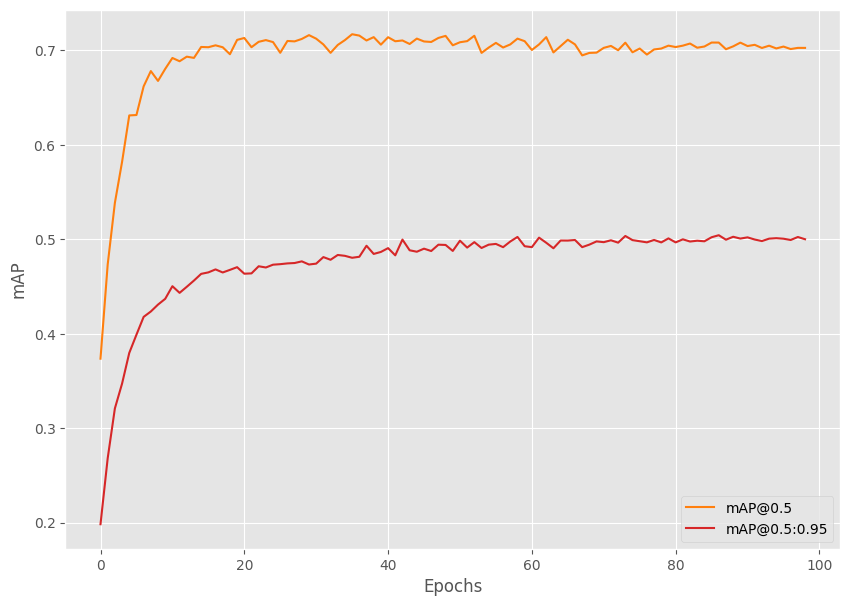

In [12]:
for epoch in range(start_epochs, NUM_EPOCHS):
        train_loss_hist.reset()

        _, batch_loss_list, \
             batch_loss_cls_list, \
             batch_loss_box_reg_list, \
             batch_loss_objectness_list, \
             batch_loss_rpn_list = train_one_epoch(
            model, 
            optimizer, 
            train_loader, 
            DEVICE, 
            epoch, 
            train_loss_hist,
            print_freq=100,
            scheduler=scheduler
        )

        coco_evaluator, stats, val_pred_image = evaluate(
            model, 
            valid_loader, 
            device=DEVICE,
            save_valid_preds=SAVE_VALID_PREDICTIONS,
            out_dir=OUT_DIR,
            classes=CLASSES,
            colors=COLORS
        )

        # Append the current epoch's batch-wise losses to the `train_loss_list`.
        train_loss_list.extend(batch_loss_list)
        loss_cls_list.extend(batch_loss_cls_list)
        loss_box_reg_list.extend(batch_loss_box_reg_list)
        loss_objectness_list.extend(batch_loss_objectness_list)
        loss_rpn_list.extend(batch_loss_rpn_list)
        # Append curent epoch's average loss to `train_loss_list_epoch`.
        train_loss_list_epoch.append(train_loss_hist.value)
        val_map_05.append(stats[1])
        val_map.append(stats[0])

        # Save loss plot for batch-wise list.
        save_loss_plot(OUT_DIR, train_loss_list)
        # Save loss plot for epoch-wise list.
        save_loss_plot(
            OUT_DIR, 
            train_loss_list_epoch,
            'epochs',
            'train loss',
            save_name='train_loss_epoch' 
        )
        save_loss_plot(
            OUT_DIR, 
            loss_cls_list, 
            'iterations', 
            'loss cls',
            save_name='loss_cls'
        )
        save_loss_plot(
            OUT_DIR, 
            loss_box_reg_list, 
            'iterations', 
            'loss bbox reg',
            save_name='loss_bbox_reg'
        )
        save_loss_plot(
            OUT_DIR,
            loss_objectness_list,
            'iterations',
            'loss obj',
            save_name='loss_obj'
        )
        save_loss_plot(
            OUT_DIR,
            loss_rpn_list,
            'iterations',
            'loss rpn bbox',
            save_name='loss_rpn_bbox'
        )

        # Save mAP plots.
        save_mAP(OUT_DIR, val_map_05, val_map)

        coco_log(OUT_DIR, stats)

        # Save the current epoch model state. This can be used 
        # to resume training. It saves model state dict, number of
        # epochs trained for, optimizer state dict, and loss function.
        save_model(
            epoch, 
            model, 
            optimizer, 
            train_loss_list, 
            train_loss_list_epoch,
            val_map,
            val_map_05,
            OUT_DIR,
            data_configs,
            "fasterrcnn_resnet50_fpn"
        )
        # Save the model dictionary only for the current epoch. 
        save_model_state(model, OUT_DIR, data_configs, "fasterrcnn_resnet50_fpn")
        # Save best model if the current mAP @0.5:0.95 IoU is  greater than the last hightest.
        save_best_model(
            model, 
            val_map[-1], 
            epoch, 
            OUT_DIR,
            data_configs,
            "fasterrcnn_resnet50_fpn"
        )

In [13]:
# !pip install GPUtil
# !pip install numba

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()     

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 63% |
|  1 |  0% | 71% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  0% | 63% |
|  1 | 60% |  0% |
